# Colocation analysis

## Table of Contents:
* [Load data](#first-bullet)  
    COVID-19 weekly new confirmed cases  
    Degree Centrality of Co-location map  
    Reproduction rate   
  

* [Pre-processing](#second-bullet)
* [Visulization](#third-bullet)
* [Correlation Analysis](#fourth-bullet)  
    Analysis of Reduction of degree centrality and CDC first-order growth rate  
    Analysis of Degree centrality and Reproduction rate  
    
    
* [Time Lagged Cross Correlation Analysis](#fifth-bullet)  
    Analysis of Reduction of degree centrality and CDC first-order growth rate  
    Analysis of Degree centrality and Reproduction rate  
    Analysis of Degree centrality and CDC second-order growth rate  
* [Travel reduction and segregation across county groups](#sixth-bullet)  
    T-test results for the metric values across different county groups  
    Visualization of the metric values across different county groups

In [436]:
import pandas as pd
import numpy as np
import csv
import seaborn as sns
import matplotlib.pyplot as plt
import math
from scipy import stats

import matplotlib.lines as mlines
from matplotlib import font_manager
from plotly.subplots import make_subplots

from matplotlib.colors import LogNorm


# Load data <a class="anchor" id="first-bullet"></a>

#### Load CDC COVID-19 confirmed cases from COVID-19 Data Repositoy of Johns Hopkins
https://github.com/CSSEGISandData/COVID-19/tree/master/csse_covid_19_data/csse_covid_19_time_series

In [24]:
def returnCDCdata(path_cdc):
    cdc_df = pd.read_csv(path_cdc)
    cdc_df = cdc_df[cdc_df.Country_Region == 'US']

    terri = [2,15,60,66,69,72,78]
    for ter in terri:
        cdc_df = cdc_df[cdc_df.FIPS != ter]

    # cdc_df = cdc_df[~cdc_df.FIPS.str.contains('|'.join(terri))]
    cdc_df = cdc_df.dropna()
    cdc_df = cdc_df[cdc_df.Admin2 != 'Unassigned']
    cdc_df = cdc_df[cdc_df.Lat != 0]

    cdc_df = cdc_df[['Admin2', 'Province_State',
           'Lat', 'Long_','1/22/20', '1/23/20',
           '1/24/20', '1/25/20', '1/26/20', '1/27/20', '1/28/20', '1/29/20',
           '1/30/20', '1/31/20', '2/1/20', '2/2/20', '2/3/20', '2/4/20', '2/5/20',
           '2/6/20', '2/7/20', '2/8/20', '2/9/20', '2/10/20', '2/11/20', '2/12/20',
           '2/13/20', '2/14/20', '2/15/20', '2/16/20', '2/17/20', '2/18/20',
           '2/19/20', '2/20/20', '2/21/20', '2/22/20', '2/23/20', '2/24/20',
           '2/25/20', '2/26/20', '2/27/20', '2/28/20', '2/29/20', '3/1/20',
           '3/2/20', '3/3/20', '3/4/20', '3/5/20', '3/6/20', '3/7/20', '3/8/20',
           '3/9/20', '3/10/20', '3/11/20', '3/12/20', '3/13/20', '3/14/20',
           '3/15/20', '3/16/20', '3/17/20', '3/18/20', '3/19/20', '3/20/20',
           '3/21/20', '3/22/20', '3/23/20', '3/24/20', '3/25/20', '3/26/20',
           '3/27/20', '3/28/20', '3/29/20', '3/30/20', '3/31/20', '4/1/20',
           '4/2/20', '4/3/20', '4/4/20', '4/5/20', '4/6/20', '4/7/20', '4/8/20',
           '4/9/20', '4/10/20', '4/11/20', '4/12/20', '4/13/20', '4/14/20',
           '4/15/20','4/16/20','4/17/20','4/18/20','4/19/20','4/20/20','4/21/20',
            '4/22/20','4/23/20','4/24/20','4/25/20','4/26/20','4/27/20','4/28/20',
            '4/29/20','4/30/20','5/1/20','5/2/20','5/3/20','5/4/20','5/5/20']]

    return cdc_df.rename(columns={'Admin2': 'COUNTY', 'Province_State': 'STATE', 'Long_': 'Lon'})


path_cdc = 'colocation_v2/time_series_covid19_confirmed_US.csv'
cdc_df = returnCDCdata(path_cdc)
cdc_df

COUNTY    STATE        Lat         Lon  1/22/20  1/23/20  1/24/20  \
5        Autauga  Alabama  32.539527  -86.644082        0        0        0   
6        Baldwin  Alabama  30.727750  -87.722071        0        0        0   
7        Barbour  Alabama  31.868263  -85.387129        0        0        0   
8           Bibb  Alabama  32.996421  -87.125115        0        0        0   
9         Blount  Alabama  33.982109  -86.567906        0        0        0   
...          ...      ...        ...         ...      ...      ...      ...   
3142  Sweetwater  Wyoming  41.659439 -108.882788        0        0        0   
3143       Teton  Wyoming  43.935225 -110.589080        0        0        0   
3144       Uinta  Wyoming  41.287818 -110.547578        0        0        0   
3145    Washakie  Wyoming  43.904516 -107.680187        0        0        0   
3146      Weston  Wyoming  43.839612 -104.567488        0        0        0   

      1/25/20  1/26/20  1/27/20  ...  4/26/20  4/27/20  4/28/20  4/29/20  \
5           0        0        0  ...       37       39       40       43   
6           0        0        0  ...      161      168      171      174   
7           0        0        0  ...       33       35       37       37   
8           0        0        0  ...       38       42       42       42   
9           0        0        0  ...       34       34       34       36   
...       ...      ...      ...  ...      ...      ...      ...      ...   
3142        0        0        0  ...       16       16       16       17   
3143        0        0        0  ...       95       95       96       96   
3144        0        0        0  ...        7        7        8        8   
3145        0        0        0  ...        8        8        8        8   
3146        0        0        0  ...        0        0        0        0   

      4/30/20  5/1/20  5/2/20  5/3/20  5/4/20  5/5/20  
5          44      42      45      48      53      53  
6         174     175     181     187     188     189  
7          39      42      43      45      45      47  
8          42      42      42      43      42      43  
9          37      39      40      40      40      40  
...       ...     ...     ...     ...     ...     ...  
3142       18      18      18      18      18      18  
3143       96      96      97      98      98      98  
3144        8       8       8       8       8       8  
3145        8       8       8       8       8       8  
3146        0       0       0       0       0       0  

[3142 rows x 109 columns]

#### Load degree centrality data from the preprocessed data of Facebook colocation probability dataset

In [438]:
week_style_1 = ['3/3/20','3/10/20','3/17/20','3/24/20','3/31/20','4/7/20','4/14/20','4/21/20','4/28/20','5/5/20']
week_style_2 = ['0303','0310','0317','0324','0331','0407','0414','0421','0428','0505']
week_style_3 = ['2020-03-03','2020-03-10', '2020-03-17','2020-03-24','2020-03-31','2020-04-07','2020-04-14',
                '2020-04-21','2020-04-28','2020-05-05']

# load weekly ranked centrality data

btwn_rank = {}
dgre_rank = {}
for week in week_style_2:
    btwn_rank[week] = pd.read_csv('colocation_v2/save_ranks/betweenness_centrality_rank_'+week+'.csv')
    dgre_rank[week] = pd.read_csv('colocation_v2/save_ranks/degree_centrality_rank_'+week+'.csv')

#### Load reproduction rate

In [94]:
path_cdc = 'colocation/covidcasedf_selected_dates.csv'
r0_df = pd.read_csv(path_cdc)

# Preprocessing <a class="anchor" id="second-bullet"></a>

#### Make pairing dataframe to match colocation polygon id with county name and  FIPS

In [26]:
# Pair polygon id and county name

def returnIdCountyPair(sample_df_path):
    df = pd.read_csv(sample_df_path)

    pairs = df[['polygon1_id','name_stack_1']]
    pairs = pairs.drop_duplicates()
    pairs = pairs.reset_index()
    temp_list = []
    for index, row in pairs.iterrows():
        s_c = row.name_stack_1.split(' // ')
        cc = s_c[1]
        ss = s_c[0]
        temp_list.append([cc,ss])

    temp_df = pd.DataFrame(temp_list)
    temp_df = temp_df.rename(columns={0:'COUNTY',1 :'STATE'})

    pairs_id_s_c_t = pd.concat([pairs, temp_df], axis=1)
    pairs_id_s_c = pairs_id_s_c_t[['polygon1_id','COUNTY','STATE']]
    
    pop_id = df[['polygon1_id','E_TOTPOP_x']].rename(columns={'E_TOTPOP_x':'POPULATION'})
    
    return pairs_id_s_c_t, pairs_id_s_c, pop_id

sample_df_path = 'colocation_v2/save_df/week0211_df.csv'
pairs_id_s_c_t, pairs_id_s_c, pop_id = returnIdCountyPair(sample_df_path)

In [27]:
# Pair of polygon id and FIPS
path_cdc = 'colocation_v2/time_series_covid19_confirmed_US.csv'
fips_df = pd.read_csv(path_cdc)
fips_df = fips_df[fips_df.Country_Region == 'US']

# terri = [2,15,60,66,69,72,78]
# for ter in terri:
#     fips_df = fips_df[cdc_df.FIPS != ter]

    # cdc_df = cdc_df[~cdc_df.FIPS.str.contains('|'.join(terri))]
fips_df = fips_df.dropna()
fips_df = fips_df[fips_df.Admin2 != 'Unassigned']
fips_df = fips_df[fips_df.Lat != 0]
fips_df = fips_df[['FIPS','Admin2','Province_State']].rename(columns={'Admin2':'COUNTY','Province_State':'STATE'})
fips_df.FIPS = fips_df.FIPS.astype(int)

id_FIPS_df = pairs_id_s_c.merge(fips_df,on=['COUNTY','STATE'])[['polygon1_id','FIPS']]

#### Vectorize dataset

In [28]:
# CDC confirmed cases 
# save total cases until the week and newly confirmed cases in the week



def subtract(row):
    return  (row.iloc[-1] - row.iloc[-2])


cdc_weekly_confirmed = {}
cdc_weekly_confirmed_d = {}

for i, week in enumerate(week_style_2):
    cdc_weekly_confirmed[week] = cdc_df[['COUNTY','STATE',week_style_1[i]]]
    cdc_weekly_confirmed[week]['Confirmed'] = cdc_weekly_confirmed[week][week_style_1[i]]
    cdc_weekly_confirmed[week] = cdc_weekly_confirmed[week].merge(pairs_id_s_c, how='inner', on=['COUNTY', 'STATE'])[['polygon1_id','Confirmed']]

for i, week in enumerate(week_style_2):
    if i == 0:
        # differential vector init
        cdc_weekly_confirmed_d[week] = cdc_weekly_confirmed[week].copy()
    else:
        cdc_weekly_confirmed_d[week] = cdc_weekly_confirmed[week_style_2[i-1]].merge(cdc_weekly_confirmed[week], on='polygon1_id')
        cdc_weekly_confirmed_d[week]['Confirmed'] = cdc_weekly_confirmed_d[week].apply(lambda row: subtract(row), axis=1)
        cdc_weekly_confirmed_d[week] = cdc_weekly_confirmed_d[week][['polygon1_id', 'Confirmed']]
        

/home/ubuntu/anaconda3/envs/shlee/lib/python3.6/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


In [342]:
# cdc_ranking : county ranking based on cdc confirmed cases
cdc_ranking = cdc_weekly_confirmed['0317'].sort_values(by=['Confirmed'],ascending=False)['polygon1_id']

In [439]:
for i, week in enumerate(week_style_2):
    
    # Betweenness Centrality
    btwn_rank_df = btwn_rank[week].T.rename(columns={0:'Betweenness_Centrality'})

    temp = btwn_rank_df.reset_index().rename(columns={'index': 'polygon1_id'})
    temp.polygon1_id = temp.polygon1_id.astype(int)
    btwn_rank_df = temp[['polygon1_id','Betweenness_Centrality']]

    rank_df = btwn_rank_df.copy()
    
    rank_df = rank_df.merge(pairs_id_s_c, on=['polygon1_id'])
    rank_df['week'] = week_style_3[i]
    
    if i == 0:
        # vector init
        btwn_vector = rank_df[['polygon1_id','Betweenness_Centrality']]
        
    elif i == 1:
        btwn_vector = btwn_vector.merge(rank_df[['polygon1_id','Betweenness_Centrality']],on=['polygon1_id'])

    elif i > 1:
        btwn_vector = btwn_vector.merge(rank_df[['polygon1_id','Betweenness_Centrality']],on=['polygon1_id'])

    # Degree Centrality
    dgr_rank_df = dgre_rank[week].T.rename(columns={0:'Degree_Centrality'})

    temp = dgr_rank_df.reset_index().rename(columns={'index': 'polygon1_id'})
    temp.polygon1_id = temp.polygon1_id.astype(int)
    dgr_rank_df = temp[['polygon1_id','Degree_Centrality']]

    rank_df = dgr_rank_df.copy()
    
    cdc_weekly_confirmed[week].polygon1_id = cdc_weekly_confirmed[week].polygon1_id.astype(int)
    
    rank_df = rank_df.merge(cdc_weekly_confirmed[week], on=['polygon1_id'])
    rank_df = rank_df.merge(pairs_id_s_c, on=['polygon1_id'])
    rank_df['week'] = week_style_3[i]
    
    if i == 0:
        # vector init
        dgre_vector = rank_df[['polygon1_id','Degree_Centrality']]
        confirmed_vector = rank_df[['polygon1_id', 'Confirmed']]
        
    elif i == 1:
        dgre_vector = dgre_vector.merge(rank_df[['polygon1_id','Degree_Centrality']],on=['polygon1_id'])
        confirmed_vector = confirmed_vector.merge(rank_df[['polygon1_id','Confirmed']],on=['polygon1_id'])

    elif i > 1:
        dgre_vector = dgre_vector.merge(rank_df[['polygon1_id','Degree_Centrality']],on=['polygon1_id'])
        confirmed_vector = confirmed_vector.merge(rank_df[['polygon1_id','Confirmed']],on=['polygon1_id'])

vector_cols = ['polygon1_id','2020-03-03','2020-03-10','2020-03-17',
               '2020-03-24', '2020-03-31','2020-04-07','2020-04-14','2020-04-21','2020-04-28','2020-05-05']

btwn_vector = btwn_vector.set_axis(vector_cols,axis=1)
dgre_vector = dgre_vector.set_axis(vector_cols,axis=1)
confirmed_vector = confirmed_vector.set_axis(vector_cols,axis=1)

In [344]:
def returnDgreReduction(row):
    baseline = row[vector_cols[1]]
    for wk in vector_cols[2:]:
        row[wk] = baseline - row[wk]
    row[1] = 0
    return row

dgre_reduction_vector = dgre_vector.copy()
dgre_reduction_vector = dgre_vector.apply(lambda row: returnDgreReduction(row), axis=1)


# Second order COVID19 growth rate

confirmed_2_vector = confirmed_1_vector.copy()

def returnSecDeriv(row):
    new_row = row.copy()
    for i, wk in enumerate(vector_cols[1:]):
        if i == 0:
            new_row[wk] = None
        elif i == 1:
            new_row[wk] = row[wk] - 0
        else:
            new_row[wk] = row[wk] - row[vector_cols[i]]
    return new_row[1:]

confirmed_2_vector[vector_cols[1:]] = confirmed_1_vector.apply(lambda row: returnSecDeriv(row), axis=1)


In [444]:
# Save vectors in csv files

# btwn_vector.to_csv('betweenness_centrality_vector.csv',index=False)
# dgre_vector.to_csv('degree_centrality_vector.csv',index=False)

In [445]:
dgre_vector

polygon1_id  2020-03-03  2020-03-10  2020-03-17  2020-03-24  2020-03-31  \
0         1214815    0.017133    0.010508    0.010648    0.010109    0.008940   
1         1214941    0.014292    0.011299    0.011960    0.012282    0.010493   
2         1195746    0.013368    0.011400    0.010086    0.004825    0.002429   
3         1195962    0.012952    0.011427    0.008984    0.004248    0.001999   
4         1414817    0.010820    0.010859    0.005020    0.006538    0.003942   
...           ...         ...         ...         ...         ...         ...   
2985      1433611    0.000073    0.000068    0.000052    0.000030    0.000027   
2986      1433597    0.000071    0.000068    0.000050    0.000024    0.000021   
2987      1433635    0.000069    0.000061    0.000047    0.000026    0.000022   
2988      1433591    0.000052    0.000086    0.000044    0.000036    0.000018   
2989      1433615    0.000043    0.000059    0.000033    0.000015    0.000007   

      2020-04-07  2020-04-14  2020-04-21  2020-04-28  2020-05-05  
0       0.006465    0.002451    0.003574    0.006463    0.006746  
1       0.007047    0.002736    0.003832    0.007159    0.008051  
2       0.001420    0.001683    0.001691    0.002049    0.002369  
3       0.000893    0.001392    0.001208    0.001501    0.001792  
4       0.003205    0.002428    0.002261    0.005352    0.005638  
...          ...         ...         ...         ...         ...  
2985    0.000022    0.000024    0.000025    0.000028    0.000031  
2986    0.000018    0.000018    0.000021    0.000023    0.000025  
2987    0.000021    0.000021    0.000022    0.000024    0.000027  
2988    0.000020    0.000019    0.000017    0.000022    0.000027  
2989    0.000007    0.000007    0.000007    0.000009    0.000012  

[2990 rows x 11 columns]

In [346]:
dgre_reduction_vector

polygon1_id  2020-03-03  2020-03-10  2020-03-17  2020-03-24  2020-03-31  \
0       1214815.0         0.0    0.006626    0.006485    0.007025    0.008194   
1       1214941.0         0.0    0.002994    0.002332    0.002011    0.003799   
2       1195746.0         0.0    0.001968    0.003282    0.008543    0.010939   
3       1195962.0         0.0    0.001525    0.003968    0.008704    0.010952   
4       1414817.0         0.0   -0.000039    0.005800    0.004282    0.006879   
...           ...         ...         ...         ...         ...         ...   
2985    1433611.0         0.0    0.000005    0.000021    0.000043    0.000047   
2986    1433597.0         0.0    0.000004    0.000022    0.000047    0.000050   
2987    1433635.0         0.0    0.000008    0.000022    0.000042    0.000046   
2988    1433591.0         0.0   -0.000034    0.000008    0.000016    0.000034   
2989    1433615.0         0.0   -0.000016    0.000009    0.000028    0.000035   

      2020-04-07  2020-04-14  2020-04-21  2020-04-28  2020-05-05  
0       0.010669    0.014683    0.013559    0.010670    0.010388  
1       0.007245    0.011557    0.010460    0.007133    0.006241  
2       0.011948    0.011685    0.011677    0.011319    0.010999  
3       0.012059    0.011560    0.011743    0.011451    0.011160  
4       0.007615    0.008392    0.008559    0.005468    0.005182  
...          ...         ...         ...         ...         ...  
2985    0.000051    0.000050    0.000048    0.000045    0.000042  
2986    0.000053    0.000054    0.000050    0.000049    0.000047  
2987    0.000048    0.000048    0.000047    0.000045    0.000042  
2988    0.000032    0.000033    0.000035    0.000030    0.000025  
2989    0.000036    0.000036    0.000036    0.000034    0.000031  

[2990 rows x 11 columns]

In [347]:
# First order COVID19 growth rate

confirmed_1_vector = confirmed_vector.copy()

def returnFirstDeriv(row):
    new_row = row.copy()
    for i, wk in enumerate(vector_cols[1:]):
        if i == 0:
            new_row[wk] = row[wk] - row[wk]
        else:
            new_row[wk] = row[wk] - row[vector_cols[i]]
    return new_row[1:]

confirmed_1_vector[vector_cols[1:]] = confirmed_vector.apply(lambda row: returnFirstDeriv(row),axis=1)

# Second order COVID19 growth rate

confirmed_2_vector = confirmed_1_vector.copy()

def returnSecDeriv(row):
    new_row = row.copy()
    for i, wk in enumerate(vector_cols[1:]):
        if i == 0:
            new_row[wk] = None
        elif i == 1:
            new_row[wk] = row[wk] - 0
        else:
            new_row[wk] = row[wk] - row[vector_cols[i]]
    return new_row[1:]

confirmed_2_vector[vector_cols[1:]] = confirmed_1_vector.apply(lambda row: returnSecDeriv(row), axis=1)


In [348]:
confirmed_vector

polygon1_id  2020-03-03  2020-03-10  2020-03-17  2020-03-24  2020-03-31  \
0         1214815           0           0           0           0           0   
1         1214941           0           0           0           0           0   
2         1195746           0           0           0           0           0   
3         1195962           0           0           0           0           0   
4         1414817           0           0           0           0           0   
...           ...         ...         ...         ...         ...         ...   
2985      1433611           0           4          15          57         371   
2986      1433597           1          20         144         662        3019   
2987      1433635           0           1          10          35         126   
2988      1433591           0           0           2           6          33   
2989      1433615           2           3          55         226         603   

      2020-04-07  2020-04-14  2020-04-21  2020-04-28  2020-05-05  
0              0           0           0           1           1  
1              0           1           1           1           1  
2              0           0           1           1           1  
3              0           1           1           1           1  
4              0           0           0           1           1  
...          ...         ...         ...         ...         ...  
2985        1016        1961        2847        3735        4454  
2986        6936       10047       15153       20996       27836  
2987         243         317         428         508         595  
2988          68         100         175         284         400  
2989        1404        1847        2325        3141        4020  

[2990 rows x 11 columns]

In [349]:
confirmed_1_vector

polygon1_id  2020-03-03  2020-03-10  2020-03-17  2020-03-24  2020-03-31  \
0         1214815           0           0           0           0           0   
1         1214941           0           0           0           0           0   
2         1195746           0           0           0           0           0   
3         1195962           0           0           0           0           0   
4         1414817           0           0           0           0           0   
...           ...         ...         ...         ...         ...         ...   
2985      1433611           0           4          11          42         314   
2986      1433597           0          19         124         518        2357   
2987      1433635           0           1           9          25          91   
2988      1433591           0           0           2           4          27   
2989      1433615           0           1          52         171         377   

      2020-04-07  2020-04-14  2020-04-21  2020-04-28  2020-05-05  
0              0           0           0           1           0  
1              0           1           0           0           0  
2              0           0           1           0           0  
3              0           1           0           0           0  
4              0           0           0           1           0  
...          ...         ...         ...         ...         ...  
2985         645         945         886         888         719  
2986        3917        3111        5106        5843        6840  
2987         117          74         111          80          87  
2988          35          32          75         109         116  
2989         801         443         478         816         879  

[2990 rows x 11 columns]

In [350]:
confirmed_2_vector

polygon1_id  2020-03-03  2020-03-10  2020-03-17  2020-03-24  2020-03-31  \
0         1214815         NaN         0.0         0.0         0.0         0.0   
1         1214941         NaN         0.0         0.0         0.0         0.0   
2         1195746         NaN         0.0         0.0         0.0         0.0   
3         1195962         NaN         0.0         0.0         0.0         0.0   
4         1414817         NaN         0.0         0.0         0.0         0.0   
...           ...         ...         ...         ...         ...         ...   
2985      1433611         NaN         4.0         7.0        31.0       272.0   
2986      1433597         NaN        19.0       105.0       394.0      1839.0   
2987      1433635         NaN         1.0         8.0        16.0        66.0   
2988      1433591         NaN         0.0         2.0         2.0        23.0   
2989      1433615         NaN         1.0        51.0       119.0       206.0   

      2020-04-07  2020-04-14  2020-04-21  2020-04-28  2020-05-05  
0            0.0         0.0         0.0         1.0        -1.0  
1            0.0         1.0        -1.0         0.0         0.0  
2            0.0         0.0         1.0        -1.0         0.0  
3            0.0         1.0        -1.0         0.0         0.0  
4            0.0         0.0         0.0         1.0        -1.0  
...          ...         ...         ...         ...         ...  
2985       331.0       300.0       -59.0         2.0      -169.0  
2986      1560.0      -806.0      1995.0       737.0       997.0  
2987        26.0       -43.0        37.0       -31.0         7.0  
2988         8.0        -3.0        43.0        34.0         7.0  
2989       424.0      -358.0        35.0       338.0        63.0  

[2990 rows x 11 columns]

In [351]:
r0_orgn = r0_df.copy()
r0_orgn = r0_orgn.merge(id_FIPS_df, on='FIPS').drop(columns='FIPS')
columns_r0 = r0_orgn.columns.tolist()
columns_r0 = columns_r0[-1:] + columns_r0[:-1]
r0_orgn = r0_orgn[columns_r0]
r0_orgn.columns = dgre_vector.columns
r0_orgn

polygon1_id  2020-03-03  2020-03-10  2020-03-17  2020-03-24  2020-03-31  \
0         1068417         NaN         NaN         NaN         NaN         NaN   
1         1068422         NaN         NaN         NaN    2.027919    3.152383   
2         1068431         NaN         NaN         NaN         NaN         NaN   
3         1068437         NaN         NaN         NaN         NaN         NaN   
4         1068441         NaN         NaN         NaN         NaN         NaN   
...           ...         ...         ...         ...         ...         ...   
3024      1430443         NaN         NaN         NaN         NaN         NaN   
3025      1430449         NaN         NaN         NaN         NaN    3.235937   
3026      1430452         NaN         NaN         NaN         NaN         NaN   
3027      1430455         NaN         NaN         NaN         NaN         NaN   
3028      1430458         NaN         NaN         NaN         NaN         NaN   

      2020-04-07  2020-04-14  2020-04-21  2020-04-28  2020-05-05  
0       1.424050    1.393474    1.262314    1.245702    1.201152  
1       1.690638    1.751184    1.323457    1.240872    1.085211  
2            NaN    2.385530    1.690638    1.368540    1.197644  
3            NaN    1.866613    1.424050    1.229721    1.065073  
4       1.424050    1.270870    1.424050    1.278564    1.086416  
...          ...         ...         ...         ...         ...  
3024    2.272347    1.349550    1.524408    1.270870    1.061910  
3025    1.729794    1.213538    1.288119    1.249794    1.015983  
3026         NaN    1.424050    1.330299    1.158027    1.070473  
3027    2.027919    1.120532    1.270870    1.270870    1.000000  
3028         NaN         NaN         NaN         NaN         NaN  

[3029 rows x 11 columns]

In [352]:
r0_fit_dict = {}
for index, row in r0_orgn.iterrows():
    if row[0] in dgre_vector.polygon1_id.values:
        if np.isnan(row[1:].values).sum():
            if np.isnan(row[1:]).sum() < len(time_cols)-1:
                r0Start = np.nanargmax(row[1:].values)
                if 2 <= len(time_cols)-r0Start:
                    r0_fit_dict[row[0]] = row[r0Start+1:]
        else:
            r0Start = np.argmax(row[1:].values)
            if 2 <= len(time_cols)-r0Start:
                r0_fit_dict[row[0]] = row[r0Start+1:]
                
dgre_fit_dict = {}
for index, row in dgre_vector.iterrows():
    if row[0] in r0_fit_dict.keys():
        temp_r0_fit = r0_fit_dict[row[0]]
        w_len = len(temp_r0_fit)
        
        dgreStart = np.argmax(row[1:].values)
        dgre_fit_dict[row[0]] = row[(dgreStart)+1:(dgreStart+w_len +1)]
        
r0_fit_df = pd.DataFrame.from_dict(r0_fit_dict).T.reset_index().rename(columns={'index':'polygon1_id'})
dgre_fit_df = pd.DataFrame.from_dict(dgre_fit_dict).T.reset_index().rename(columns={'index':'polygon1_id'})

r0_fit_replace_df = r0_fit_df.fillna(method='bfill',axis=1)
r0_fit_replace_df = r0_fit_replace_df.dropna()

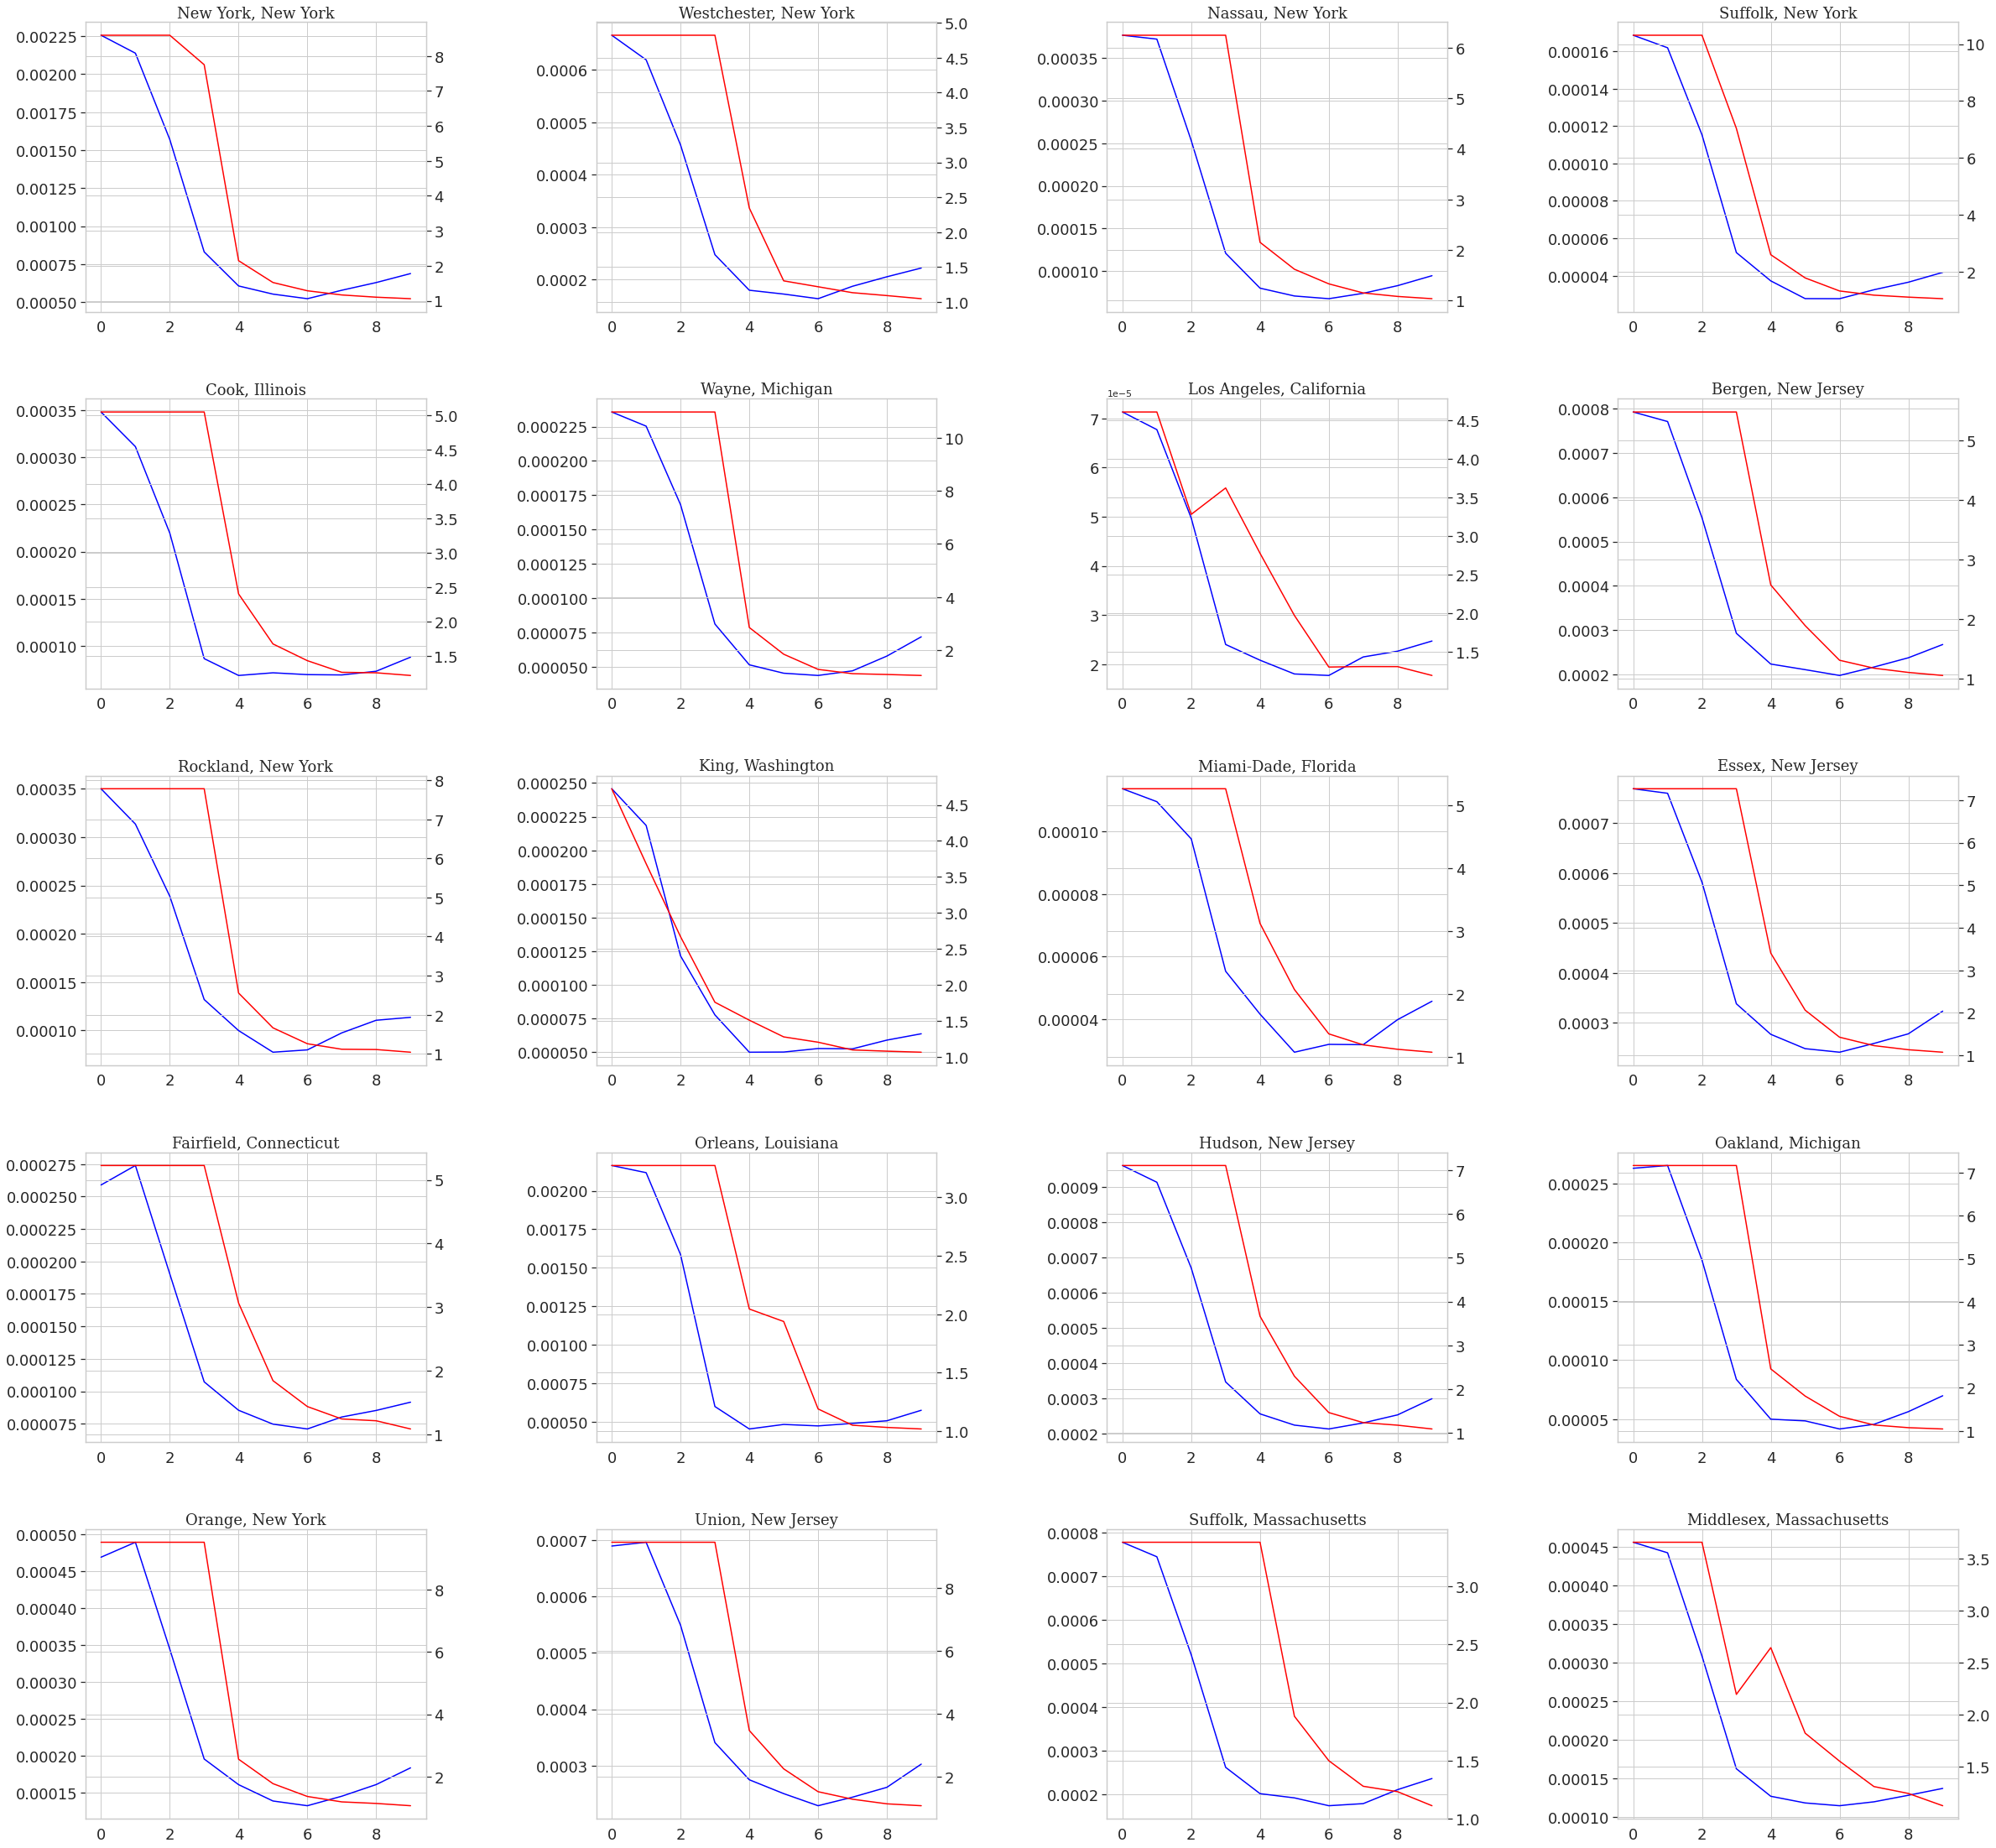

In [353]:
fig, axs = plt.subplots(5, 4,figsize=(40,35))
plt.subplots_adjust(wspace=0.5, hspace=0.3,
                    left=0.125, right=0.9,
                    top=0.95,    bottom=0.1)

j = 0
for row in range(5):
    for col in range(4):
        for i in range(j,3000,1):
            if len(r0_fit_df[r0_fit_df.polygon1_id==id_list[i]].values) != 0:
                dgre_df = dgre_vector[dgre_vector.polygon1_id==id_list[i]].drop(columns=['polygon1_id'])
                r0_temp_df = r0_fit_replace_df[r0_fit_replace_df.polygon1_id==id_list[i]].drop(columns=['polygon1_id'])
                axs[row, col].plot(np.array(range(0,len(vector_cols[1:]),1)), dgre_df.values[0],c='blue')
                axs[row, col].set_title(subplot_title[i],fontname='serif',fontsize=18)
                axs[row, col].tick_params(axis='x',labelsize=18)
                axs[row, col].tick_params(axis='y',labelsize=18)

                axs2 = axs[row, col].twinx()
                axs2.plot(np.array(range(0,len(vector_cols[1:]),1)), r0_temp_df.values[0], c='red')
                axs2.tick_params(axis='y',labelsize=18)
                j = i+1
                break
        


# Data Visualization <a class="anchor" id="third-bullet"></a>

In [354]:


# Load shelter in place start dates
path_shorder = 'colocation/stay_home_order.csv'
stayorder_df = pd.read_csv(path_shorder)
stayorder = stayorder_df[['State', 'Effective Date']].rename(columns={'State':'STATE','Effective Date' : 'Effective_Date'})
stayorder['Effective_Date'] = stayorder.Effective_Date.apply(lambda x: x.split('at')[0])

# Check when confirmed cases are exceeded 100 cases and 1000 cases
confirmed_rank = confirmed_vector.copy()
def returnDateover100(row):
    elmtlist = row.values
    for i, elmt in enumerate(elmtlist[1:]):
        if elmt > 100:
            return vector_cols[i]
    return 0

def returnDateover1000(row):
    elmtlist = row.values
    for i, elmt in enumerate(elmtlist[1:-1]):
        if elmt > 1000:
            return vector_cols[i]
    return 0

confirmed_rank['<100'] = confirmed_rank.apply(lambda row: returnDateover100(row), axis =1)
confirmed_rank['<1000'] = confirmed_rank.apply(lambda row: returnDateover1000(row), axis =1)


# Make time mark dataframe
time_mark = confirmed_rank.merge(pairs_id_s_c[['polygon1_id', 'STATE']], on='polygon1_id').merge(stayorder, on='STATE')[['polygon1_id','<100','<1000','Effective_Date'
]]
time_mark.Effective_Date.unique()

def returnTimechange(date):
    ts = pd.to_datetime(date)
    for week in week_style_3:
        if str(ts).split(' ')[0] < week:
            return week
time_mark.Effective_Date = time_mark.Effective_Date.apply(lambda date: returnTimechange(date))


time_cols = vector_cols[1:]

dgre_vector_named = dgre_vector.merge(pairs_id_s_c, how='inner',on="polygon1_id")
ticks_font = font_manager.FontProperties(family='serif', style='normal', size=18, weight='normal', stretch='normal')

/home/ubuntu/anaconda3/envs/shlee/lib/python3.6/site-packages/ipykernel_launcher.py:14: DeprecationWarning:

The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.

/home/ubuntu/anaconda3/envs/shlee/lib/python3.6/site-packages/ipykernel_launcher.py:16: DeprecationWarning:

The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.

/home/ubuntu/anaconda3/envs/shlee/lib/python3.6/site-packages/ipykernel_launcher.py:14: DeprecationWarning:

The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.

/home/ubuntu/anaconda3/envs/shlee/lib/python3.6/site-packages/ipykernel_launcher.py:16: DeprecationWarning:

The truth value of an empty array is ambiguous. Returning Fa

Text(0.5, 1.0, 'Degree centrality of top 20 counties in US\n')

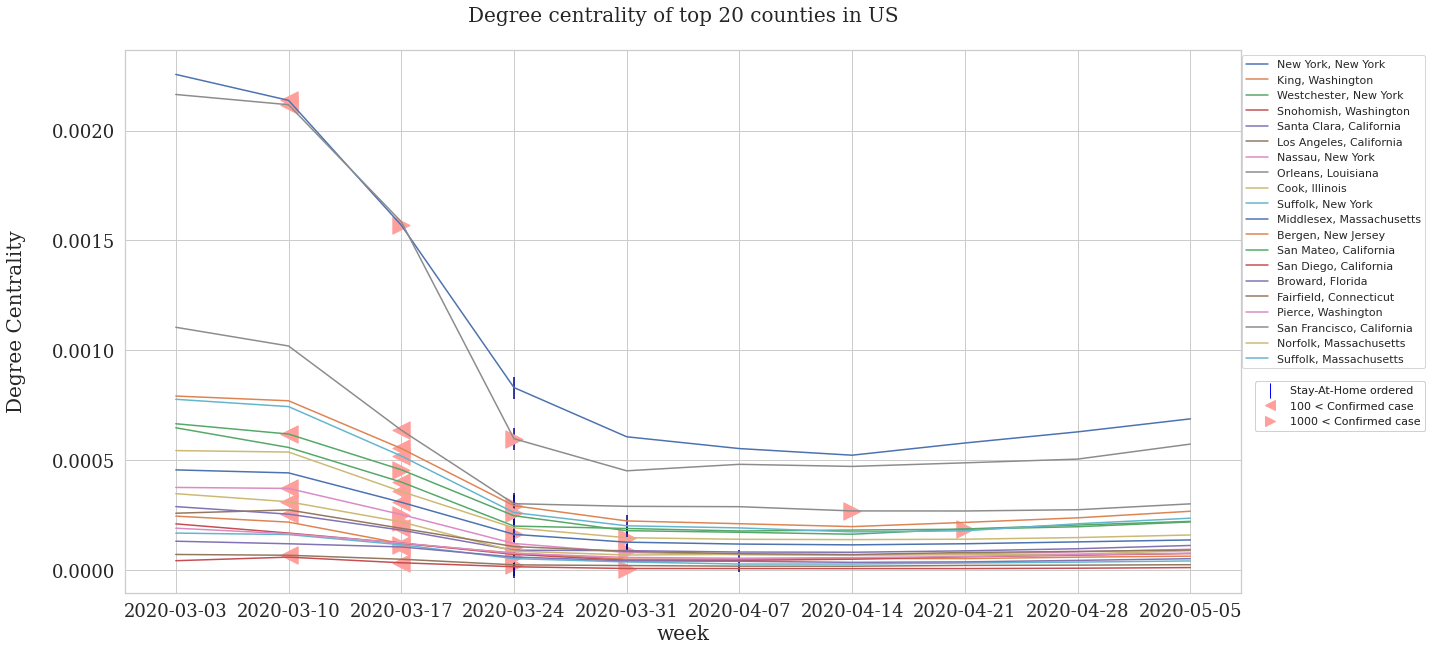

In [355]:
# Draw degree centrality of the highly infected counties on March 31st
fig, ax = plt.subplots(figsize=(20,10))
for i, idx in enumerate(cdc_ranking.values):
    if i>=20:
        break
    else:
        n_row = dgre_vector_named[dgre_vector_named.polygon1_id==idx]
        label = n_row['COUNTY'].values+', '+n_row['STATE'].values
        data = n_row[time_cols].T
        markers_on = [1,3,4]
        n_ts = time_mark[time_mark.polygon1_id==idx]
        ax.plot(data.index.values,data.values, label=label[0])
        ax.scatter(n_ts.Effective_Date.values, n_row[n_ts.Effective_Date.values].values[0], marker='|', c='darkblue', s=500)
        if n_ts['<100'].values != 0:
            ax.scatter(n_ts['<100'].values, n_row[n_ts['<100'].values].values[0], marker='<',c='r', s=300)
        if n_ts['<1000'].values != 0:
            ax.scatter(n_ts['<1000'].values, n_row[n_ts['<1000'].values].values[0], marker='>', c='r', s=300)
        
        ax.set_xlabel("week", fontname='serif', fontsize=20)
        ax.set_ylabel("Degree Centrality\n",fontname='serif',fontsize=20)
#         ax.set_fontproperties('serif')
#         ax.tick_params(axis='x',labelsize=18)
#         ax.tick_params(axis='y',labelsize=18)
#         ax.yticks(fontname='serif')

for labelx in ax.get_xticklabels() :
    labelx.set_fontproperties(ticks_font)
for labely in ax.get_yticklabels() :
    labely.set_fontproperties(ticks_font)
    


blue_star = mlines.Line2D([], [], color='blue', marker='|', linestyle='None',
                          markersize=15, label='Stay-At-Home ordered')
red_square = mlines.Line2D([], [], color='r', marker='<', linestyle='None',
                          markersize=10, label='100 < Confirmed case')
purple_triangle = mlines.Line2D([], [], color='r', marker='>', linestyle='None',
                          markersize=10, label='1000 < Confirmed case')

legend1 = ax.legend(loc='upper right', bbox_to_anchor=(1.17, 1.0))
legend2 = ax.legend(loc='upper right', bbox_to_anchor=(1.17, 0.4),handles=[blue_star, red_square, purple_triangle])
ax.add_artist(legend1)
ax.add_artist(legend2)
plt.title('Degree centrality of top 20 counties in US\n', fontname='serif', fontsize=20)
# plt.savefig('Top20_dgreCen.pdf',bbox_inches = 'tight')

In [356]:
# Draw on subplots


cdc_ranking_name = cdc_ranking.to_frame().merge(pairs_id_s_c, how='inner', on="polygon1_id")
county_list = cdc_ranking_name.COUNTY.values[0:50]
state_list = cdc_ranking_name.STATE.values[0:50]
id_list = cdc_ranking_name.polygon1_id.values[0:50]

subplot_title = []
for i in range(len(county_list)):
    subplot_title.append(county_list[i]+', '+state_list[i])

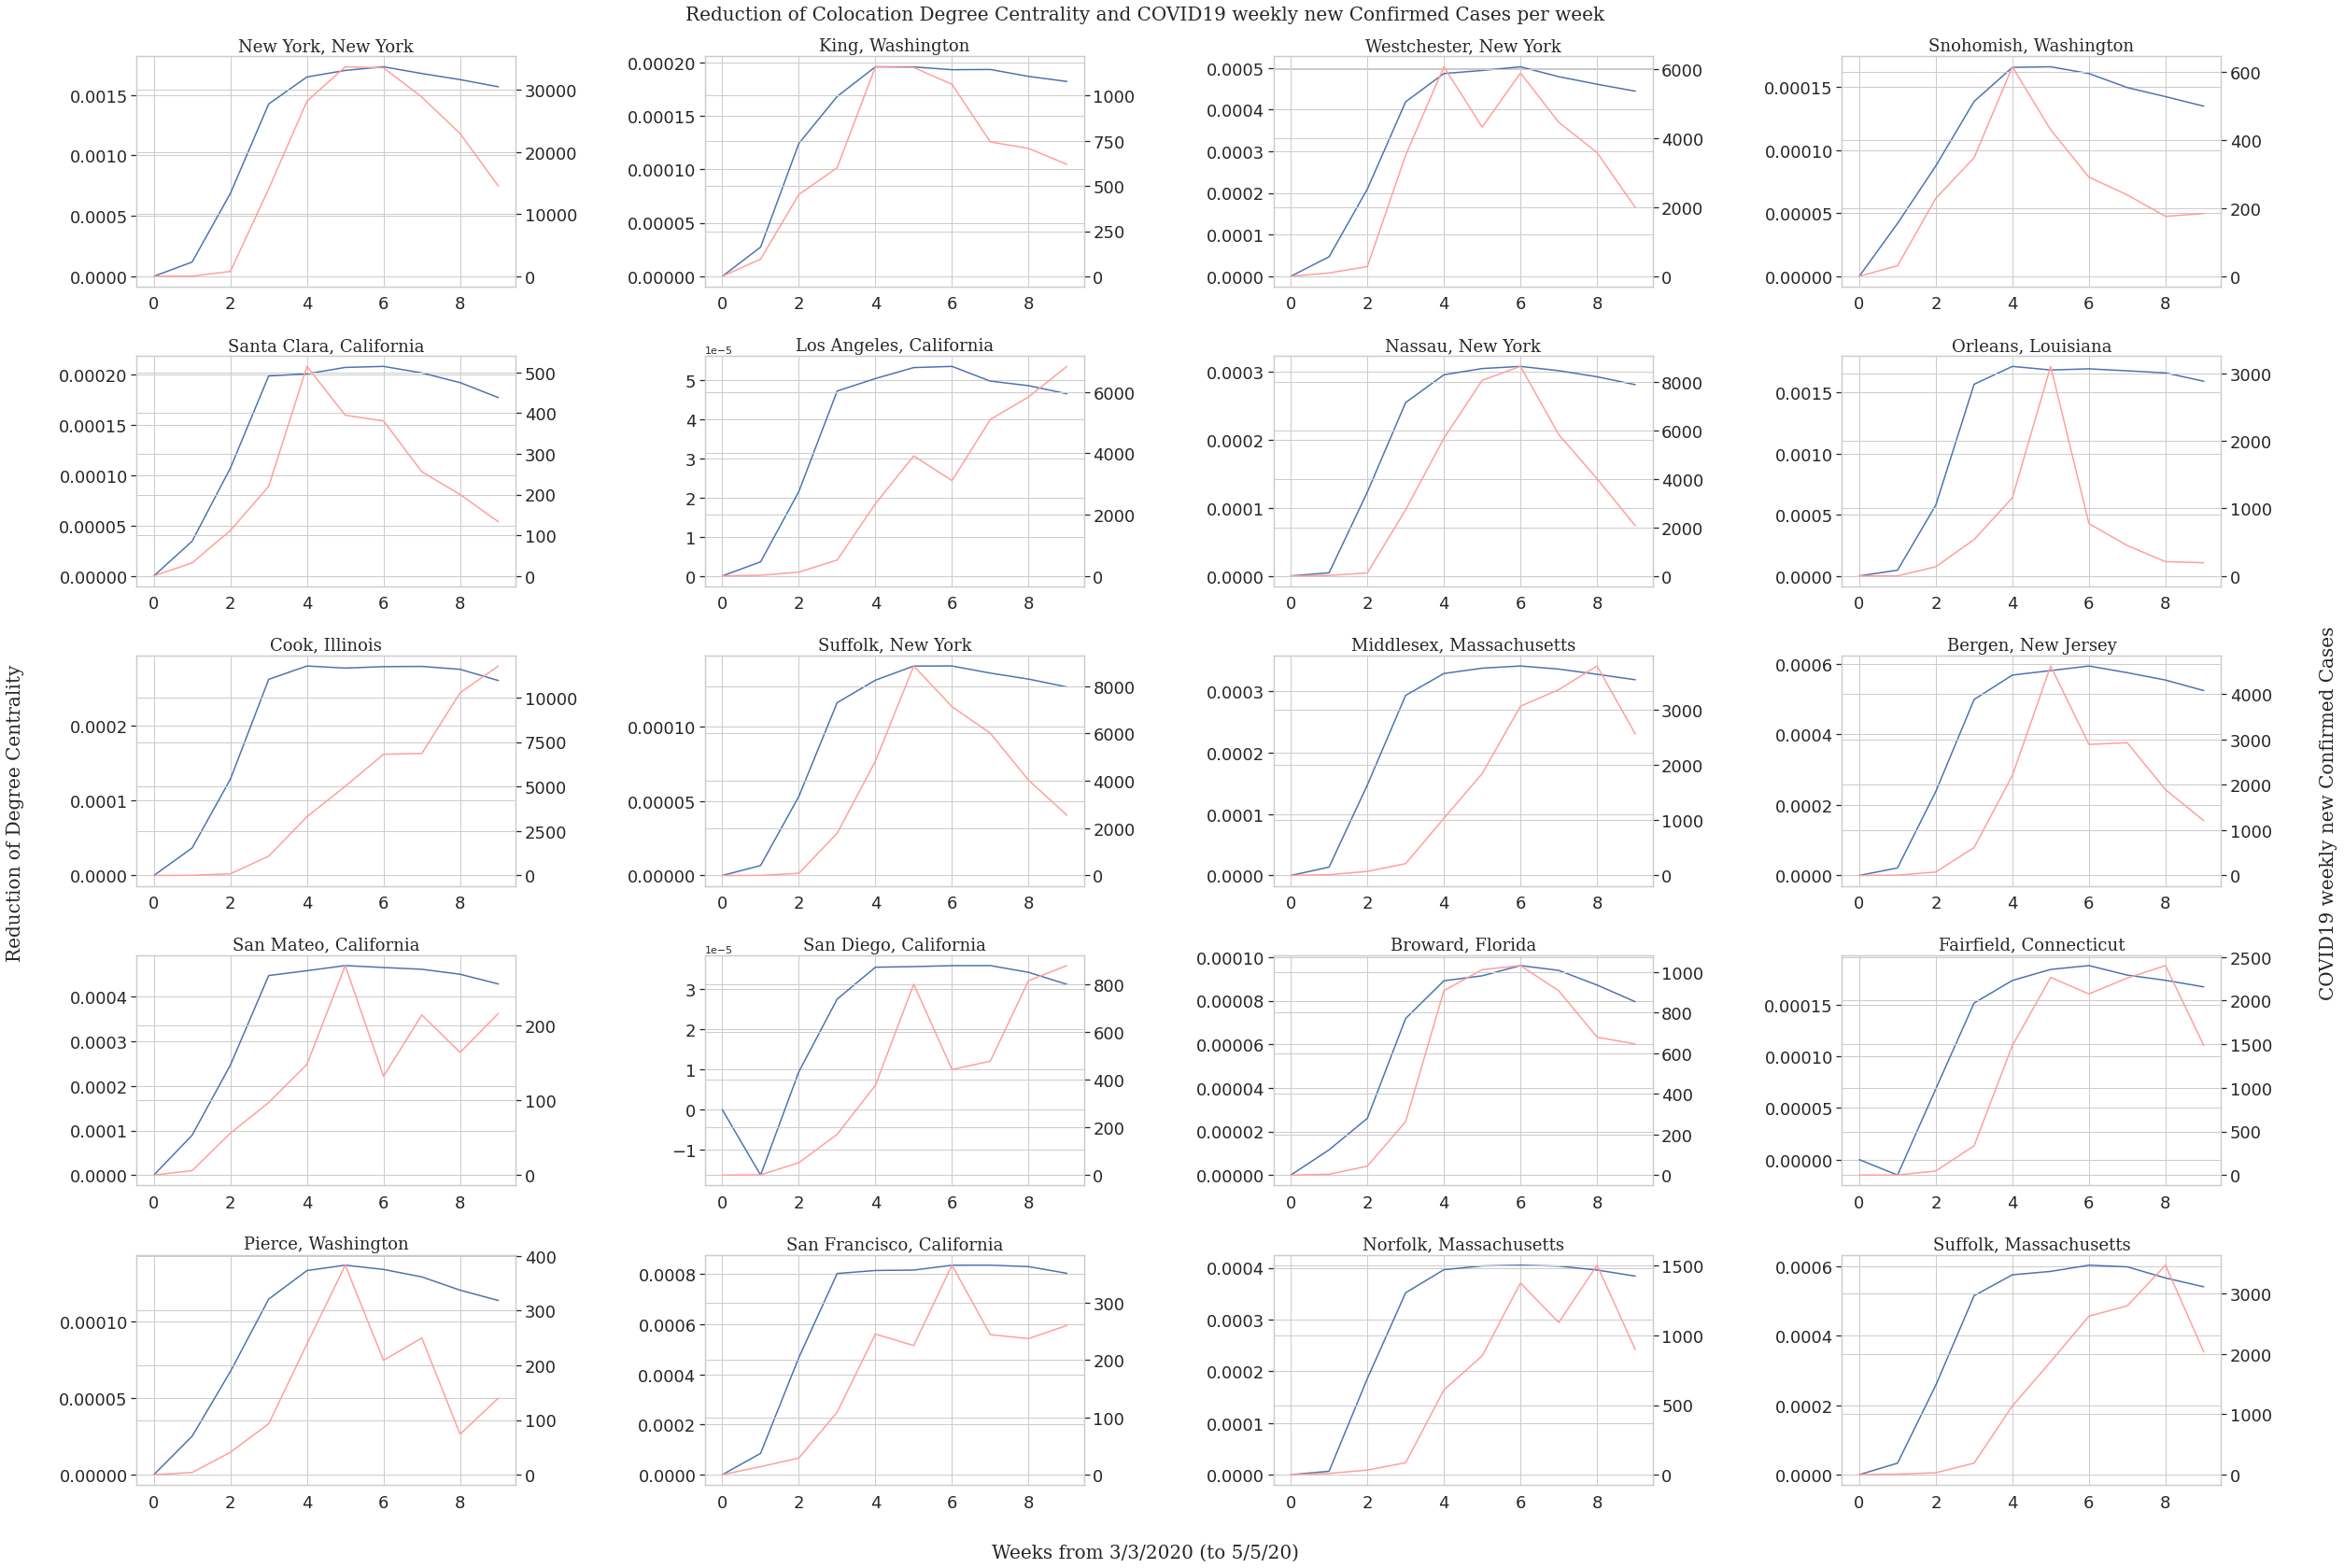

In [357]:
fig, axs = plt.subplots(5, 4,figsize=(40,25))
plt.subplots_adjust(wspace=0.5, hspace=0.3,
                    left=0.125, right=0.9,
                    top=0.95,    bottom=0.1)

i = 0
for row in range(5):
    for col in range(4):
        dgre_df = dgre_reduction_vector[dgre_reduction_vector.polygon1_id==id_list[i]].drop(columns=['polygon1_id'])
        cdc_confirmed_df = confirmed_1_vector[confirmed_1_vector.polygon1_id==id_list[i]].drop(columns=['polygon1_id'])
        axs[row, col].plot(np.array(range(0,len(vector_cols[1:]),1)), dgre_df.values[0])
        axs[row, col].set_title(subplot_title[i],fontname='serif',fontsize=18)
        axs[row, col].tick_params(axis='x',labelsize=18)
        axs[row, col].tick_params(axis='y',labelsize=18)
        
        axs2 = axs[row, col].twinx()
        axs2.plot(np.array(range(0,len(vector_cols[1:]),1)), cdc_confirmed_df.values[0],c='r')
        axs2.tick_params(axis='y',labelsize=18)
        

#         secax = axs[row, col].secondary_yaxis('right',functions=(list(dgre_df.columns.values), cdc_confirmed_df.values[0]))
#         secax.set_ylabel('COVID19 Confirmed Cases')

        i += 1
        
# axs.annotate('figure pixels',
#             xy=(10, 10), xycoords='figure pixels')
# axs.annotate('figure points',
#             xy=(80, 80), xycoords='figure points')
# axs.annotate('figure fraction',
#             xy=(.025, .975), xycoords='figure fraction',
#             horizontalalignment='left', verticalalignment='top',
#             fontsize=20)

# for ax in axs.flat:
#     ax.set(xlabel='Weeks from 3/3/2020 (to 4/28/20)', ylabel='Degree Centrality')
# for ax2 in axs2.flat:
#     ax2.set_ylabel('COVID19 Confirmed Cases')
# Hide x labels and tick labels for top plots and y ticks for right plots.
# for ax in axs.flat:
#     ax.label_outer()
# axs.xlabel('Weeks from 3/3/2020 (to 4/28/20)')
# axs.ylabel('Degree Centrality')
# axs2.ylabel('COVID19 Confirmed Cases')

fig.suptitle('Reduction of Colocation Degree Centrality and COVID19 weekly new Confirmed Cases per week',fontname='serif',fontsize=20)
fig.text(0.5, 0.06, 'Weeks from 3/3/2020 (to 5/5/20)', fontname='serif', fontsize=20, ha='center', va='center')
fig.text(0.08, 0.5, 'Reduction of Degree Centrality', fontname='serif', fontsize=20, ha='center', va='center', rotation='vertical')
fig.text(0.94, 0.5, 'COVID19 weekly new Confirmed Cases', fontname='serif', fontsize=20, ha='center', va='center', rotation='vertical')
# plt.savefig('DegreeCentrality_and_Covid19WeeklyNewConfirmedCases.pdf', bbox_inches='tight') 
plt.show()

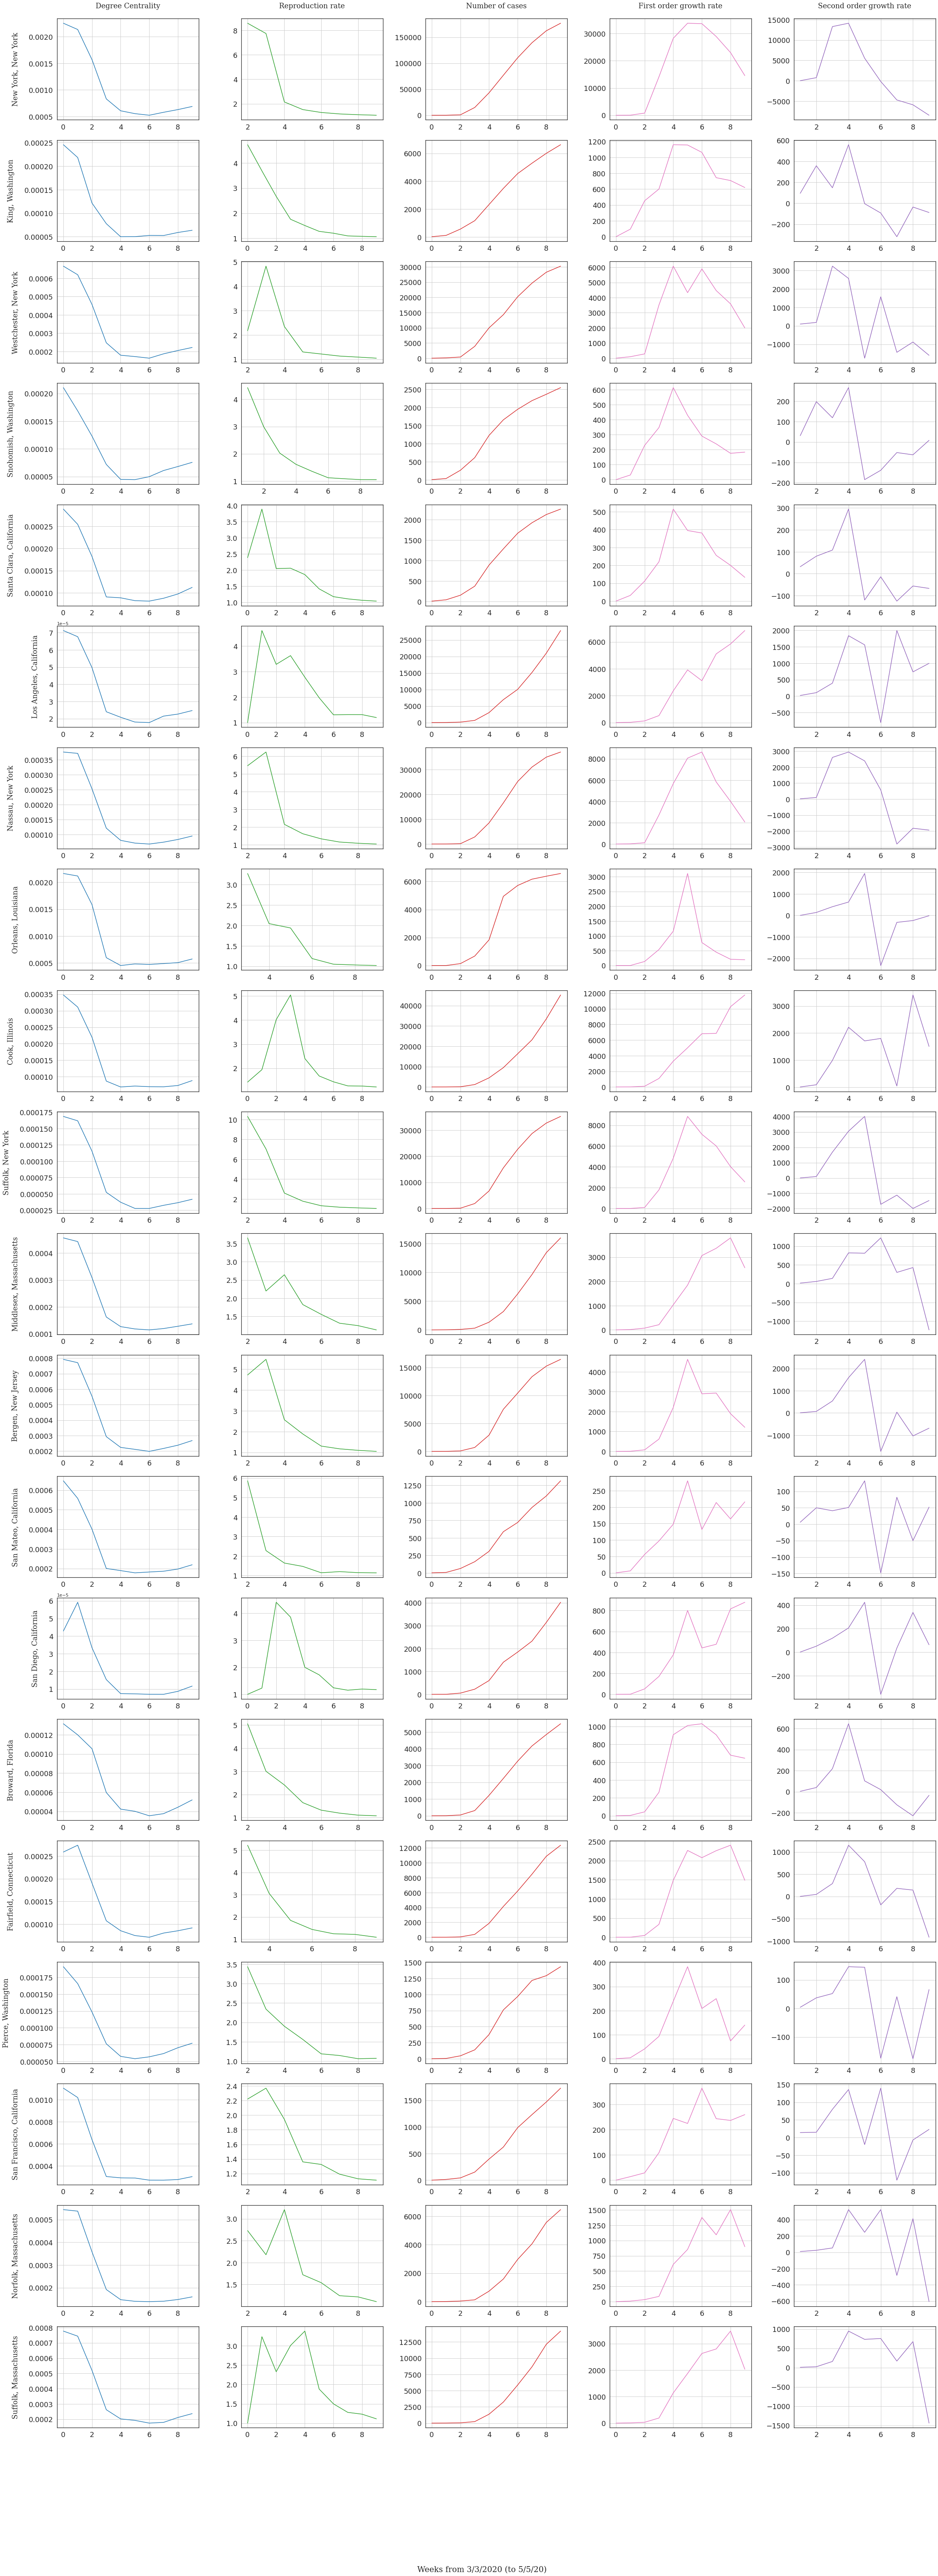

In [360]:
fig, axs = plt.subplots(20, 5,figsize=(40,100))
plt.subplots_adjust(wspace=0.3, hspace=0.2,
                    left=0.125, right=0.9,
                    top=0.95,    bottom=0.1)


# i = 0
for row in range(20):
    dgre_df = dgre_vector[dgre_vector.polygon1_id==id_list[row]].drop(columns=['polygon1_id'])
    r0_temp_df = r0_orgn[r0_orgn.polygon1_id ==id_list[row]].drop(columns=['polygon1_id'])
    cdc_confirmed_df = confirmed_vector[confirmed_vector.polygon1_id==id_list[row]].drop(columns=['polygon1_id'])
    cdc_confirmed_1_df = confirmed_1_vector[confirmed_1_vector.polygon1_id==id_list[row]].drop(columns=['polygon1_id'])
    cdc_confirmed_2_df = confirmed_2_vector[confirmed_2_vector.polygon1_id==id_list[row]].drop(columns=['polygon1_id'])
     
    axs[row, 0].plot(np.array(range(0,len(vector_cols[1:]),1)), dgre_df.values[0], c='tab:blue')
    axs[row, 0].tick_params(axis='x',labelsize=18)
    axs[row, 0].tick_params(axis='y',labelsize=18)
    axs[row, 0].set_ylabel(subplot_title[row]+'\n',fontname='serif',fontsize=18)
    
    
    axs[row, 1].plot(np.array(range(0,len(vector_cols[1:]),1)), r0_temp_df.values[0], c='tab:green')
    axs[row, 1].tick_params(axis='x',labelsize=18)
    axs[row, 1].tick_params(axis='y',labelsize=18)
    
    axs[row, 2].plot(np.array(range(0,len(vector_cols[1:]),1)), cdc_confirmed_df.values[0], c='tab:red')
    axs[row, 2].tick_params(axis='x',labelsize=18)
    axs[row, 2].tick_params(axis='y',labelsize=18)
    
    axs[row, 3].plot(np.array(range(0,len(vector_cols[1:]),1)), cdc_confirmed_1_df.values[0], c='tab:pink')
    axs[row, 3].tick_params(axis='x',labelsize=18)
    axs[row, 3].tick_params(axis='y',labelsize=18)
    
    axs[row, 4].plot(np.array(range(0,len(vector_cols[1:]),1)), cdc_confirmed_2_df.values[0], c='tab:purple')
    axs[row, 4].tick_params(axis='x',labelsize=18)
    axs[row, 4].tick_params(axis='y',labelsize=18)
    
    if row==0:
        axs[row, 0].set_title('Degree Centrality\n',fontname='serif',fontsize=18)
        axs[row, 1].set_title('Reproduction rate\n',fontname='serif',fontsize=18)
        axs[row, 2].set_title('Number of cases\n',fontname='serif',fontsize=18)
        axs[row, 3].set_title('First order growth rate\n',fontname='serif',fontsize=18)
        axs[row, 4].set_title('Second order growth rate\n',fontname='serif',fontsize=18)
        
    axs[row, 0].spines["top"].set_color('k')
    axs[row, 0].spines["left"].set_color('k')
    axs[row, 0].spines["right"].set_color('k')
    axs[row, 0].spines["bottom"].set_color('k')
    
    axs[row, 1].spines["top"].set_color('k')
    axs[row, 1].spines["left"].set_color('k')
    axs[row, 1].spines["right"].set_color('k')
    axs[row, 1].spines["bottom"].set_color('k')
    
    axs[row, 2].spines["top"].set_color('k')
    axs[row, 2].spines["left"].set_color('k')
    axs[row, 2].spines["right"].set_color('k')
    axs[row, 2].spines["bottom"].set_color('k')
    
    axs[row, 3].spines["top"].set_color('k')
    axs[row, 3].spines["left"].set_color('k')
    axs[row, 3].spines["right"].set_color('k')
    axs[row, 3].spines["bottom"].set_color('k')
    
    axs[row, 4].spines["top"].set_color('k')
    axs[row, 4].spines["left"].set_color('k')
    axs[row, 4].spines["right"].set_color('k')
    axs[row, 4].spines["bottom"].set_color('k')


# fig.suptitle('Reduction of Colocation Degree Centrality and COVID19 weekly new Confirmed Cases per week',fontname='serif',fontsize=20)
fig.text(0.5, 0.05, 'Weeks from 3/3/2020 (to 5/5/20)', fontname='serif', fontsize=20, ha='center', va='center')
# fig.text(0.08, 0.5, 'Reduction of Degree Centrality', fontname='serif', fontsize=20, ha='center', va='center', rotation='vertical')
# fig.text(0.94, 0.5, 'COVID19 weekly new Confirmed Cases', fontname='serif', fontsize=20, ha='center', va='center', rotation='vertical')
# plt.savefig('Five_Features_by_counties.pdf', bbox_inches='tight') 
plt.show()

In [361]:
# barplot of 
temp_dgre_vector = dgre_vector.copy()
temp_r0 = r0_orgn.copy()
temp_confirmed_vector =  confirmed_vector.copy()
temp_confirmed_1_vector = confirmed_1_vector.copy()
temp_confirmed_2_vector = confirmed_2_vector.copy()

temp_dgre_vector['feature'] = 'Degree_Centrality'
temp_r0['feature'] = 'R0'
temp_confirmed_vector['feature'] = 'N_ConfirmedCases'
temp_confirmed_1_vector['feature'] = 'First_Order_ConfirmedCases_Growth_Rate'
temp_confirmed_2_vector['feature'] = 'Second_Order_ConfirmedCases_Growth_Rate'

temp_dgre_vector = pd.melt(dgre_vector, id_vars=['polygon1_id'],value_vars=vector_cols[1:]).rename(columns={'value':'Degree_Centrality'})
temp_r0 = pd.melt(temp_r0, id_vars=['polygon1_id'], value_vars=vector_cols[1:]).rename(columns={'value':'R0'})
temp_confirmed_vector = pd.melt(confirmed_vector, id_vars=['polygon1_id'],value_vars=vector_cols[1:]).rename(columns={'value':'N_ConfirmedCases'})
temp_confirmed_1_vector = pd.melt(confirmed_1_vector, id_vars=['polygon1_id'],value_vars=vector_cols[1:]).rename(columns={'value':'First_Order_ConfirmedCases_Growth_Rate'})
temp_confirmed_2_vector = pd.melt(confirmed_2_vector, id_vars=['polygon1_id'],value_vars=vector_cols[1:]).rename(columns={'value':'Second_Order_ConfirmedCases_Growth_Rate'})

observation = temp_dgre_vector.merge(temp_confirmed_vector,on=['polygon1_id','variable'])
observation = observation.merge(temp_r0, on=['polygon1_id','variable'])
observation = observation.merge(temp_confirmed_1_vector,on=['polygon1_id','variable'])
observation = observation.merge(temp_confirmed_2_vector,on=['polygon1_id','variable'])


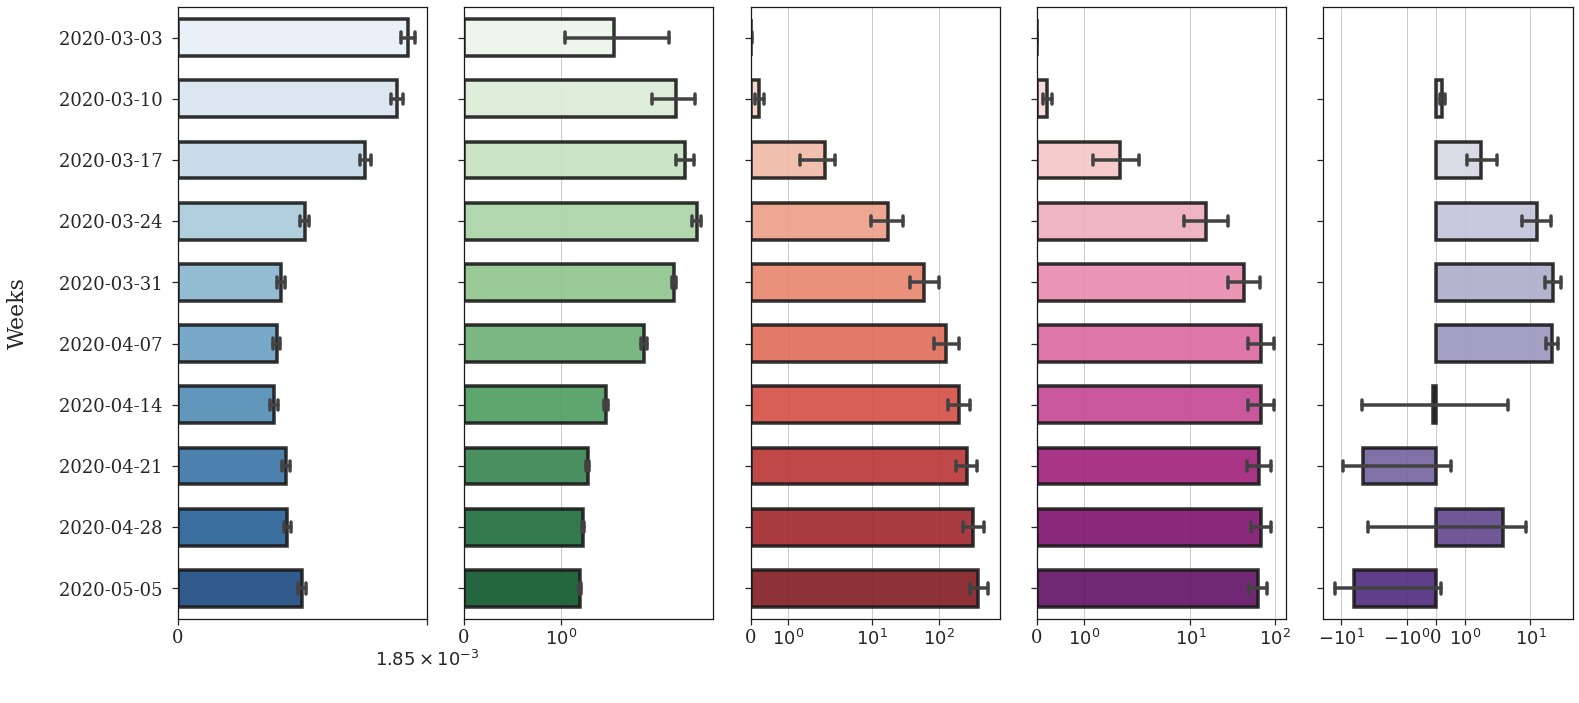

In [362]:
sns.set(style="ticks")

# Initialize the figure with a logarithmic x axis
# f, ax = plt.subplots(figsize=(15, 10))

fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1,5,figsize=(25, 10))
plt.subplots_adjust(wspace=0.15, hspace=0.3,
                    left=0.125, right=0.9,
                    top=0.95,    bottom=0.1)
kwargs = {'alpha':0.9, 'linestyle':'-',  'linewidth':3.5, 'edgecolor':'k'}

ax1.set_xscale("symlog")
ax2.set_xscale("symlog")
ax3.set_xscale("symlog")
ax4.set_xscale("symlog")
ax5.set_xscale("symlog")

# Plot the orbital period with horizontal boxes

sns.barplot(x="Degree_Centrality", y="variable", data=observation, errwidth = 3.5,
             palette="Blues", capsize=0.17 ,ax = ax1,**kwargs)

sns.barplot(x="R0", y="variable", data=observation,errwidth = 3.5,
             palette="Greens",capsize=0.17 , ax = ax2,**kwargs)

sns.barplot(x="N_ConfirmedCases", y="variable", data=observation,errwidth = 3.5,
             palette="Reds",capsize=0.17 , ax = ax3,**kwargs)


sns.barplot(x="First_Order_ConfirmedCases_Growth_Rate", y="variable", data=observation,errwidth = 3.5,
             palette="RdPu", capsize=0.17  ,ax = ax4,**kwargs)


sns.barplot(x="Second_Order_ConfirmedCases_Growth_Rate", y="variable", data=observation,errwidth = 3.5,
             palette="Purples", capsize=0.17  ,ax = ax5,**kwargs)


for bar in ax1.patches:
    y = bar.get_y()
    width = bar.get_height()
    centre = y + width/2.
    bar.set_y(centre-0.6/2)
    bar.set_height(0.6)

for bar in ax2.patches:
    y = bar.get_y()
    width = bar.get_height()
    centre = y + width/2.
    bar.set_y(centre-0.6/2)
    bar.set_height(0.6)

for bar in ax3.patches:
    y = bar.get_y()
    width = bar.get_height()
    centre = y + width/2.
    bar.set_y(centre-0.6/2)
    bar.set_height(0.6)

for bar in ax4.patches:
    y = bar.get_y()
    width = bar.get_height()
    centre = y + width/2.
    bar.set_y(centre-0.6/2)
    bar.set_height(0.6)

for bar in ax5.patches:
    y = bar.get_y()
    width = bar.get_height()
    centre = y + width/2.
    bar.set_y(centre-0.6/2)
    bar.set_height(0.6)
    
# new_value = .35
# for patch in ax1.patches :
#     current_width = patch.get_heigh()
#     diff = current_width - new_value

#         # we change the bar width
#     patch.set_heigh(new_value)

#         # we recenter the bar
#     patch.set_y(patch.get_x() + diff * .5)
    

# Tweak the visual presentation

ax1.xaxis.grid(True)
ax1.set_ylabel("Weeks\n", fontname="serif", fontsize=22)
ax1.set_yticklabels(['2020-03-03 ','2020-03-10 ','2020-03-17 ','2020-03-24 ','2020-03-31 ',
                     '2020-04-07 ','2020-04-14 ','2020-04-21 ','2020-04-28 ','2020-05-05 '],fontname='serif', size=18)
ax1.set_xticklabels(['0','\n'+r'$1.85\times10^{-3}$'],fontname='serif', size=18)
ax1.set_xlabel(" ", fontname="serif", fontsize=22)


ax2.xaxis.grid(True)
ax2.set(ylabel="")
ax2.set_yticklabels([' ',' ',' ',' ',' ',' ',' ',' ',' ',' '],fontname='serif', size=18)
ax2.set_xticklabels(['0',r'$10^{0}$'],fontname='serif', size=18)
ax2.set_xlabel(" ", fontname="serif", fontsize=22)

ax3.xaxis.grid(True)
ax3.set(ylabel="")
ax3.set_yticklabels([' ',' ',' ',' ',' ',' ',' ',' ',' ',' '],fontname='serif', size=18)
ax3.set_xticklabels(['0',r'$10^{0}$',r'$10^{1}$',r'$10^{2}$'],fontname='serif', size=18)
ax3.set_xlabel(" ", fontname="serif", fontsize=22)


ax4.xaxis.grid(True)
ax4.set(ylabel="")
ax4.set_yticklabels([' ',' ',' ',' ',' ',' ',' ',' ',' ',' '],fontname='serif', size=18)
ax4.set_xticklabels(['0',r'$10^{0}$',r'$10^{1}$',r'$10^{2}$'],fontname='serif', size=18)
ax4.set_xlabel(" ", fontname="serif", fontsize=22)


ax5.xaxis.grid(True)
ax5.set(ylabel="")
ax5.set_yticklabels([' ',' ',' ',' ',' ',' ',' ',' ',' ',' '],fontname='serif', size=18)
ax5.set_xticklabels([r'$-10^{1}$',r'$-10^{0}$','0',r'$10^{0}$',r'$10^{1}$'],fontname='serif', size=18)
ax5.set_xlabel(" ", fontname="serif", fontsize=22)

ax1.spines["top"].set_color('k')
ax1.spines["left"].set_color('k')
ax1.spines["right"].set_color('k')
ax1.spines["bottom"].set_color('k')

ax2.spines["top"].set_color('k')
ax2.spines["left"].set_color('k')
ax2.spines["right"].set_color('k')
ax2.spines["bottom"].set_color('k')

ax3.spines["top"].set_color('k')
ax3.spines["left"].set_color('k')
ax3.spines["right"].set_color('k')
ax3.spines["bottom"].set_color('k')

ax4.spines["top"].set_color('k')
ax4.spines["left"].set_color('k')
ax4.spines["right"].set_color('k')
ax4.spines["bottom"].set_color('k')

ax5.spines["top"].set_color('k')
ax5.spines["left"].set_color('k')
ax5.spines["right"].set_color('k')
ax5.spines["bottom"].set_color('k')


# plt.savefig('Barplot_R0_DgreCen_Ncf_F_S.pdf', bbox_inches='tight')

# Correlation Analysis <a class="anchor" id="fourth-bullet"></a>

## Analysis of Reduction of degree centrality and CDC first-order growth rate

In [363]:

dgre_counties = list(dgre_reduction_vector.polygon1_id.values)
# cdc_counties = list(confirmed_vector_diff_stdnorm.polygon1_id.values)
cdc_counties = list(cdc_ranking.values)
corr_dic_dgre = {}
pval = {}
time_cols = vector_cols[1:]
for county in dgre_counties:
    if county in cdc_counties:
        temp_dgre = dgre_reduction_vector[dgre_reduction_vector.polygon1_id==county][time_cols].T.set_axis([county], axis=1).copy()
        temp_cdc = confirmed_1_vector[confirmed_1_vector.polygon1_id==county][time_cols].T.set_axis(['CDC'],axis=1).copy()
        corr_dic_dgre[county] , pval[county] = stats.pearsonr(temp_dgre[int(county)].values, temp_cdc['CDC'].values)
#         pair = temp_dgre.join(temp_cdc)
#         pair = pair.set_axis([county, 'CDC'],axis=1)
#         corr_dic_dgre[county] = pair.corr().iloc[0,1]
corr_dic_dgre = {k: v for k, v in corr_dic_dgre.items() if v > 0 or v < 0 }
pval_dgre = {k: v for k, v in pval.items() if v > 0 or v < 0 }

# ranking based on absolute corr values
corr_dgre_rank_absolute = {k: v for i, (k, v) in enumerate(sorted(corr_dic_dgre.items(), key=lambda item: abs(item[1]), reverse=True))}
corr_dgre_rank_absolute_df = pd.DataFrame(corr_dgre_rank_absolute.values(), index=corr_dgre_rank_absolute.keys()).reset_index().rename(columns={'index': 'polygon1_id', 0: 'Pearson_Corr'})
pairs_id_s_c_t = pairs_id_s_c_t.rename(columns={'name_stack_1': 'State // County'})
corr_dgre_rank_absolute_df  = corr_dgre_rank_absolute_df.merge(pairs_id_s_c_t[['polygon1_id','State // County']], how='inner', on="polygon1_id")
corr_dgre_rank_absolute_df = corr_dgre_rank_absolute_df.merge(pop_id, how='inner', on="polygon1_id")
corr_dgre_rank_absolute_df = corr_dgre_rank_absolute_df.drop_duplicates()


# ranking based on positive corr values
corr_dgre_rank_positive = {k: v for i, (k, v) in enumerate(sorted(corr_dic_dgre.items(), key=lambda item: item[1], reverse=True))}
corr_dgre_rank_positive_df = pd.DataFrame(corr_dgre_rank_positive.values(), index=corr_dgre_rank_positive.keys()).reset_index().rename(columns={'index': 'polygon1_id', 0: 'Pearson_Corr'})
pairs_id_s_c_t = pairs_id_s_c_t.rename(columns={'name_stack_1': 'State // County'})
corr_dgre_rank_positive_df  = corr_dgre_rank_positive_df.merge(pairs_id_s_c_t[['polygon1_id','State // County']], how='inner', on="polygon1_id")
corr_dgre_rank_positive_df = corr_dgre_rank_positive_df.merge(pop_id, how='inner', on="polygon1_id")
corr_dgre_rank_positive_df = corr_dgre_rank_positive_df.drop_duplicates()

# ranking based on negative corr values
corr_dgre_rank_negative = {k: v for i, (k, v) in enumerate(sorted(corr_dic_dgre.items(), key=lambda item: -(item[1]), reverse=True))}
corr_dgre_rank_negative_df = pd.DataFrame(corr_dgre_rank_negative.values(), index=corr_dgre_rank_negative.keys()).reset_index().rename(columns={'index': 'polygon1_id', 0: 'Pearson_Corr'})
pairs_id_s_c_t = pairs_id_s_c_t.rename(columns={'name_stack_1': 'State // County'})
corr_dgre_rank_negative_df  = corr_dgre_rank_negative_df.merge(pairs_id_s_c_t[['polygon1_id','State // County']], how='inner', on="polygon1_id")
corr_dgre_rank_negative_df = corr_dgre_rank_negative_df.merge(pop_id, how='inner', on="polygon1_id")
corr_dgre_rank_negative_df = corr_dgre_rank_negative_df.drop_duplicates()


# ranking based on cdc_ranking
corr_dgre_cdc_rank = {}
pval_dgre_cdc_rank = {}
for i, idx in enumerate(cdc_counties):
#     if i<20:
    
    if idx in corr_dic_dgre.keys():
        corr_dgre_cdc_rank[idx] = corr_dic_dgre[idx]
        pval_dgre_cdc_rank[idx] = pval_dgre[idx]

corr_dgre_cdc_rank_df = pd.DataFrame(corr_dgre_cdc_rank.values(), index=corr_dgre_cdc_rank.keys()).reset_index().rename(columns={'index': 'polygon1_id', 0: 'Pearson_Corr'})
pairs_id_s_c_t = pairs_id_s_c_t.rename(columns={'name_stack_1': 'State // County'})
corr_dgre_cdc_rank_df  = corr_dgre_cdc_rank_df.merge(pairs_id_s_c_t[['polygon1_id','State // County']], how='inner', on="polygon1_id")

pval_dgre_cdc_rank_df = pd.DataFrame(pval_dgre_cdc_rank.values(), index=pval_dgre_cdc_rank.keys()).reset_index().rename(columns={'index': 'polygon1_id', 0: 'p-value'})
# pairs_id_s_c_t = pairs_id_s_c_t.rename(columns={'name_stack_1': 'State // County'})
pval_dgre_cdc_rank_df  = pval_dgre_cdc_rank_df.merge(pairs_id_s_c_t[['polygon1_id','State // County']], how='inner', on="polygon1_id")

/home/ubuntu/anaconda3/envs/shlee/lib/python3.6/site-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.



Correlation coefficient and p value of Reduction of degree centrality and the weekly new CDC confirmed cases of counties
Ranked by cdc confirmed cases



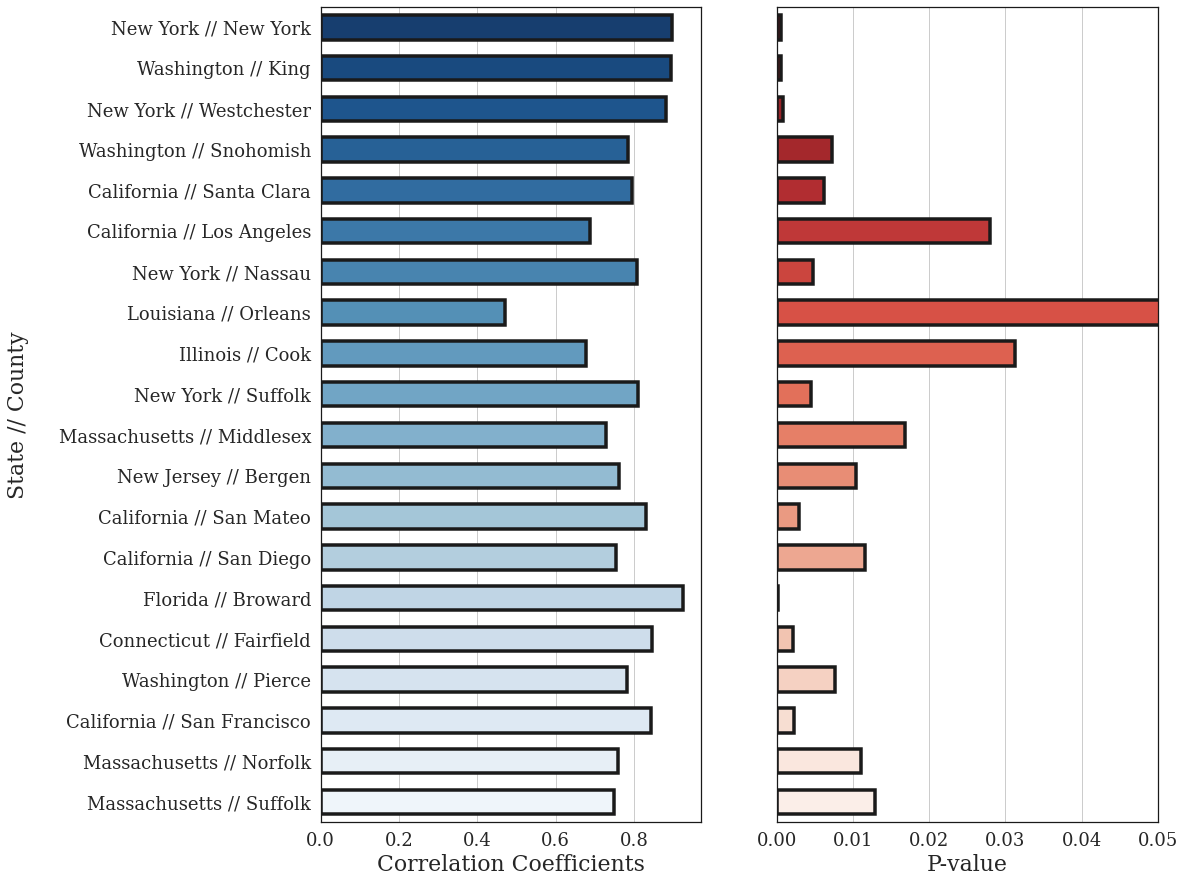

In [364]:
print('Correlation coefficient and p value of Reduction of degree centrality and the weekly new CDC confirmed cases of counties\nRanked by cdc confirmed cases\n')

sns.set(style="whitegrid")
f, (ax1, ax2) = plt.subplots(1,2,figsize=(15,15))
sns.set_color_codes("pastel")

kwargs = {'alpha':None, 'linestyle':'-',  'linewidth':3.5, 'edgecolor':'k'}
ax1 = sns.barplot(x="Pearson_Corr",y="State // County", data=corr_dgre_cdc_rank_df[:20], 
                 palette="Blues_r", ax = ax1,**kwargs)

for bar in ax1.patches:
    y = bar.get_y()
    width = bar.get_height()
    centre = y + width/2.
    bar.set_y(centre-0.6/2)
    bar.set_height(0.6)

ax1.set_yticklabels(pval_dgre_cdc_rank_df[0:20]['State // County'].values,fontname='serif', size=18)
ax1.set_xticklabels(['0.0','0.2','0.4','0.6','0.8','1.0'],fontname='serif', size=18)

ax1.set_xlabel("Correlation Coefficients", fontname="serif", fontsize=22)
ax1.set_ylabel("State // County\n", fontname="serif", fontsize=22)


ax2 = sns.barplot(x="p-value",y="State // County", data=pval_dgre_cdc_rank_df[:20],
                  palette="Reds_r", ax=ax2, **kwargs)

for bar in ax2.patches:
    y = bar.get_y()
    width = bar.get_height()
    centre = y + width/2.
    bar.set_y(centre-0.6/2)
    bar.set_height(0.6)
    
# ax2.set_yticklabels(pval_dgre_cdc_rank_df[0:20]['State // County'].values,fontname='serif', size=18)

ax2.set_yticklabels([' ' for i in range(20)],fontname='serif', size=18)
ax2.set_xticklabels(['0.00','0.01','0.02','0.03','0.04','0.05'],fontname='serif', size=18)

ax2.set_xlabel("P-value", fontname="serif", fontsize=22)
ax2.set_ylabel(" ", fontname="serif", fontsize=22)
ax2.set_xlim(0,0.05)

ax1.spines["top"].set_color('k')
ax1.spines["left"].set_color('k')
ax1.spines["right"].set_color('k')
ax1.spines["bottom"].set_color('k')

ax2.spines["top"].set_color('k')
ax2.spines["left"].set_color('k')
ax2.spines["right"].set_color('k')
ax2.spines["bottom"].set_color('k')



Correlation coefficient and p value distribution of Reduction of degree centrality and CDC new confirmed data
 


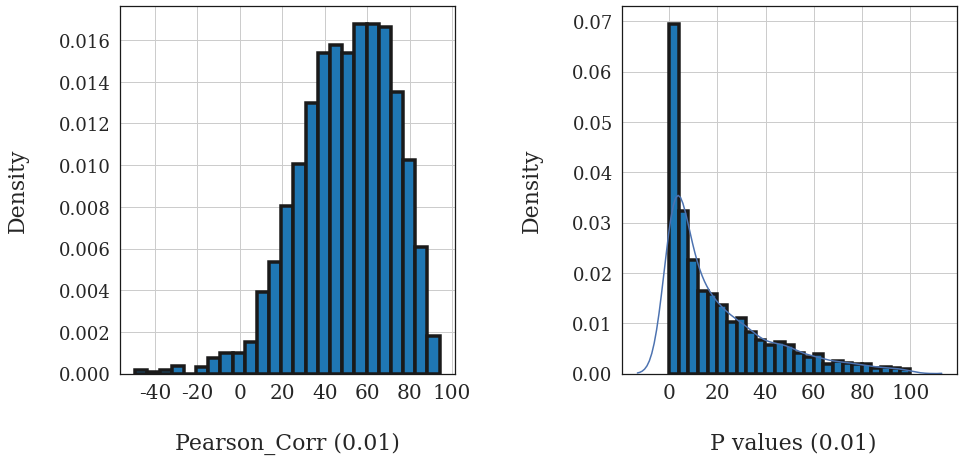

In [365]:
# coefficient distribution

print('Correlation coefficient and p value distribution of Reduction of degree centrality and CDC new confirmed data\n ')

fig, (ax1, ax2) = plt.subplots(1,2,figsize=(15,6))
plt.subplots_adjust(wspace=0.5, hspace=0.3,
                    left=0.125, right=0.9,
                    top=0.95,    bottom=0.1)

data = list(corr_dic_dgre.values())
data = [i*100 for i in data]

hist_kws = {'edgecolor':"k", 'linewidth':2}
sns.distplot(data,kde=False, norm_hist=True,bins=25,
                 hist_kws=dict(color='tab:blue', edgecolor="k",alpha=None,align='mid', linewidth=3.5), ax=ax1)#, palette=sns.color_palette("coolwarm", 7) )

ax1.set_ylabel('Probability Density', fontname="serif", fontsize=22)
ax1.set_xlabel('Pearson_Corr', fontname="serif", fontsize=22)


ax1.set_xlabel(" \nPearson_Corr (0.01)", fontname="serif", fontsize=22)
ax1.set_ylabel("Density\n ", fontname="serif", fontsize=22)


y_axis_list = ['0.000','0.002','0.004','0.006','0.008','0.010','0.012','0.014','0.016']
ax1.set_yticklabels(y_axis_list,fontname='serif', size=18)
ax1.set_xticklabels(['-60','-40','-20','0','20','40','60','80','100'],fontname='serif', size=20)

ax1.spines["top"].set_color('k')
ax1.spines["left"].set_color('k')
ax1.spines["right"].set_color('k')
ax1.spines["bottom"].set_color('k')

data = list(pval_dgre.values())
data = [i*100 for i in data]
hist_kws = {'edgecolor':"k", 'linewidth':2}
sns.distplot(data,kde=True, norm_hist=True,bins=25,
                   hist_kws=dict(color='tab:blue', edgecolor="k",alpha=None,align='mid', linewidth=3.5), ax=ax2)


ax2.set_xlabel(" \n P values (0.01)", fontname="serif", fontsize=22)
ax2.set_ylabel("Density\n ", fontname="serif", fontsize=22)

y_axis_list = ['0.00','0.01','0.02','0.03','0.04','0.05','0.06','0.07']
ax2.set_yticklabels(y_axis_list,fontname='serif', size=18)
ax2.set_xticklabels(['-10','0','20','40','60','80','100'],fontname='serif', size=20)

ax2.spines["top"].set_color('k')
ax2.spines["left"].set_color('k')
ax2.spines["right"].set_color('k')
ax2.spines["bottom"].set_color('k')






# plt.savefig('distribution_coefficientOfReductionDegreeCentrality.pdf', bbox_inches='tight') 

## Analysis of Degree centrality and Reproduction rate

In [366]:
dgre_counties = list(dgre_vector.polygon1_id.values)
# cdc_counties = list(confirmed_vector_diff_stdnorm.polygon1_id.values)
r0_counties = list(r0_fit_replace_df.polygon1_id.values)
cdc_counties = list(cdc_ranking.values)
corr_dic_dgreR0 = {}
pval_dgreR0 = {}
r0_orgn_temp = r0_orgn.fillna(0)
t_len = len(time_cols)
for county in dgre_counties:
    if county in r0_counties:
        temp_dgre = dgre_vector[dgre_vector.polygon1_id==county][time_cols].T.set_axis([county], axis=1).copy()
        
        temp_r0 = r0_fit_replace_df[r0_fit_replace_df.polygon1_id==county][time_cols].T.set_axis(['r0'],axis=1).copy()

        w_len = np.argmax(temp_r0.values)
        
        if w_len < 9:
            corr_dic_dgreR0[county] , pval_dgreR0[county] = stats.pearsonr(temp_dgre[int(county)].values[:(t_len-w_len)], temp_r0['r0'].values[w_len:])
#         pair = temp_dgre.join(temp_cdc)
#         pair = pair.set_axis([county, 'CDC'],axis=1)
#         corr_dic_dgre[county] = pair.corr().iloc[0,1]
corr_dic_dgreR0 = {k: v for k, v in corr_dic_dgreR0.items() if v > 0 or v < 0 }
pva_dgreR0 = {k: v for k, v in pval_dgreR0.items() if v > 0 or v < 0 }

# ranking based on absolute corr values
corr_dgreR0_rank_absolute = {k: v for i, (k, v) in enumerate(sorted(corr_dic_dgreR0.items(), key=lambda item: abs(item[1]), reverse=True))}
corr_dgreR0_rank_absolute_df = pd.DataFrame(corr_dgreR0_rank_absolute.values(), index=corr_dgreR0_rank_absolute.keys()).reset_index().rename(columns={'index': 'polygon1_id', 0: 'Pearson_Corr'})
pairs_id_s_c_t = pairs_id_s_c_t.rename(columns={'name_stack_1': 'State // County'})
corr_dgreR0_rank_absolute_df  = corr_dgreR0_rank_absolute_df.merge(pairs_id_s_c_t[['polygon1_id','State // County']], how='inner', on="polygon1_id")
corr_dgreR0_rank_absolute_df = corr_dgreR0_rank_absolute_df.merge(pop_id, how='inner', on="polygon1_id")
corr_dgreR0_rank_absolute_df = corr_dgreR0_rank_absolute_df.drop_duplicates()


# ranking based on positive corr values
corr_dgreR0_rank_positive = {k: v for i, (k, v) in enumerate(sorted(corr_dic_dgreR0.items(), key=lambda item: item[1], reverse=True))}
corr_dgreR0_rank_positive_df = pd.DataFrame(corr_dgreR0_rank_positive.values(), index=corr_dgreR0_rank_positive.keys()).reset_index().rename(columns={'index': 'polygon1_id', 0: 'Pearson_Corr'})
pairs_id_s_c_t = pairs_id_s_c_t.rename(columns={'name_stack_1': 'State // County'})
corr_dgreR0_rank_positive_df  = corr_dgreR0_rank_positive_df.merge(pairs_id_s_c_t[['polygon1_id','State // County']], how='inner', on="polygon1_id")
corr_dgreR0_rank_positive_df = corr_dgreR0_rank_positive_df.merge(pop_id, how='inner', on="polygon1_id")
corr_dgreR0_rank_positive_df = corr_dgreR0_rank_positive_df.drop_duplicates()

# ranking based on negative corr values
corr_dgreR0_rank_negative = {k: v for i, (k, v) in enumerate(sorted(corr_dic_dgreR0.items(), key=lambda item: -(item[1]), reverse=True))}
corr_dgreR0_rank_negative_df = pd.DataFrame(corr_dgreR0_rank_negative.values(), index=corr_dgreR0_rank_negative.keys()).reset_index().rename(columns={'index': 'polygon1_id', 0: 'Pearson_Corr'})
pairs_id_s_c_t = pairs_id_s_c_t.rename(columns={'name_stack_1': 'State // County'})
corr_dgreR0_rank_negative_df  = corr_dgreR0_rank_negative_df.merge(pairs_id_s_c_t[['polygon1_id','State // County']], how='inner', on="polygon1_id")
corr_dgreR0_rank_negative_df = corr_dgreR0_rank_negative_df.merge(pop_id, how='inner', on="polygon1_id")
corr_dgreR0_rank_negative_df = corr_dgreR0_rank_negative_df.drop_duplicates()


# ranking based on cdc_ranking
corr_dgreR0_cdc_rank = {}
pval_dgreR0_cdc_rank = {}
for i, idx in enumerate(cdc_counties):
#     if i<20:
    
    if idx in corr_dic_dgreR0.keys():
        corr_dgreR0_cdc_rank[idx] = corr_dic_dgreR0[idx]
        pval_dgreR0_cdc_rank[idx] = pval_dgreR0[idx]

corr_dgreR0_cdc_rank_df = pd.DataFrame(corr_dgreR0_cdc_rank.values(), index=corr_dgreR0_cdc_rank.keys()).reset_index().rename(columns={'index': 'polygon1_id', 0: 'Pearson_Corr'})
pairs_id_s_c_t = pairs_id_s_c_t.rename(columns={'name_stack_1': 'State // County'})
corr_dgreR0_cdc_rank_df  = corr_dgreR0_cdc_rank_df.merge(pairs_id_s_c_t[['polygon1_id','State // County']], how='inner', on="polygon1_id")

pval_dgreR0_cdc_rank_df = pd.DataFrame(pval_dgreR0_cdc_rank.values(), index=pval_dgreR0_cdc_rank.keys()).reset_index().rename(columns={'index': 'polygon1_id', 0: 'p-value'})
# pairs_id_s_c_t = pairs_id_s_c_t.rename(columns={'name_stack_1': 'State // County'})
pval_dgreR0_cdc_rank_df  = pval_dgreR0_cdc_rank_df.merge(pairs_id_s_c_t[['polygon1_id','State // County']], how='inner', on="polygon1_id")

/home/ubuntu/anaconda3/envs/shlee/lib/python3.6/site-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.

/home/ubuntu/anaconda3/envs/shlee/lib/python3.6/site-packages/scipy/stats/stats.py:3538: PearsonRNearConstantInputWarning:

An input array is nearly constant; the computed correlation coefficent may be inaccurate.



Correlation coefficient and p value of the degree centrality and reproduction rate
Ranked by cdc confirmed cases



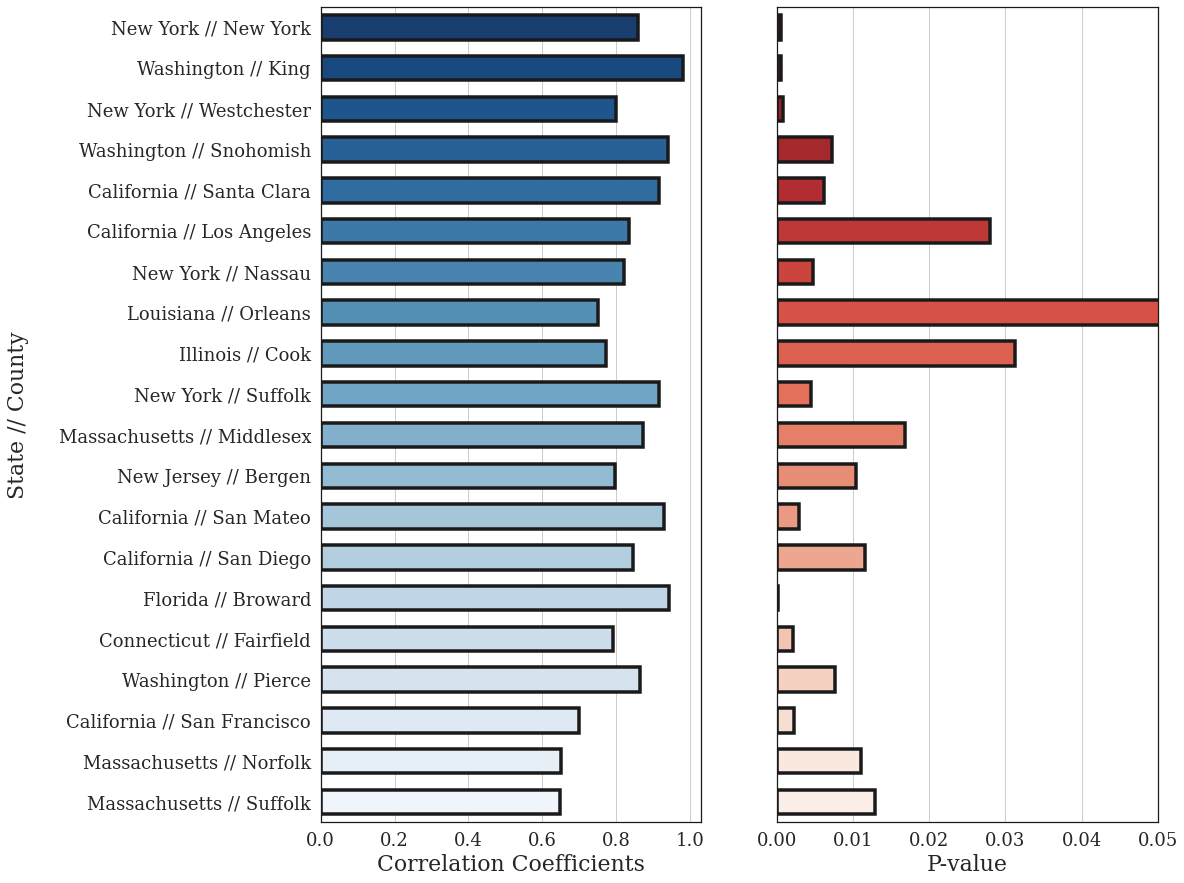

In [367]:
print('Correlation coefficient and p value of the degree centrality and reproduction rate\nRanked by cdc confirmed cases\n')

sns.set(style="whitegrid")
f, (ax1, ax2) = plt.subplots(1,2,figsize=(15,15))
sns.set_color_codes("pastel")

kwargs = {'alpha':None, 'linestyle':'-',  'linewidth':3.5, 'edgecolor':'k'}
ax1 = sns.barplot(x="Pearson_Corr",y="State // County", data=corr_dgreR0_cdc_rank_df[:20], 
                 palette="Blues_r", ax = ax1,**kwargs)

for bar in ax1.patches:
    y = bar.get_y()
    width = bar.get_height()
    centre = y + width/2.
    bar.set_y(centre-0.6/2)
    bar.set_height(0.6)

ax1.set_yticklabels(pval_dgreR0_cdc_rank_df[0:20]['State // County'].values,fontname='serif', size=18)
ax1.set_xticklabels(['0.0','0.2','0.4','0.6','0.8','1.0'],fontname='serif', size=18)

ax1.set_xlabel("Correlation Coefficients", fontname="serif", fontsize=22)
ax1.set_ylabel("State // County\n", fontname="serif", fontsize=22)


ax2 = sns.barplot(x="p-value",y="State // County", data=pval_dgre_cdc_rank_df[:20],
                  palette="Reds_r", ax=ax2, **kwargs)

for bar in ax2.patches:
    y = bar.get_y()
    width = bar.get_height()
    centre = y + width/2.
    bar.set_y(centre-0.6/2)
    bar.set_height(0.6)
    
# ax2.set_yticklabels(pval_dgre_cdc_rank_df[0:20]['State // County'].values,fontname='serif', size=18)

ax2.set_yticklabels([' ' for i in range(20)],fontname='serif', size=18)
ax2.set_xticklabels(['0.00','0.01','0.02','0.03','0.04','0.05'],fontname='serif', size=18)

ax2.set_xlabel("P-value", fontname="serif", fontsize=22)
ax2.set_ylabel(" ", fontname="serif", fontsize=22)
ax2.set_xlim(0,0.05)

ax1.spines["top"].set_color('k')
ax1.spines["left"].set_color('k')
ax1.spines["right"].set_color('k')
ax1.spines["bottom"].set_color('k')

ax2.spines["top"].set_color('k')
ax2.spines["left"].set_color('k')
ax2.spines["right"].set_color('k')
ax2.spines["bottom"].set_color('k')



Correlation coefficient and p value distribution of the degree centrality and reproduction rate
 


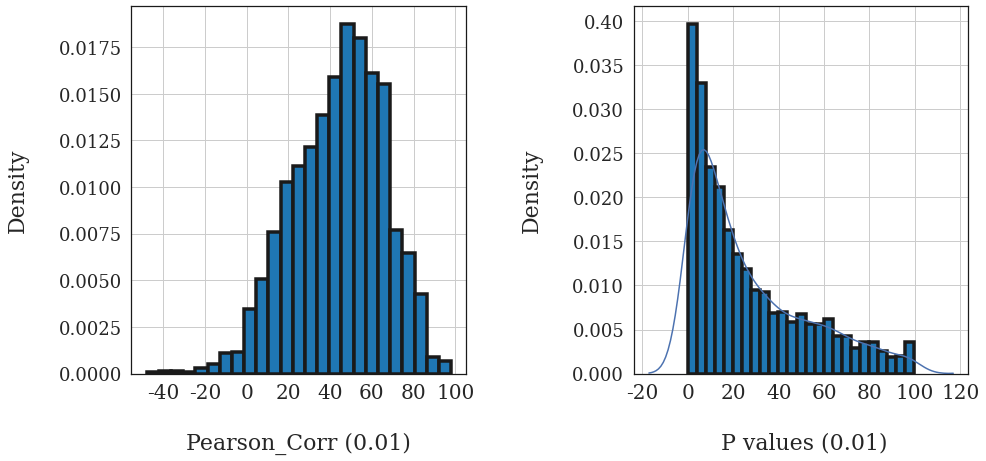

In [368]:
# coefficient distribution

print('Correlation coefficient and p value distribution of the degree centrality and reproduction rate\n ')

fig, (ax1, ax2) = plt.subplots(1,2,figsize=(15,6))
plt.subplots_adjust(wspace=0.5, hspace=0.3,
                    left=0.125, right=0.9,
                    top=0.95,    bottom=0.1)

data = list(corr_dic_dgreR0.values())
data = [i*100 for i in data]

hist_kws = {'edgecolor':"k", 'linewidth':2}
sns.distplot(data,kde=False, norm_hist=True,bins=25,
                 hist_kws=dict(color='tab:blue', edgecolor="k",alpha=None,align='mid', linewidth=3.5), ax=ax1)#, palette=sns.color_palette("coolwarm", 7) )

ax1.set_ylabel('Probability Density', fontname="serif", fontsize=22)
ax1.set_xlabel('Pearson_Corr', fontname="serif", fontsize=22)


ax1.set_xlabel(" \nPearson_Corr (0.01)", fontname="serif", fontsize=22)
ax1.set_ylabel("Density\n ", fontname="serif", fontsize=22)


y_axis_list = ['0.0000','0.0025','0.0050','0.0075','0.0100','0.0125','0.0150','0.0175']
ax1.set_yticklabels(y_axis_list,fontname='serif', size=18)
ax1.set_xticklabels(['-60','-40','-20','0','20','40','60','80','100'],fontname='serif', size=20)

ax1.spines["top"].set_color('k')
ax1.spines["left"].set_color('k')
ax1.spines["right"].set_color('k')
ax1.spines["bottom"].set_color('k')

data = list(pval_dgreR0.values())
data = [i*100 for i in data]
hist_kws = {'edgecolor':"k", 'linewidth':2}
sns.distplot(data,kde=True, norm_hist=True,bins=25,
                   hist_kws=dict(color='tab:blue', edgecolor="k",alpha=None,align='mid', linewidth=3.5), ax=ax2)


ax2.set_xlabel(" \n P values (0.01)", fontname="serif", fontsize=22)
ax2.set_ylabel("Density\n ", fontname="serif", fontsize=22)

y_axis_list = ['0.000','0.005','0.010','0.015','0.020','0.025','0.030','0.035','0.40']
ax2.set_yticklabels(y_axis_list,fontname='serif', size=18)
ax2.set_xticklabels(['-30','-20','0','20','40','60','80','100','120'],fontname='serif', size=20)

ax2.spines["top"].set_color('k')
ax2.spines["left"].set_color('k')
ax2.spines["right"].set_color('k')
ax2.spines["bottom"].set_color('k')







In [369]:
def toPvalue(dic):
    new_dic = {}
    for key, val in dic.items():
        if val <=0.001:
            new_dic[key] = 1
        elif (val > 0.001) and (val <= 0.05):
            new_dic[key] = 2
        else:
            new_dic[key] = 3
    return new_dic

# p_lv_btwn = toPvalue(p_btwn)
p_lv_dgre = toPvalue(pval_dgre)


# p_lv_btwn = pd.Series(p_lv_btwn)
p_lv_dgre = pd.Series(p_lv_dgre)

pnt_plot = confirmed_1_vector[['polygon1_id','2020-03-31']].merge(p_lv_dgre.reset_index().rename(columns={'index':'polygon1_id',0:'p_level'}), on='polygon1_id')
pnt_plot

polygon1_id  2020-03-31  p_level
0         1214815           0        3
1         1214941           0        3
2         1195746           0        3
3         1195962           0        3
4         1414817           0        3
...           ...         ...      ...
2767      1433611         314        2
2768      1433597        2357        2
2769      1433635          91        2
2770      1433591          27        3
2771      1433615         377        2

[2772 rows x 3 columns]

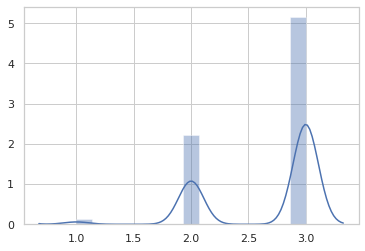

In [370]:
def make_patch_spines_invisible(ax):
    ax.set_frame_on(True)
    ax.patch.set_visible(False)
    for sp in ax.spines.values():
        sp.set_visible(False)

def align_yaxis(ax1, v1, ax2, v2):
    """adjust ax2 ylimit so that v2 in ax2 is aligned to v1 in ax1"""
    _, y1 = ax1.transData.transform((0, v1))
    _, y2 = ax2.transData.transform((0, v2))
    inv = ax2.transData.inverted()
    _, dy = inv.transform((0, 0)) - inv.transform((0, y1-y2))
    miny, maxy = ax2.get_ylim()
    ax2.set_ylim(miny+dy, maxy+dy)
    
bar_data = [h.get_height() for h in sns.distplot(pnt_plot[['p_level']]).patches]
bar_data = np.array(bar_data)
bar_data = bar_data[bar_data!=0]
bar_dict = {}
for i in range(0,3,1):
    bar_dict[i+1] = bar_data[i]
bar_df = pd.DataFrame.from_records([bar_dict])

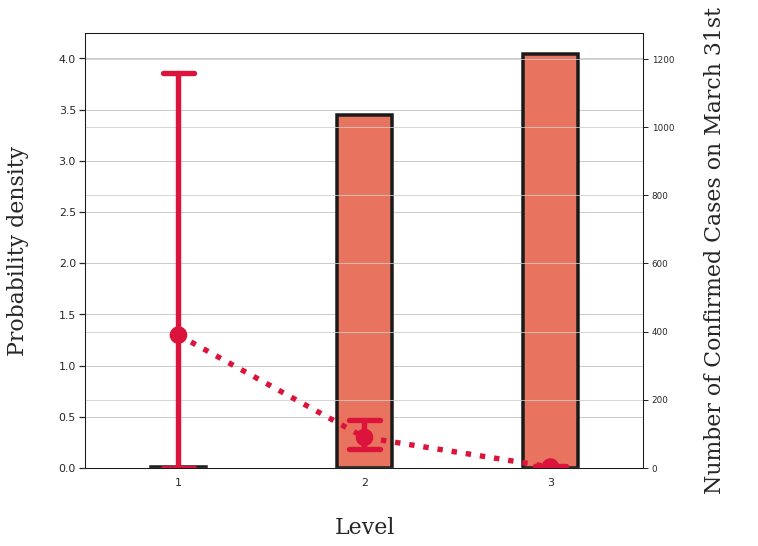

In [379]:
# sns.set(style="whitegrid")
# fig = plt.figure(figsize=(10,8))
# ax = fig.add_subplot(111)
# sns.set_color_codes("pastel")
# ax = sns.distplot(p_lv_dgre-2,kde=False, norm_hist=True, bins=15)#, hist_kws={'align':'mid'})


# ax2 = ax.twinx()
# ax2 = sns.pointplot('p_level','2020-03-31',data=pnt_plot,capsize=.1)



# ax.set_yticklabels(['0','1','2','3','4','5','6','7','8'],fontname='serif', size=18)
# ax.set_xticklabels(['p<0.05','p>0.05'],fontname='serif', size=18)
# ax2.set_yticklabels(['-1','0','1','2','3','4','5','6'],fontname='serif', size=18)


# ax.set_ylabel("Density\n", fontname="serif", fontsize=22)
# ax2.set_ylabel("\nNumber of Confirmed Cases on March 17th\n", fontname="serif", fontsize=22)
# ax.set_xlabel(" \nLevel", fontname="serif", fontsize=22)

# plt.title('Correlation p-value distribution\nbetween the flipped degree centrality and the lag adjusted CDC new confirmed data\nand the numberof confirmed cases\n',fontname='serif', fontsize=22)
# # plt.savefig('Distribution_with_errorbars_p_val.pdf', bbox_inches='tight')


sns.set(style="whitegrid")
fig = plt.figure(figsize=(10,8))
ax1 = fig.add_subplot(111)

paper_rc = {'lines.linewidth': 3, 'lines.markersize': 3}                  
sns.set_context("paper", rc = paper_rc)    

sns.set_color_codes("pastel")
# ax1 = sns.distplot(p_lv_dgre-1,kde=False, norm_hist=True, bins=15)#, hist_kws={'align':'mid'})

sns.barplot(data = bar_df, color='tomato', edgecolor='k', linewidth=3.5,ax=ax1)


ax2 = ax1.twinx()
sns.pointplot('p_level','2020-03-31',data=pnt_plot, linewidth=6, linestyles=':'
              ,capsize=.17,color='crimson' ,ax=ax2)

align_yaxis(ax1, 0, ax2, 0)

# ax1.set_yticklabels(['0.0','0.5','1.0','1.5','2.0','2.5','3.0','3.5','4.0'],fontname='serif', size=18)
# ax1.set_xticklabels(['p<0.001','p<0.01','p<0.05'],fontname='serif', size=18)
# ax2.set_yticklabels(['0','200','400','600','800','1000','1200','1400','1600'],fontname='serif', size=18)


ax1.set_ylabel("Probability density\n", fontname="serif", fontsize=22)
ax2.set_ylabel("\nNumber of Confirmed Cases on March 31st\n", fontname="serif", fontsize=22)
ax1.set_xlabel(" \nLevel", fontname="serif", fontsize=22)


def change_width(ax, new_value) :
    for patch in ax.patches :
        current_width = patch.get_width()
        diff = current_width - new_value

        # we change the bar width
        patch.set_width(new_value)

        # we recenter the bar
        patch.set_x(patch.get_x() + diff * .5)

change_width(ax1, .3)

# ax1.set_ylim(0,4)
# # ax2.set_ylim(0,1800000)
# ax2.set_ylim(0,1600)


ax2.spines["top"].set_color('k')
ax2.spines["left"].set_color('k')
ax2.spines["right"].set_color('k')
ax2.spines["bottom"].set_color('k')

# plt.title('Correlation p-value distribution\nbetween degree centrality and the lag adjusted R0 (fit)\nand the numberof confirmed cases\n',fontname='serif', fontsize=22)
# plt.savefig('distribution_pval_DegreeCentrality_R0_fit_CDC0331.pdf', bbox_inches='tight') 

# Time Lagged Cross-Correlation Analysis <a class="anchor" id="fifth-bullet"></a>

## Analysis of Reduction of degree centrality and CDC first-order growth rate

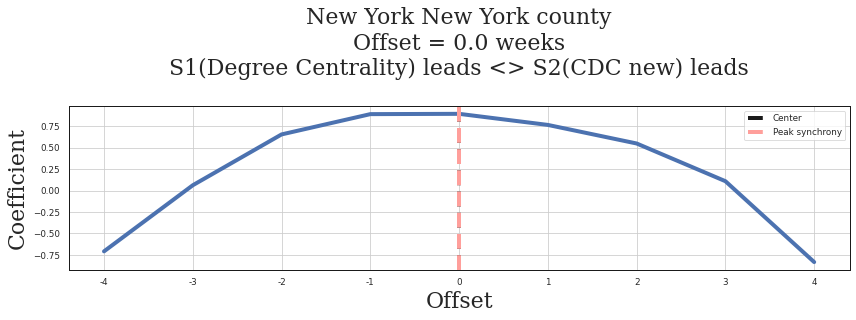

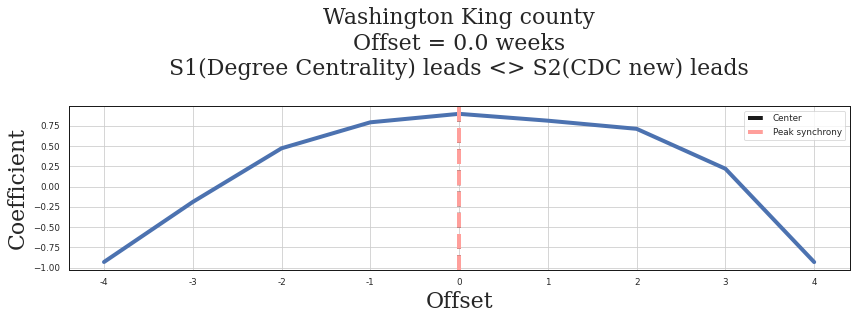

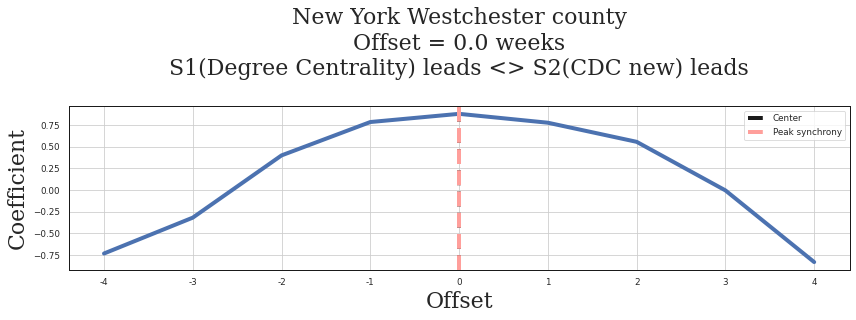

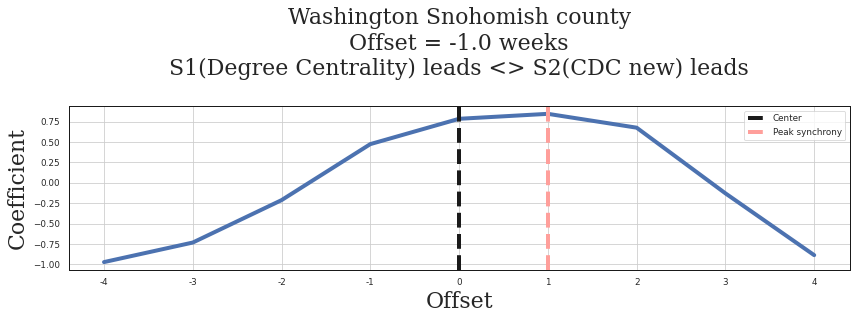

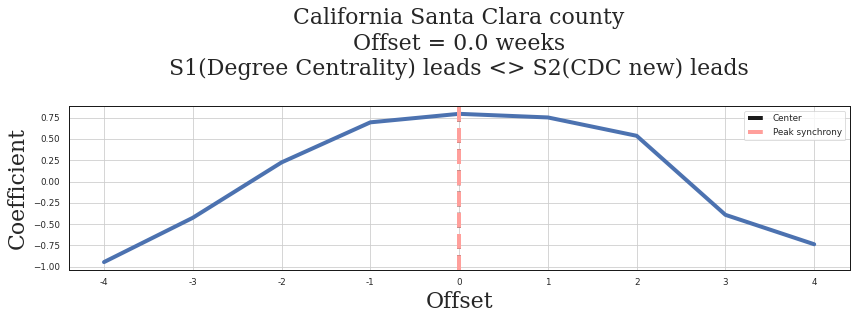

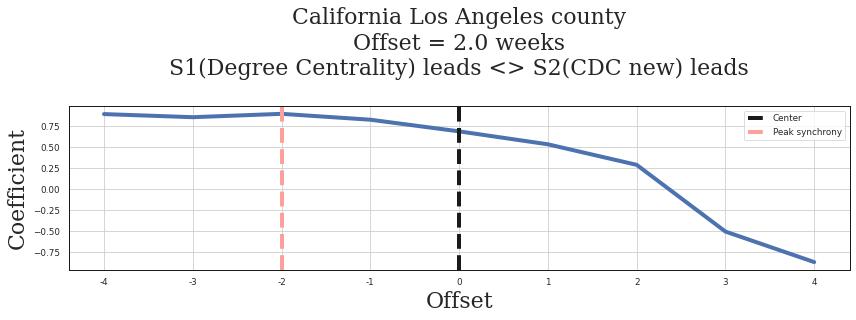

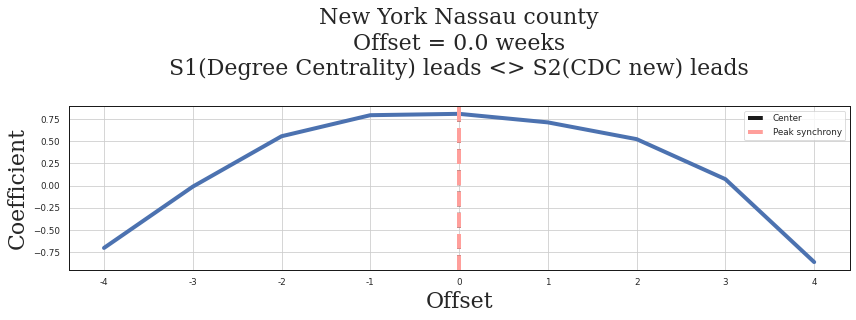

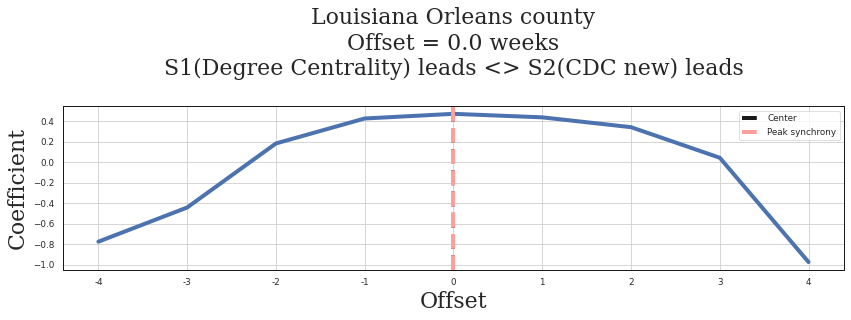

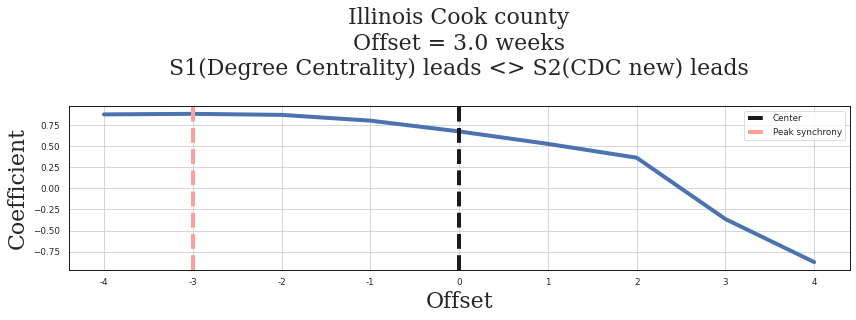

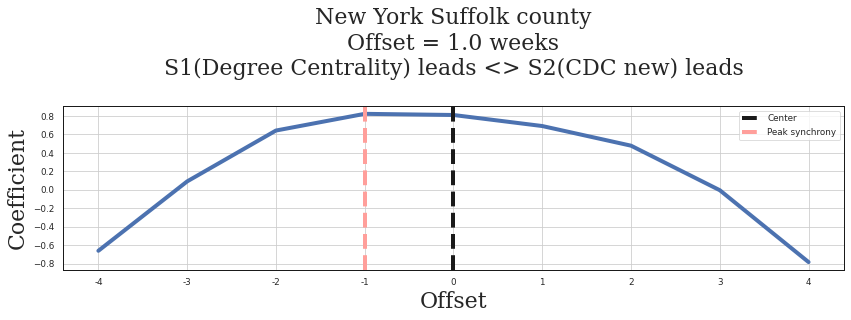

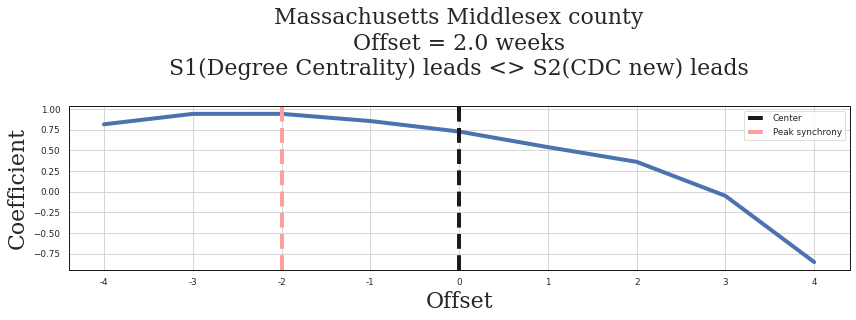

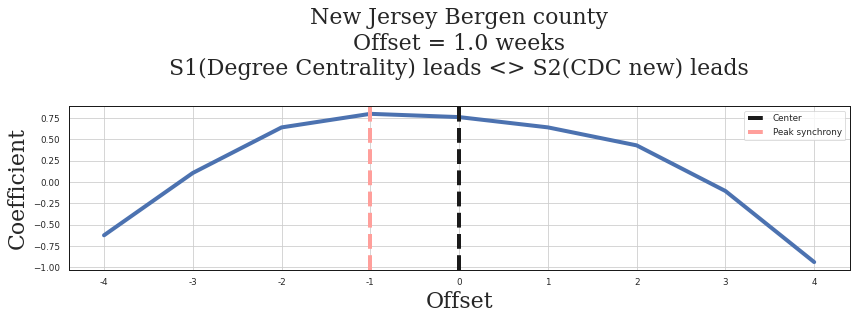

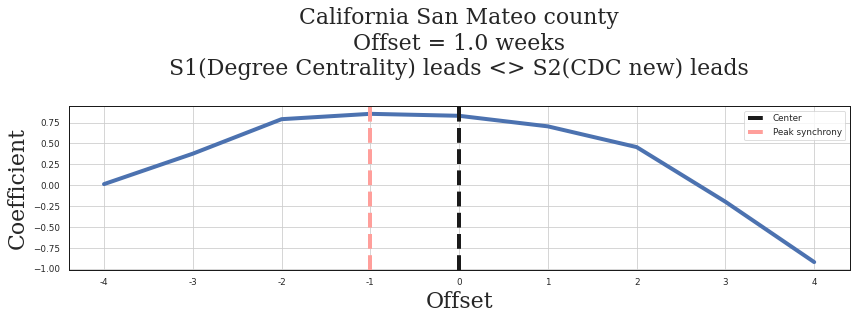

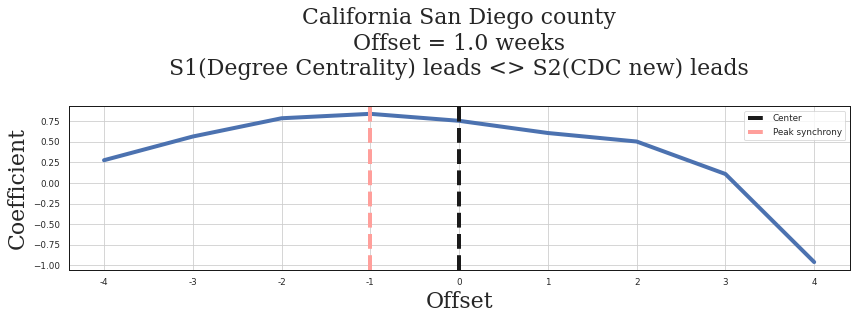

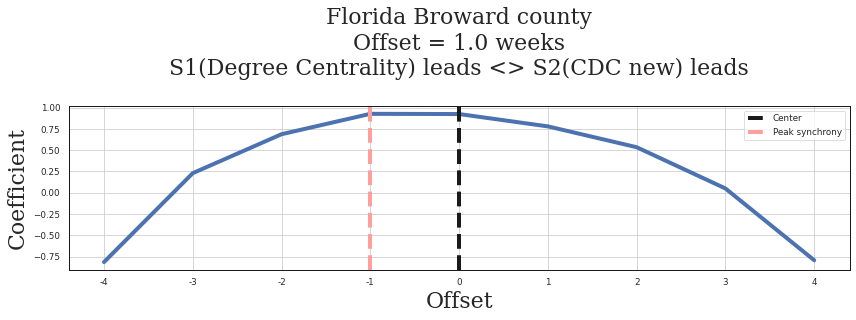

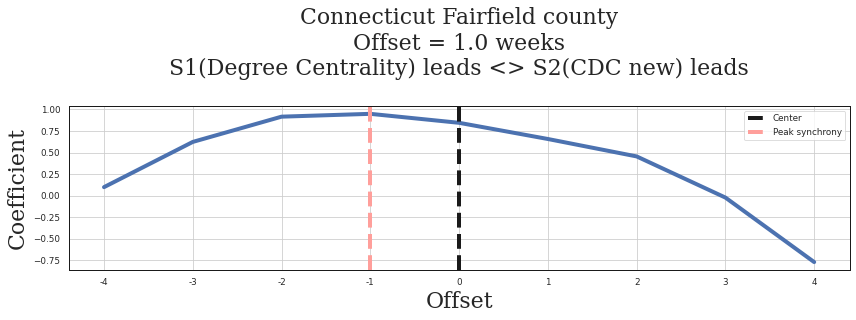

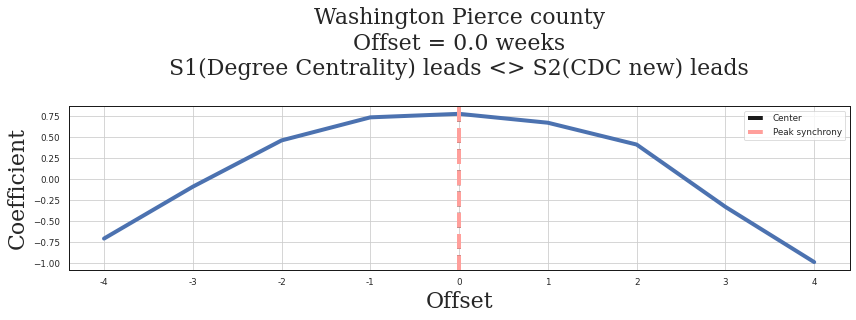

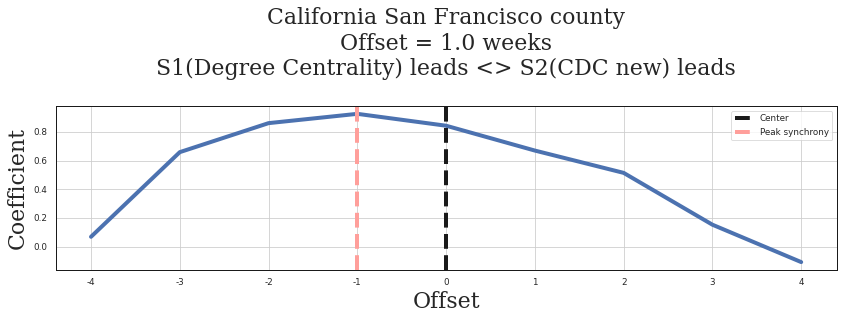

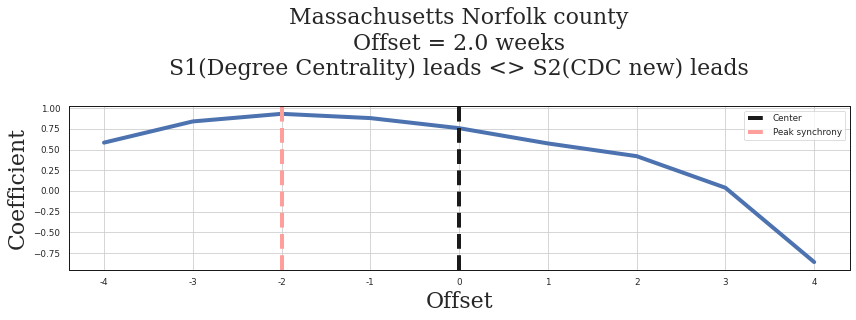

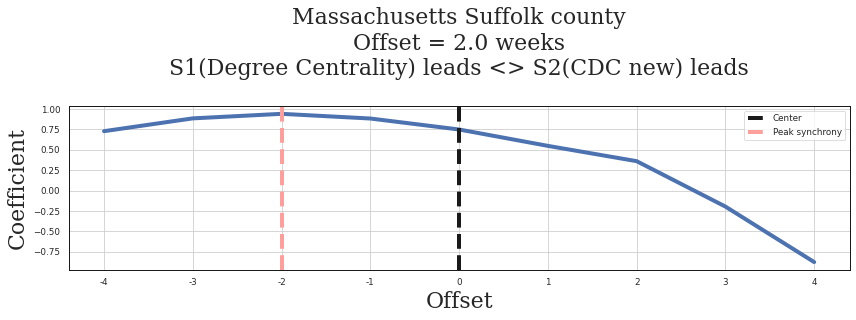

In [380]:
def crosscorr(datax, datay, lag=0, wrap=False):
    """ Lag-N cross correlation. 
    Shifted data filled with NaNs 
    
    Parameters
    ----------
    lag : int, default 0
    datax, datay : pandas.Series objects of equal length
    Returns
    ----------
    crosscorr : float
    """
    if wrap:
        shiftedy = datay.shift(lag)
        shiftedy.iloc[:lag] = datay.iloc[-lag:].values
        return datax.corr(shiftedy)
    else: 
        return datax.corr(datay.shift(lag))
    
seconds = 1
fps = 4
offset_dict = {}
adj_dgre_coef = {}
adg_dgre_pval = {}
i=0

        
for ids in cdc_counties:
    if ids in dgre_counties:
        
        d1 = dgre_reduction_vector[dgre_reduction_vector.polygon1_id==ids].drop(columns='polygon1_id').iloc[0].copy()
        d2 = confirmed_1_vector[confirmed_1_vector.polygon1_id==ids].drop(columns='polygon1_id').iloc[0].copy()

        rs = [crosscorr(d1,d2, lag) for lag in range(-int(seconds*fps),int(seconds*fps+1))]
        t_len = len(rs)
        if (np.isnan(np.array(rs)).sum() > 0) and (np.isnan(np.array(rs)).sum() < len(rs)):
            argmx = np.nanargmax(rs)
            offset = np.ceil(len(rs)/2)-1-argmx
            best_lag = -int(seconds*fps) + argmx
        else:
            argmx = np.argmax(rs)
            offset = np.ceil(len(rs)/2)-1-argmx
            best_lag = -int(seconds*fps) + argmx
                
        offset_dict[ids] = offset
        if best_lag < 0:
            coef_ = d1.corr(d2.shift(best_lag))
            pval_ = stats.ttest_ind(d1[:(t_len+best_lag)], d2.shift(best_lag)[:(t_len+best_lag)],equal_var = False)[1]
        elif best_lag > 0:
            coef_ = d1.corr(d2.shift(best_lag))
            pval_ = stats.ttest_ind(d1[best_lag:], d2.shift(best_lag)[best_lag:],equal_var = False)[1]
        else:
            coef_ = d1.corr(d2)
            pval_ = stats.ttest_ind(d1, d2, equal_var = False)[1]
            
#         if coef_ > 0.01 :
        adj_dgre_coef[ids] = coef_
        adg_dgre_pval[ids] = pval_       

#             print('d1')
#             print(d1[:best_lag].values)
#             print('d2')
#             print(d2.shift(best_lag)[:best_lag].values)
        if i <20:
            countyName = pairs_id_s_c_t[pairs_id_s_c_t.polygon1_id==ids]['State // County'].values[0].split(' // ')
            countyName = countyName[0]+' '+countyName[1]
            f,ax=plt.subplots(figsize=(14,3))
            ax.plot(rs, linewidth=4)
            ax.axvline(np.ceil(len(rs)/2)-1,color='k',linestyle='--',label='Center', linewidth=4)
            ax.axvline(argmx, color='r',linestyle='--',label='Peak synchrony', linewidth=4)
            ax.set_title(f'{countyName} county\nOffset = {offset} weeks\nS1(Degree Centrality) leads <> S2(CDC new) leads\n ',fontname="serif", fontsize=22)
            ax.set_ylabel('Coefficient',fontname="serif", fontsize=22)
            ax.set_xlabel('Offset',fontname="serif", fontsize=22)
    #             ax.set(title=f'Offset = {offset} frames\nS1 leads <> S2 leads',ylim=[.1,.31],xlim=[0,301], xlabel='Offset',ylabel='Pearson r')
            ax.set_xticks([0, 1, 2, 3, 4, 5, 6, 7, 8])
            ax.set_xticklabels([-4,-3,-2,-1,0,1,2,3,4]);
            
            
            ax.spines["top"].set_color('k')
            ax.spines["left"].set_color('k')
            ax.spines["right"].set_color('k')
            ax.spines["bottom"].set_color('k')
            plt.legend()
    
#             plt.savefig(f'DegreeCenReduction_and_CDCnew_plot_{countyName}.pdf', bbox_inches='tight') 
        i+=1

In [381]:
offset_dist = pd.DataFrame.from_records([offset_dict]).T

pnt_offset_plot = confirmed_1_vector[['polygon1_id','2020-03-31']].merge(offset_dist.reset_index().rename(columns={'index':'polygon1_id',0:'offset'}),on='polygon1_id')

offset_mean = offset_dist.mean().values[0]
offset_median = offset_dist.median().values[0]
offset_var = offset_dist.var().values[0]

def CI_printout(series, interval = 0.95, method = 't'):
    mean_val = series.mean()
    n = series.count()
    stdev = series.std()
    if method == 't':
        test_stat = stats.t.ppf((interval + 1)/2, n)
    elif method == 'z':
        test_stat = stats.norm.ppf((interval + 1)/2)
    lower_bound = mean_val - test_stat * stdev / math.sqrt(n)
    upper_bound = mean_val + test_stat * stdev / math.sqrt(n)

    return lower_bound.values[0], upper_bound.values[0]
lower_bound, upper_bound = CI_printout(offset_dist)

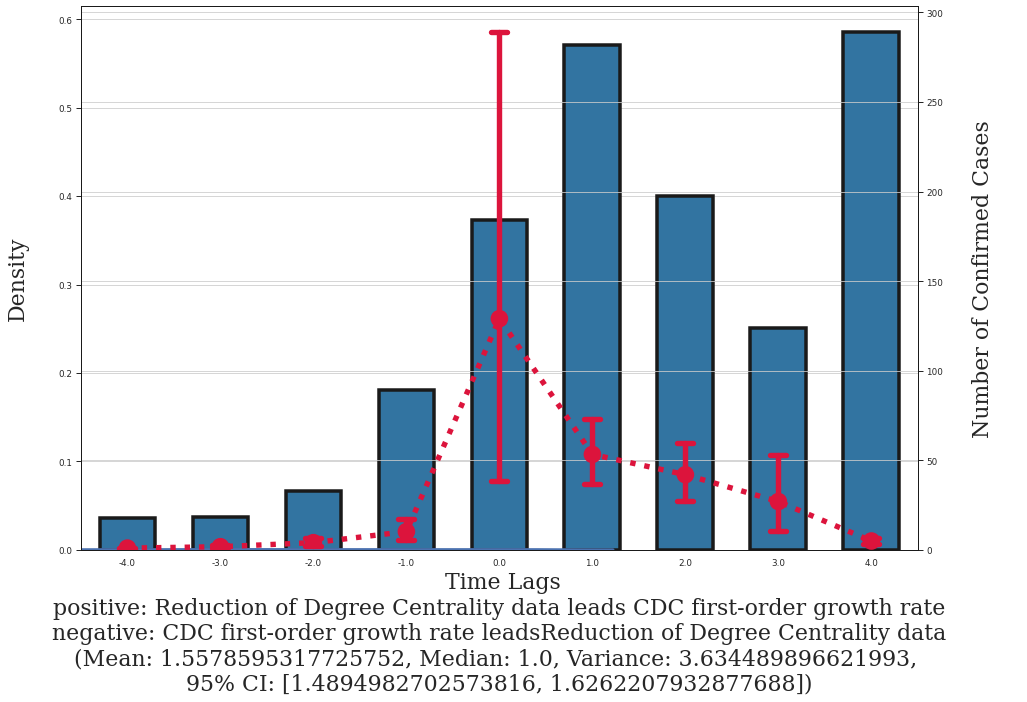

In [386]:
def make_patch_spines_invisible(ax):
    ax.set_frame_on(True)
    ax.patch.set_visible(False)
    for sp in ax.spines.values():
        sp.set_visible(False)

def align_yaxis(ax1, v1, ax2, v2):
    """adjust ax2 ylimit so that v2 in ax2 is aligned to v1 in ax1"""
    _, y1 = ax1.transData.transform((0, v1))
    _, y2 = ax2.transData.transform((0, v2))
    inv = ax2.transData.inverted()
    _, dy = inv.transform((0, 0)) - inv.transform((0, y1-y2))
    miny, maxy = ax2.get_ylim()
    ax2.set_ylim(miny+dy, maxy+dy)
    

sns.set(style="whitegrid")
paper_rc = {'lines.linewidth': 3, 'lines.markersize': 3}                  
sns.set_context("paper", rc = paper_rc)    

fig, ax1 = plt.subplots(figsize=(15,10))
ax2 = ax1.twinx()

bar_data = [h.get_height() for h in sns.distplot(offset_dist).patches]
bar_data = np.array(bar_data)
bar_data = bar_data[bar_data!=0]
bar_dict = {}
for i in range(0,9,1):
    bar_dict[i-4] = bar_data[i]
bar_df = pd.DataFrame.from_records([bar_dict])



sns.barplot(data = bar_df,  color='tab:blue', edgecolor='k', linewidth=3.5,ax=ax1)

sns.pointplot('offset','2020-03-31',data=pnt_offset_plot, linewidth=6, linestyles=':',capsize=.17,color='crimson' ,ax=ax2)

align_yaxis(ax1, 0, ax2, 0)

# y_axis_list = ['0.0','0.1','0.2','0.3','0.4','0.5','0.6','0.7','0.8']
# ax.set_yticklabels(y_axis_list,fontname='serif', size=18)
# ax.set_xticklabels(['-3.0','-2.0','-1.0','0.0','1.0','2.0','3.0','4.0','5.0'],fontname='serif', size=18)
# ax2.set_yticklabels(['-1','0','1','2','3','4','5','6'],fontname='serif', size=18)

ax1.set_xlabel(f' Time Lags\npositive: Reduction of Degree Centrality data leads CDC first-order growth rate\nnegative: CDC first-order growth rate leadsReduction of Degree Centrality data\n(Mean: {offset_mean}, Median: {offset_median}, Variance: {offset_var}, \n95% CI: [{lower_bound}, {upper_bound}])', fontname="serif", fontsize=22)
ax1.set_ylabel("Density\n ", fontname="serif", fontsize=22)
ax2.set_ylabel("\nNumber of Confirmed Cases\n", fontname="serif", fontsize=22)

# ax1.yaxis.label.set_color('tab:blue')
# # ax2.yaxis.label.set_color('tab:orange')
# ax2.yaxis.label.set_color('crimson')

# ax1.set_ylim(0,1.4)
# # ax2.set_ylim(0,1800000)
# ax2.set_ylim(0,1600)

ax2.spines["top"].set_color('k')
ax2.spines["left"].set_color('k')
ax2.spines["right"].set_color('k')
ax2.spines["bottom"].set_color('k')

def change_width(ax, new_value) :
    for patch in ax.patches :
        current_width = patch.get_width()
        diff = current_width - new_value

        # we change the bar width
        patch.set_width(new_value)

        # we recenter the bar
        patch.set_x(patch.get_x() + diff * .5)

change_width(ax1, .6)



# plt.title('Offsets of Time Lagged Cross-Correlation\nReduction of Degree Centrality data leads the pattern [offset] weeks earlier than CDC new data\n ',fontname='serif',fontsize=22)





# plt.savefig('distribution_offset_Reduction_DegreeCentrality_and_cdc_pointplot.pdf', bbox_inches='tight') 

In [387]:
def toPvalue(dic):
    new_dic = {}
    for key, val in dic.items():
        if val <=0.001:
            new_dic[key] = 1
        elif (val > 0.001) and (val <= 0.05):
            new_dic[key] = 2
        else:
            new_dic[key] = 3
    return new_dic

# p_lv_btwn = toPvalue(p_btwn)
p_lv_dgre = toPvalue(adg_dgre_pval)


# p_lv_btwn = pd.Series(p_lv_btwn)
p_lv_dgre = pd.Series(p_lv_dgre)
# p_btwn = pd.Series(p_btwn)

In [388]:
def returnPlv(row):
    pval = row['p-value']
    if pval <= 0.001:
        return 1
    elif (pval > 0.001) and (pval<0.05):
        return 2
    else:
        return 3
pval_dgre_cdc_rank_df['p_lv'] = pval_dgre_cdc_rank_df.apply(lambda row: returnPlv(row), axis=1)

pnt_plot = confirmed_1_vector[['polygon1_id','2020-03-31']].merge(p_lv_dgre.reset_index().rename(columns={'index':'polygon1_id',0:'p_level'}), on='polygon1_id')
pnt_plot

polygon1_id  2020-03-31  p_level
0         1214815           0        3
1         1214941           0        3
2         1195746           0        3
3         1195962           0        3
4         1414817           0        3
...           ...         ...      ...
2985      1433611         314        2
2986      1433597        2357        2
2987      1433635          91        2
2988      1433591          27        2
2989      1433615         377        2

[2990 rows x 3 columns]

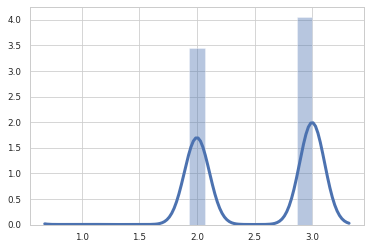

In [389]:
bar_data = [h.get_height() for h in sns.distplot(pnt_plot[['p_level']]).patches]
bar_data = np.array(bar_data)
bar_data = bar_data[bar_data!=0]
bar_dict = {}
for i in range(0,3,1):
    bar_dict[i+1] = bar_data[i]
bar_df = pd.DataFrame.from_records([bar_dict])

Text(0.5, 1.0, 'Correlation p-value distribution\nbetween Reduction of degree centrality and the lag adjusted CDC new confirmed data\nand the numberof confirmed cases\n')

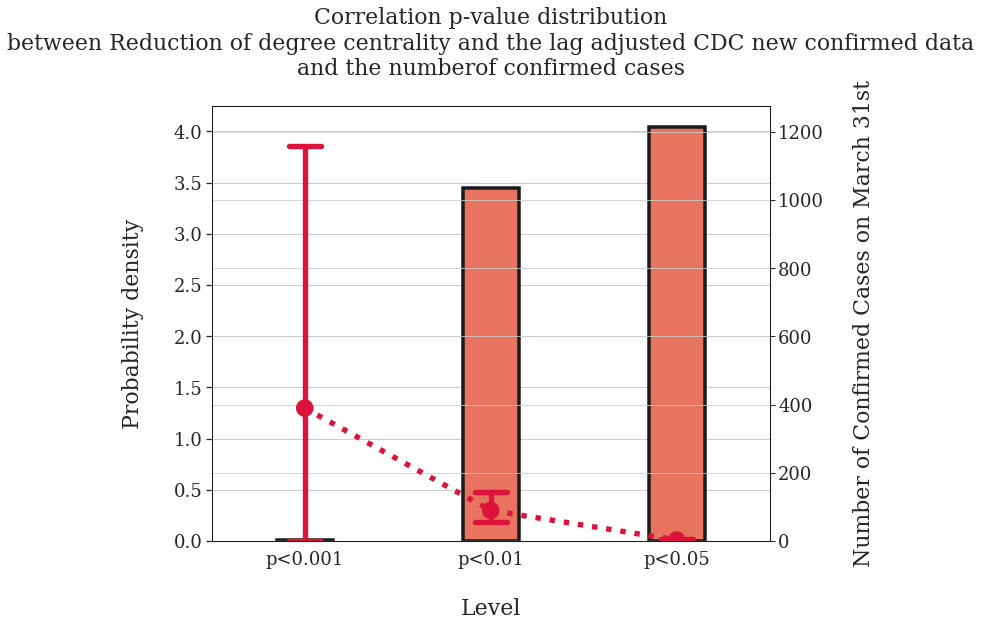

In [390]:
sns.set(style="whitegrid")
fig = plt.figure(figsize=(10,8))
ax1 = fig.add_subplot(111)

paper_rc = {'lines.linewidth': 3, 'lines.markersize': 3}                  
sns.set_context("paper", rc = paper_rc)    

sns.set_color_codes("pastel")
# ax1 = sns.distplot(p_lv_dgre-1,kde=False, norm_hist=True, bins=15)#, hist_kws={'align':'mid'})

sns.barplot(data = bar_df, color='tomato', edgecolor='k', linewidth=3.5,ax=ax1)


ax2 = ax1.twinx()
sns.pointplot('p_level','2020-03-31',data=pnt_plot, linewidth=6, linestyles=':'
              ,capsize=.17,color='crimson' ,ax=ax2)

align_yaxis(ax1, 0, ax2, 0)

ax1.set_yticklabels(['0.0','0.5','1.0','1.5','2.0','2.5','3.0','3.5','4.0'],fontname='serif', size=18)
ax1.set_xticklabels(['p<0.001','p<0.01','p<0.05'],fontname='serif', size=18)
ax2.set_yticklabels(['0','200','400','600','800','1000','1200','1400','1600'],fontname='serif', size=18)


ax1.set_ylabel("Probability density\n", fontname="serif", fontsize=22)
ax2.set_ylabel("\nNumber of Confirmed Cases on March 31st\n", fontname="serif", fontsize=22)
ax1.set_xlabel(" \nLevel", fontname="serif", fontsize=22)


def change_width(ax, new_value) :
    for patch in ax.patches :
        current_width = patch.get_width()
        diff = current_width - new_value

        # we change the bar width
        patch.set_width(new_value)

        # we recenter the bar
        patch.set_x(patch.get_x() + diff * .5)

change_width(ax1, .3)

# ax1.set_ylim(0,4)
# ax2.set_ylim(0,1800000)
# ax2.set_ylim(0,1600)


ax2.spines["top"].set_color('k')
ax2.spines["left"].set_color('k')
ax2.spines["right"].set_color('k')
ax2.spines["bottom"].set_color('k')

plt.title('Correlation p-value distribution\nbetween Reduction of degree centrality and the lag adjusted CDC new confirmed data\nand the numberof confirmed cases\n',fontname='serif', fontsize=22)
# plt.savefig('distribution_pval_DegreeCentrality_R0_fit_CDC0331.pdf', bbox_inches='tight') 

In [391]:

# ranking based on cdc_ranking
corr_dgre_cdc_rank = {}
pval_dgre_cdc_rank = {}
for i, idx in enumerate(cdc_counties):
#     if i<20:
    
    if idx in adj_dgre_coef.keys():
        corr_dgre_cdc_rank[idx] = adj_dgre_coef[idx]
        pval_dgre_cdc_rank[idx] = adg_dgre_pval[idx]

corr_dgre_cdc_rank_df = pd.DataFrame(corr_dgre_cdc_rank.values(), index=corr_dgre_cdc_rank.keys()).reset_index().rename(columns={'index': 'polygon1_id', 0: 'Pearson_Corr'})
pairs_id_s_c_t = pairs_id_s_c_t.rename(columns={'name_stack_1': 'State // County'})
corr_dgre_cdc_rank_df  = corr_dgre_cdc_rank_df.merge(pairs_id_s_c_t[['polygon1_id','State // County']], how='inner', on="polygon1_id")

pval_dgre_cdc_rank_df = pd.DataFrame(pval_dgre_cdc_rank.values(), index=pval_dgre_cdc_rank.keys()).reset_index().rename(columns={'index': 'polygon1_id', 0: 'p-value'})
# pairs_id_s_c_t = pairs_id_s_c_t.rename(columns={'name_stack_1': 'State // County'})
pval_dgre_cdc_rank_df  = pval_dgre_cdc_rank_df.merge(pairs_id_s_c_t[['polygon1_id','State // County']], how='inner', on="polygon1_id")

Correlation coefficient and p value of Reduction of degree centrality and CDC first-order growth rate
Ranked by cdc confirmed cases



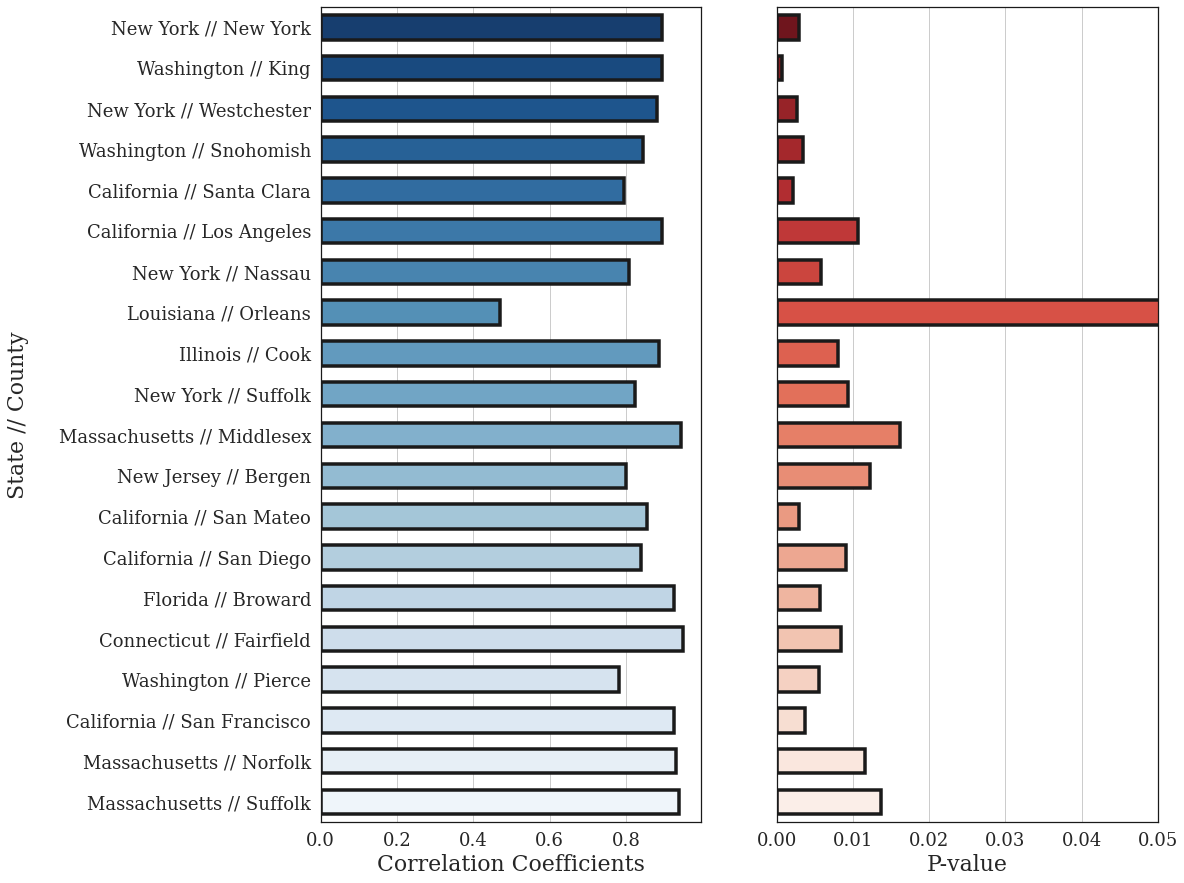

In [392]:
print('Correlation coefficient and p value of Reduction of degree centrality and CDC first-order growth rate\nRanked by cdc confirmed cases\n')

sns.set(style="whitegrid")
f, (ax1, ax2) = plt.subplots(1,2,figsize=(15,15))
sns.set_color_codes("pastel")

kwargs = {'alpha':None, 'linestyle':'-',  'linewidth':3.5, 'edgecolor':'k'}
ax1 = sns.barplot(x="Pearson_Corr",y="State // County", data=corr_dgre_cdc_rank_df[:20], 
                 palette="Blues_r", ax = ax1,**kwargs)

for bar in ax1.patches:
    y = bar.get_y()
    width = bar.get_height()
    centre = y + width/2.
    bar.set_y(centre-0.6/2)
    bar.set_height(0.6)

ax1.set_yticklabels(corr_dgre_cdc_rank_df[0:20]['State // County'].values,fontname='serif', size=18)
ax1.set_xticklabels(['0.0','0.2','0.4','0.6','0.8','1.0'],fontname='serif', size=18)

ax1.set_xlabel("Correlation Coefficients", fontname="serif", fontsize=22)
ax1.set_ylabel("State // County\n", fontname="serif", fontsize=22)


ax2 = sns.barplot(x="p-value",y="State // County", data=pval_dgre_cdc_rank_df[:20],
                  palette="Reds_r", ax=ax2, **kwargs)

for bar in ax2.patches:
    y = bar.get_y()
    width = bar.get_height()
    centre = y + width/2.
    bar.set_y(centre-0.6/2)
    bar.set_height(0.6)
    
# ax2.set_yticklabels(pval_dgre_cdc_rank_df[0:20]['State // County'].values,fontname='serif', size=18)

ax2.set_yticklabels([' ' for i in range(20)],fontname='serif', size=18)
ax2.set_xticklabels(['0.00','0.01','0.02','0.03','0.04','0.05'],fontname='serif', size=18)

ax2.set_xlabel("P-value", fontname="serif", fontsize=22)
ax2.set_ylabel(" ", fontname="serif", fontsize=22)
ax2.set_xlim(0,0.05)

ax1.spines["top"].set_color('k')
ax1.spines["left"].set_color('k')
ax1.spines["right"].set_color('k')
ax1.spines["bottom"].set_color('k')

ax2.spines["top"].set_color('k')
ax2.spines["left"].set_color('k')
ax2.spines["right"].set_color('k')
ax2.spines["bottom"].set_color('k')

Correlation coefficient and p value distribution of Reduction of degree centrality and CDC first-order growth rate
 


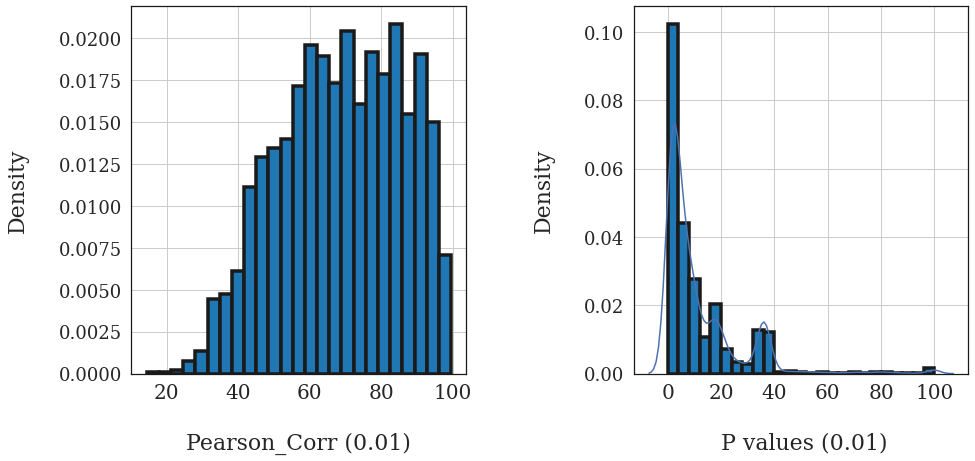

In [393]:
# coefficient distribution

print('Correlation coefficient and p value distribution of Reduction of degree centrality and CDC first-order growth rate\n ')

fig, (ax1, ax2) = plt.subplots(1,2,figsize=(15,6))
plt.subplots_adjust(wspace=0.5, hspace=0.3,
                    left=0.125, right=0.9,
                    top=0.95,    bottom=0.1)

data = list(adj_dgre_coef.values())
data = [i*100 for i in data]

hist_kws = {'edgecolor':"k", 'linewidth':2}
sns.distplot(data,kde=False, norm_hist=True,bins=25,
                 hist_kws=dict(color='tab:blue', edgecolor="k",alpha=None,align='mid', linewidth=3.5), ax=ax1)#, palette=sns.color_palette("coolwarm", 7) )

ax1.set_ylabel('Probability Density', fontname="serif", fontsize=22)
ax1.set_xlabel('Pearson_Corr', fontname="serif", fontsize=22)


ax1.set_xlabel(" \nPearson_Corr (0.01)", fontname="serif", fontsize=22)
ax1.set_ylabel("Density\n ", fontname="serif", fontsize=22)


y_axis_list = ['0.0000','0.0025','0.0050','0.0075','0.0100','0.0125','0.0150','0.0175','0.0200']
ax1.set_yticklabels(y_axis_list,fontname='serif', size=18)
ax1.set_xticklabels(['0','20','40','60','80','100'],fontname='serif', size=20)

ax1.spines["top"].set_color('k')
ax1.spines["left"].set_color('k')
ax1.spines["right"].set_color('k')
ax1.spines["bottom"].set_color('k')

data = list(adg_dgre_pval.values())
data = [i*100 for i in data]
hist_kws = {'edgecolor':"k", 'linewidth':2}
sns.distplot(data,kde=True, norm_hist=True,bins=25,
                   hist_kws=dict(color='tab:blue', edgecolor="k",alpha=None,align='mid', linewidth=3.5), ax=ax2)


ax2.set_xlabel(" \n P values (0.01)", fontname="serif", fontsize=22)
ax2.set_ylabel("Density\n ", fontname="serif", fontsize=22)

y_axis_list = ['0.00','0.02','0.04','0.06','0.08','0.10']
ax2.set_yticklabels(y_axis_list,fontname='serif', size=18)
ax2.set_xticklabels(['-20','0','20','40','60','80','100'],fontname='serif', size=20)

ax2.spines["top"].set_color('k')
ax2.spines["left"].set_color('k')
ax2.spines["right"].set_color('k')
ax2.spines["bottom"].set_color('k')







## Analysis of Degree centrality and Reproduction rate

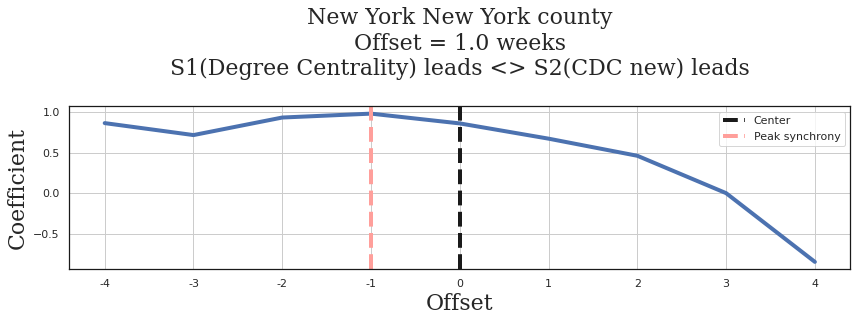

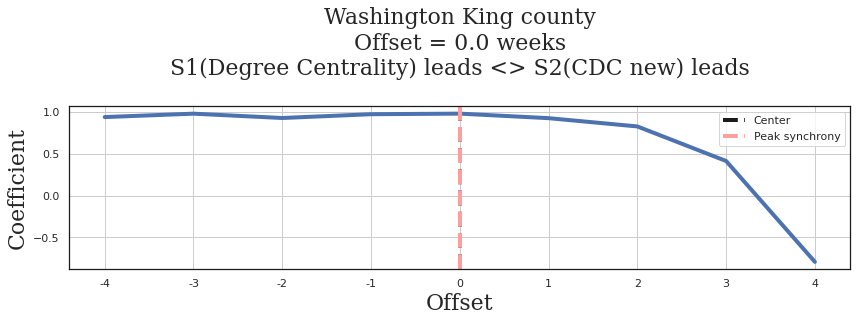

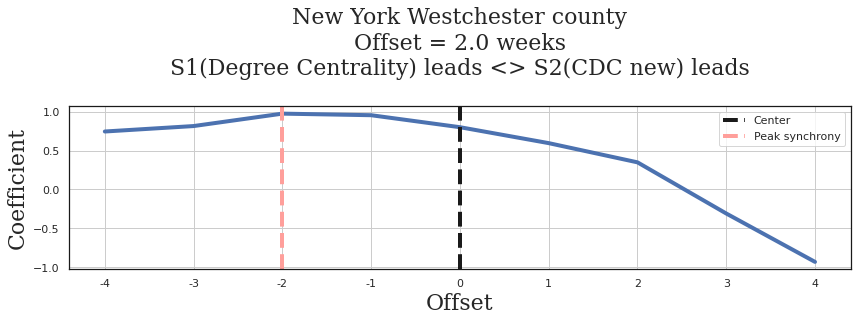

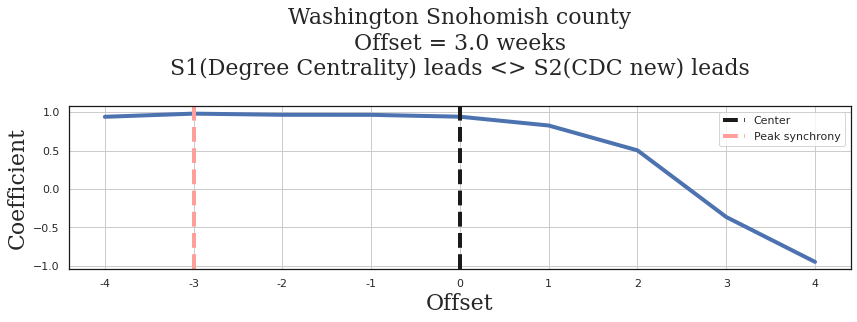

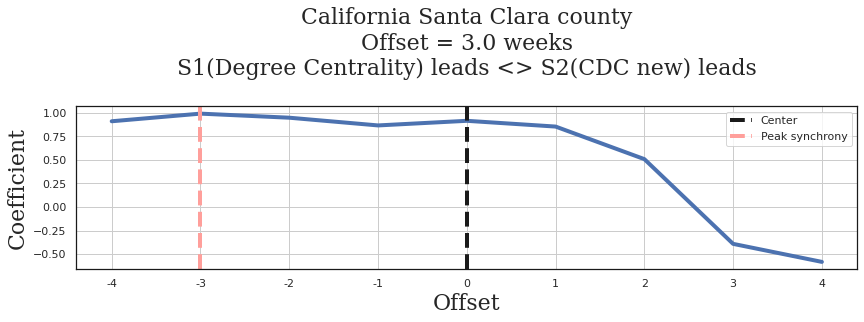

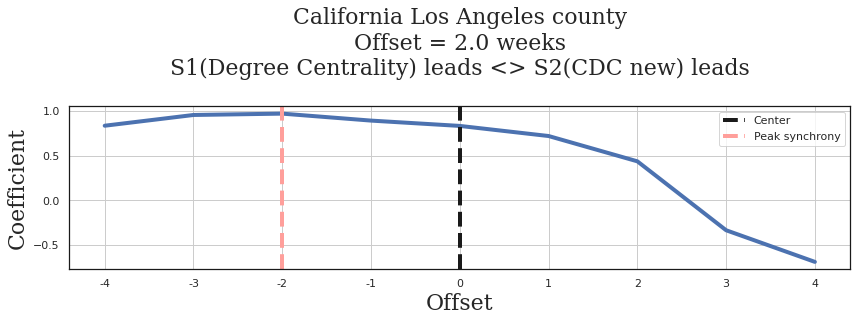

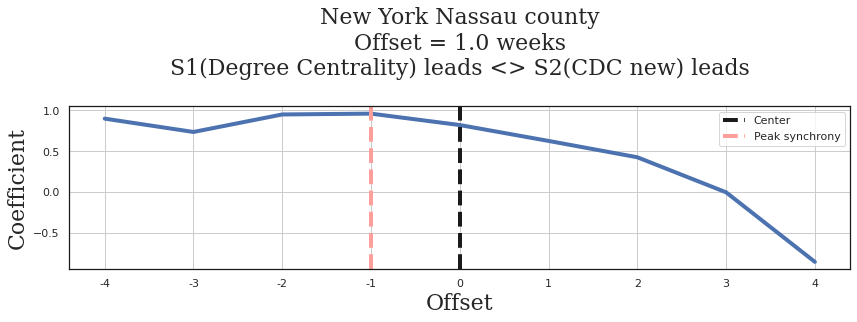

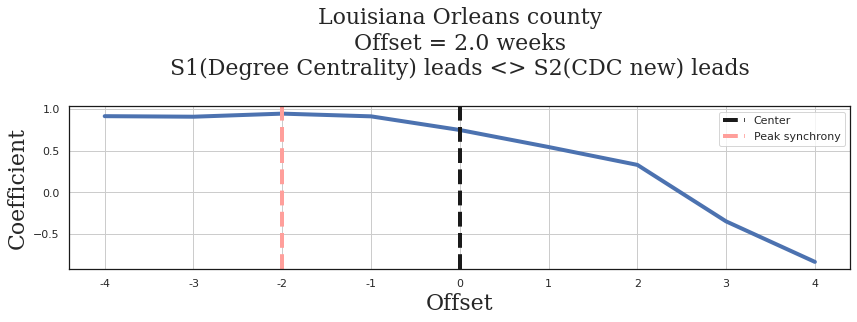

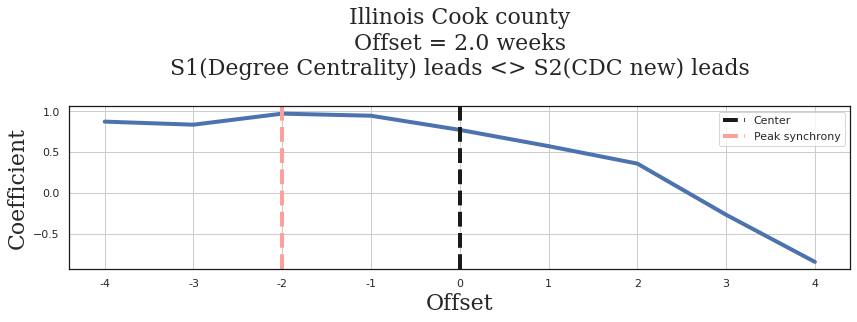

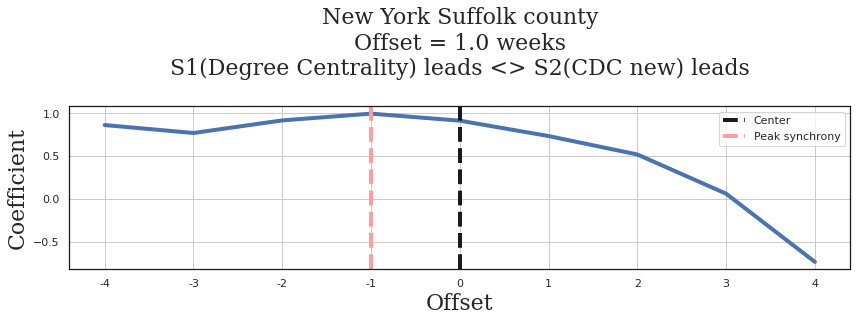

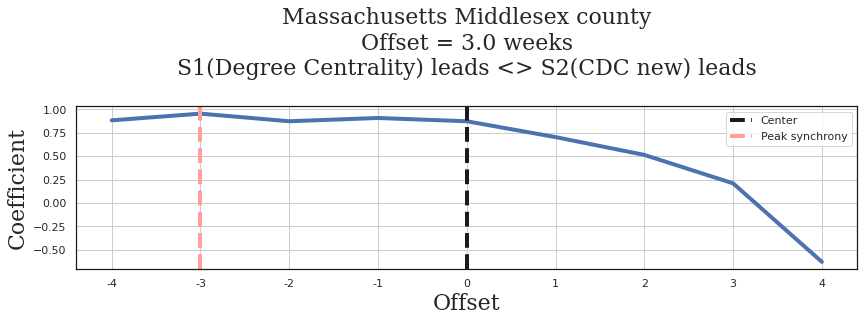

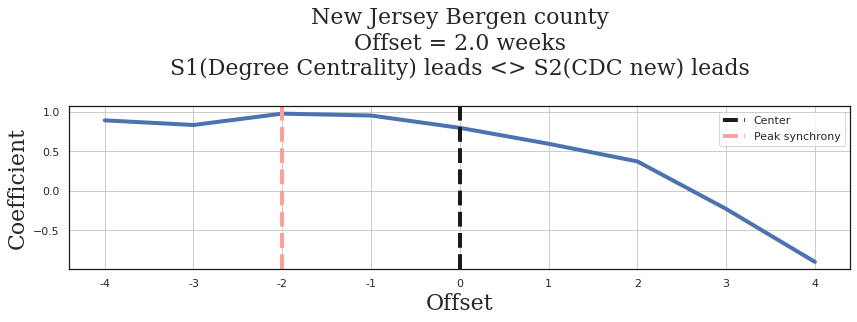

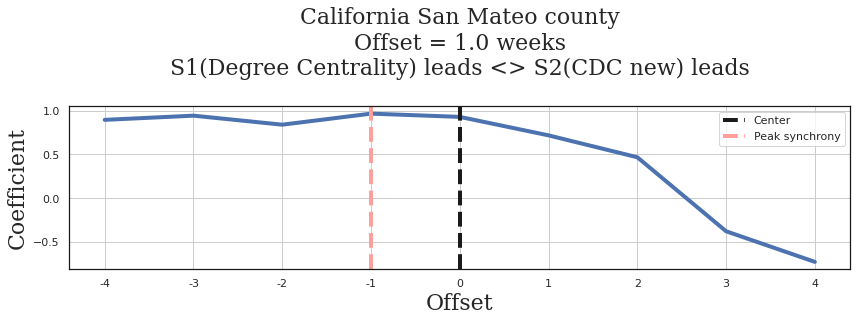

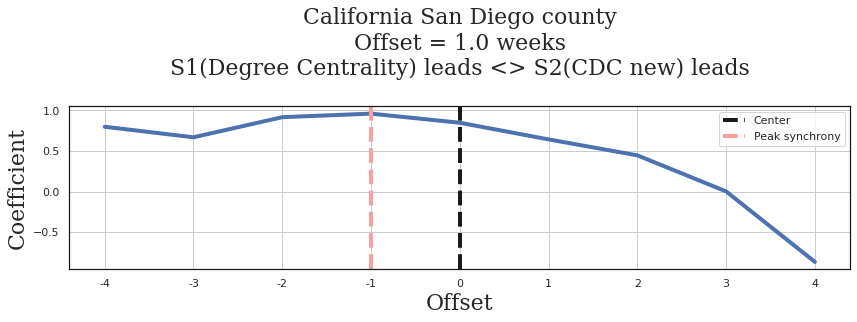

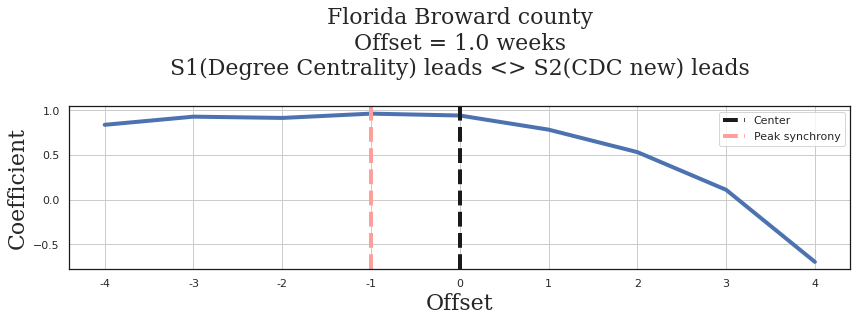

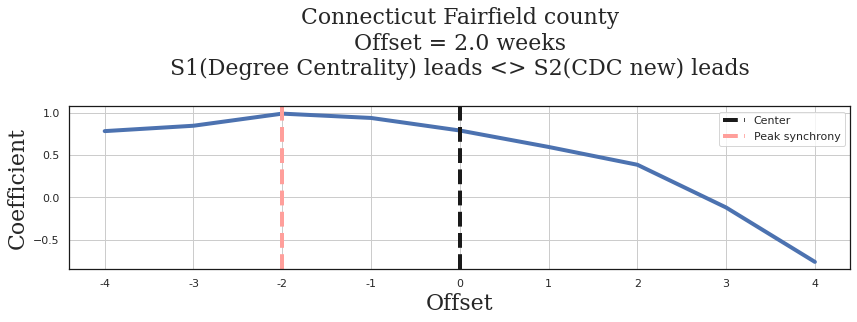

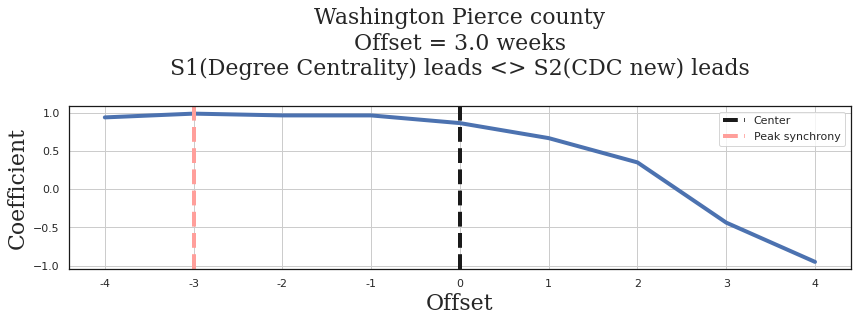

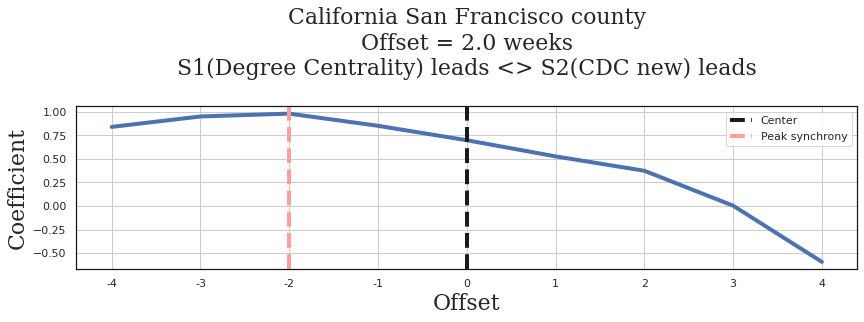

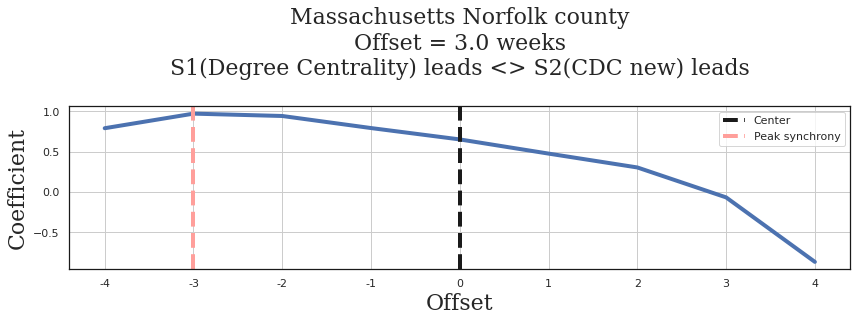

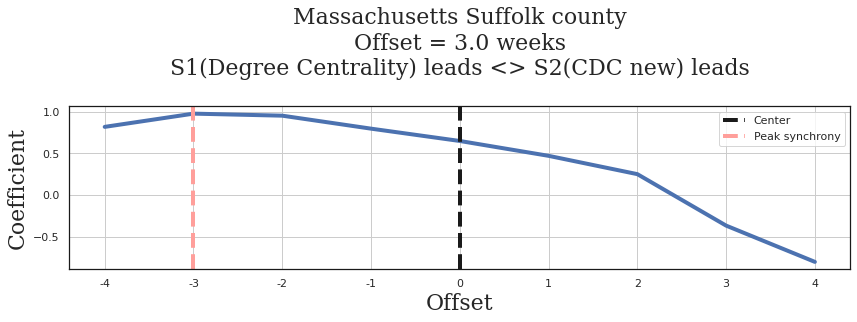

In [394]:
def crosscorr(datax, datay, lag=0, wrap=False):
    """ Lag-N cross correlation. 
    Shifted data filled with NaNs 
    
    Parameters
    ----------
    lag : int, default 0
    datax, datay : pandas.Series objects of equal length
    Returns
    ----------
    crosscorr : float
    """
    if wrap:
        shiftedy = datay.shift(lag)
        shiftedy.iloc[:lag] = datay.iloc[-lag:].values
        return datax.corr(shiftedy)
    else: 
        return datax.corr(datay.shift(lag))
    
seconds = 1
fps = 4
offset_dict = {}
adj_dgre_coef = {}
adg_dgre_pval = {}
org_dgre_coef = {}
org_dgre_pval = {}

i=0
t_len = len(rs)

temp_dgre_fit = dgre_fit_df.fillna(0)
temp_r0_fit = r0_fit_df.fillna(0)
# r0_fit_replace_df = r0_fit_df.fillna(method='bfill',axis=1)
# r0_fit_replace_df = r0_fit_replace_df.dropna()
r0_counties = r0_fit_replace_df.polygon1_id.values
for ids in cdc_ranking.values:
    temp_cdc = confirmed_1_vector[confirmed_1_vector.polygon1_id==ids]
    if (temp_cdc.values.sum() != 0) and (temp_cdc['2020-03-31'].values[0] != 0):
        if ids in dgre_counties:
            if ids in r0_counties:
                d1 = dgre_vector[dgre_vector.polygon1_id==ids].drop(columns='polygon1_id').iloc[0].copy()
                d2 = r0_fit_replace_df[r0_fit_replace_df.polygon1_id==ids].drop(columns='polygon1_id').iloc[0].copy()

                org_dgre_coef[ids] = d1.corr(d2)
                org_dgre_pval[ids] = stats.ttest_ind(d1, d2,equal_var = False)[1]
                rs = [crosscorr(d1,d2, lag) for lag in range(-int(seconds*fps),int(seconds*fps+1))]

                if (np.isnan(np.array(rs)).sum() > 0) and (np.isnan(np.array(rs)).sum() < len(rs)):
                    argmx = np.nanargmax(rs)
                    offset = np.ceil(len(rs)/2)-1-argmx
                    best_lag = -int(seconds*fps) + argmx
                else:
                    argmx = np.argmax(rs)
                    offset = np.ceil(len(rs)/2)-1-argmx
                    best_lag = -int(seconds*fps) + argmx

                offset_dict[ids] = offset

                if best_lag < 0:
                    coef_ = d1.corr(d2.shift(best_lag))
                    pval_ = stats.ttest_ind(d1[:(t_len+best_lag)], d2.shift(best_lag)[:(t_len+best_lag)],equal_var = False)[1]
                elif best_lag > 0:
                    coef_ = d1.corr(d2.shift(best_lag))
                    pval_ = stats.ttest_ind(d1[best_lag:], d2.shift(best_lag)[best_lag:],equal_var = False)[1]
                else:
                    coef_ = d1.corr(d2)
                    pval_ = stats.ttest_ind(d1, d2, equal_var = False)[1]

                adj_dgre_coef[ids] = coef_
                adg_dgre_pval[ids] = pval_       

                    
                if i <20:
                    countyName = pairs_id_s_c_t[pairs_id_s_c_t.polygon1_id==ids]['State // County'].values[0].split(' // ')
                    countyName = countyName[0]+' '+countyName[1]
                    f,ax=plt.subplots(figsize=(14,3))
                    ax.plot(rs, linewidth=4)
                    ax.axvline(np.ceil(len(rs)/2)-1,color='k',linestyle='--',label='Center', linewidth=4)
                    ax.axvline(argmx, color='r',linestyle='--',label='Peak synchrony', linewidth=4)
                    ax.set_title(f'{countyName} county\nOffset = {offset} weeks\nS1(Degree Centrality) leads <> S2(CDC new) leads\n ',fontname="serif", fontsize=22)
                    ax.set_ylabel('Coefficient',fontname="serif", fontsize=22)
                    ax.set_xlabel('Offset',fontname="serif", fontsize=22)
            #             ax.set(title=f'Offset = {offset} frames\nS1 leads <> S2 leads',ylim=[.1,.31],xlim=[0,301], xlabel='Offset',ylabel='Pearson r')
                    ax.set_xticks([0, 1, 2, 3, 4, 5, 6, 7, 8])
                    ax.set_xticklabels([-4,-3,-2,-1,0,1,2,3,4]);


                    ax.spines["top"].set_color('k')
                    ax.spines["left"].set_color('k')
                    ax.spines["right"].set_color('k')
                    ax.spines["bottom"].set_color('k')
                    plt.legend()

#                     plt.savefig(f'DegreeCentrality_and_R0_fit_plot_{countyName}.pdf', bbox_inches='tight') 
                i+=1

In [395]:
offset_dist = pd.DataFrame.from_records([offset_dict]).T

pnt_offset_plot = confirmed_1_vector[['polygon1_id','2020-03-31']].merge(offset_dist.reset_index().rename(columns={'index':'polygon1_id',0:'offset'}),on='polygon1_id')

In [396]:
offset_mean = offset_dist.mean().values[0]
offset_median = offset_dist.median().values[0]
offset_var = offset_dist.var().values[0]

def CI_printout(series, interval = 0.95, method = 't'):
    mean_val = series.mean()
    n = series.count()
    stdev = series.std()
    if method == 't':
        test_stat = stats.t.ppf((interval + 1)/2, n)
    elif method == 'z':
        test_stat = stats.norm.ppf((interval + 1)/2)
    lower_bound = mean_val - test_stat * stdev / math.sqrt(n)
    upper_bound = mean_val + test_stat * stdev / math.sqrt(n)

    return lower_bound.values[0], upper_bound.values[0]
lower_bound, upper_bound = CI_printout(offset_dist)

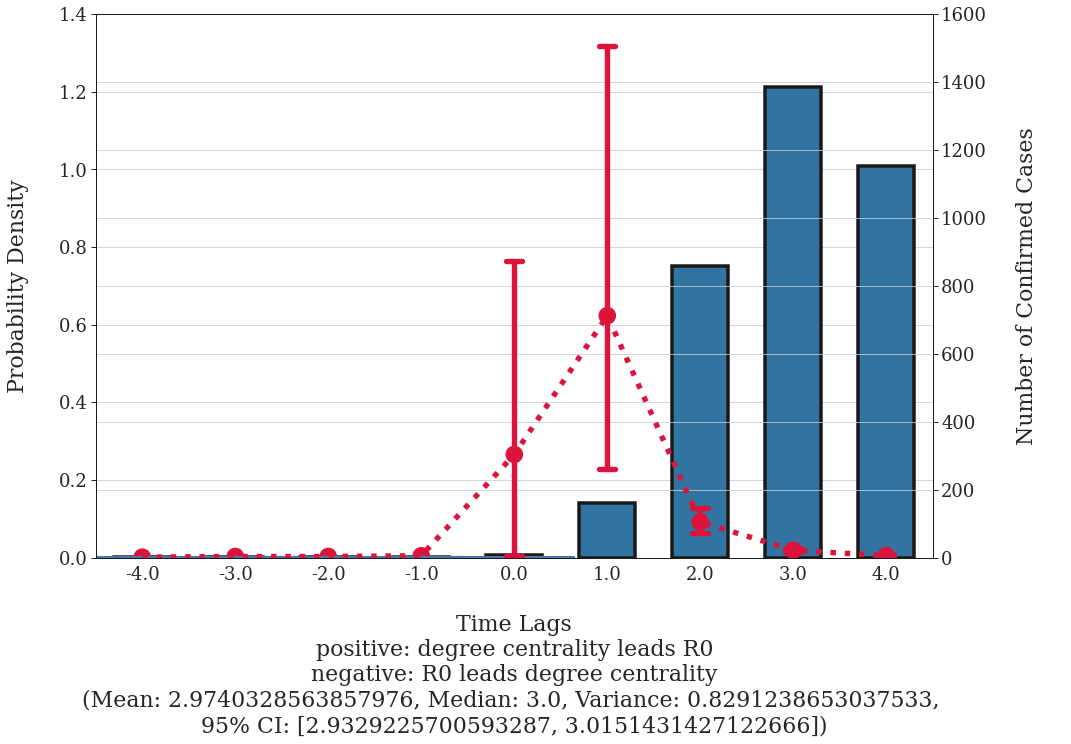

In [397]:
def make_patch_spines_invisible(ax):
    ax.set_frame_on(True)
    ax.patch.set_visible(False)
    for sp in ax.spines.values():
        sp.set_visible(False)

def align_yaxis(ax1, v1, ax2, v2):
    """adjust ax2 ylimit so that v2 in ax2 is aligned to v1 in ax1"""
    _, y1 = ax1.transData.transform((0, v1))
    _, y2 = ax2.transData.transform((0, v2))
    inv = ax2.transData.inverted()
    _, dy = inv.transform((0, 0)) - inv.transform((0, y1-y2))
    miny, maxy = ax2.get_ylim()
    ax2.set_ylim(miny+dy, maxy+dy)
        
        
sns.set(style="whitegrid")
paper_rc = {'lines.linewidth': 3, 'lines.markersize': 3}                  
sns.set_context("paper", rc = paper_rc)    

fig, ax1 = plt.subplots(figsize=(15,10))
ax2 = ax1.twinx()

bar_data = [h.get_height() for h in sns.distplot(offset_dist).patches]
bar_data = np.array(bar_data)
bar_data = bar_data[bar_data!=0]
bar_dict = {}
for i in range(0,9,1):
    bar_dict[i-4] = bar_data[i]
bar_df = pd.DataFrame.from_records([bar_dict])

sns.barplot(data = bar_df,  color='tab:blue', edgecolor='k', linewidth=3.5,ax=ax1)

sns.pointplot('offset','2020-03-31',data=pnt_offset_plot, linewidth=6, linestyles=':',capsize=.17,color='crimson' ,ax=ax2)

align_yaxis(ax1, 0, ax2, 0)

ax1.set_xticklabels(['-4.0','-3.0','-2.0','-1.0','0.0','1.0','2.0','3.0','4.0'],fontname='serif', size=18)
y_axis_list = ['0.0','0.2','0.4','0.6','0.8','1.0','1.2','1.4','1.6']
ax1.set_yticklabels(y_axis_list,fontname='serif', size=18)
# ax2.set_yticklabels([r'$0.0\times10^{6}$',r'$0.2\times10^{6}$',r'$0.4\times10^{6}$',r'$0.6\times10^{6}$',r'$0.8\times10^{6}$',r'$1.0\times10^{6}$',r'$1.2\times10^{6}$',r'$1.4\times10^{6}$',r'$1.6\times10^{6}$',r'$1.8\times10^{6}$'],fontname='serif', size=18)
ax2.set_yticklabels(['0','200','400','600','800','1000','1200','1400','1600'],fontname='serif', size=18)

ax1.set_xlabel(f" \nTime Lags\npositive: degree centrality leads R0\nnegative: R0 leads degree centrality\n(Mean: {offset_mean}, Median: {offset_median}, Variance: {offset_var}, \n95% CI: [{lower_bound}, {upper_bound}])", fontname="serif", fontsize=22)
ax1.set_ylabel("Probability Density\n ", fontname="serif", fontsize=22)
ax2.set_ylabel("\nNumber of Confirmed Cases\n", fontname="serif", fontsize=22)


ax1.set_ylim(0,1.4)
# ax2.set_ylim(0,1800000)
ax2.set_ylim(0,1600)

ax2.spines["top"].set_color('k')
ax2.spines["left"].set_color('k')
ax2.spines["right"].set_color('k')
ax2.spines["bottom"].set_color('k')

def change_width(ax, new_value) :
    for patch in ax.patches :
        current_width = patch.get_width()
        diff = current_width - new_value

        # we change the bar width
        patch.set_width(new_value)

        # we recenter the bar
        patch.set_x(patch.get_x() + diff * .5)

change_width(ax1, .6)

# plt.savefig('Distribution_with_errorbars_time_lags_dgreCen_R0_CDC0331.pdf', bbox_inches='tight') 

In [398]:
pnt_offset_plot = pnt_offset_plot.merge(pop_id.drop_duplicates(),on='polygon1_id')

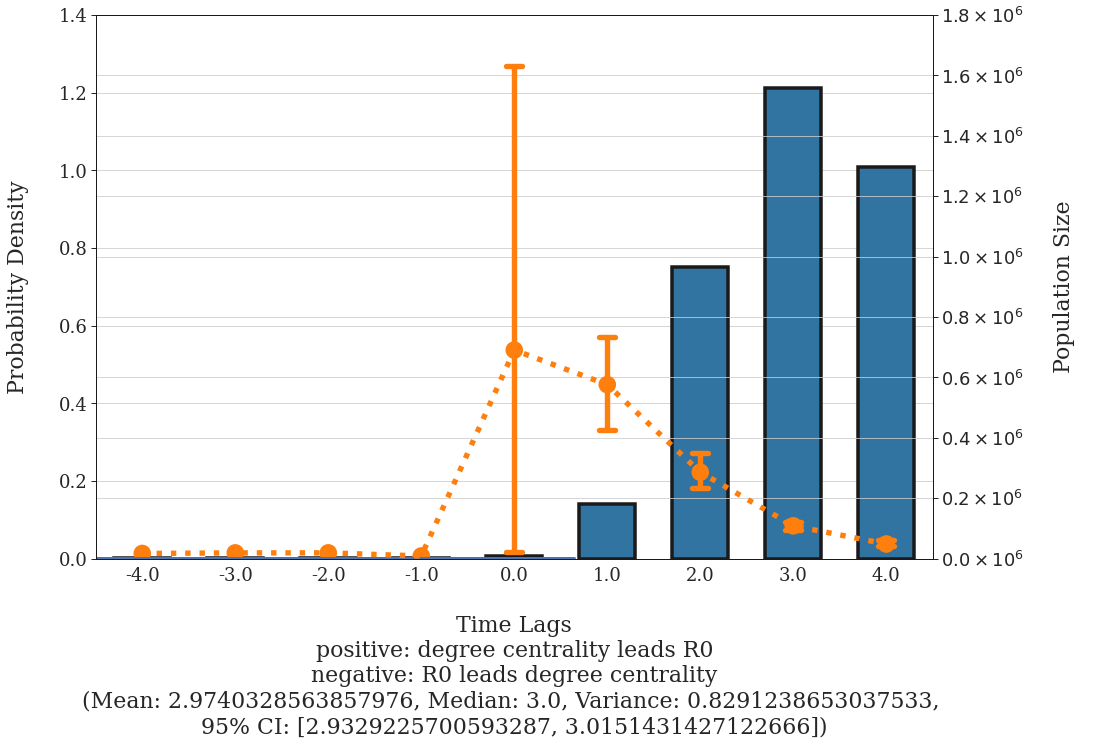

In [399]:
def make_patch_spines_invisible(ax):
    ax.set_frame_on(True)
    ax.patch.set_visible(False)
    for sp in ax.spines.values():
        sp.set_visible(False)

def align_yaxis(ax1, v1, ax2, v2):
    """adjust ax2 ylimit so that v2 in ax2 is aligned to v1 in ax1"""
    _, y1 = ax1.transData.transform((0, v1))
    _, y2 = ax2.transData.transform((0, v2))
    inv = ax2.transData.inverted()
    _, dy = inv.transform((0, 0)) - inv.transform((0, y1-y2))
    miny, maxy = ax2.get_ylim()
    ax2.set_ylim(miny+dy, maxy+dy)
        
        
sns.set(style="whitegrid")
paper_rc = {'lines.linewidth': 3, 'lines.markersize': 3}                  
sns.set_context("paper", rc = paper_rc)    

fig, ax1 = plt.subplots(figsize=(15,10))
ax2 = ax1.twinx()

bar_data = [h.get_height() for h in sns.distplot(offset_dist).patches]
bar_data = np.array(bar_data)
bar_data = bar_data[bar_data!=0]
bar_dict = {}
for i in range(0,9,1):
    bar_dict[i-4] = bar_data[i]
bar_df = pd.DataFrame.from_records([bar_dict])

sns.barplot(data = bar_df,  color='tab:blue', edgecolor='k', linewidth=3.5,ax=ax1)

sns.pointplot('offset','POPULATION',data=pnt_offset_plot, linewidth=6, linestyles=':',capsize=.17,color='tab:orange' ,ax=ax2)

align_yaxis(ax1, 0, ax2, 0)

ax1.set_xticklabels(['-4.0','-3.0','-2.0','-1.0','0.0','1.0','2.0','3.0','4.0'],fontname='serif', size=18)
y_axis_list = ['0.0','0.2','0.4','0.6','0.8','1.0','1.2','1.4','1.6']
ax1.set_yticklabels(y_axis_list,fontname='serif', size=18)
ax2.set_yticklabels([r'$0.0\times10^{6}$',r'$0.2\times10^{6}$',r'$0.4\times10^{6}$',r'$0.6\times10^{6}$',r'$0.8\times10^{6}$',r'$1.0\times10^{6}$',r'$1.2\times10^{6}$',r'$1.4\times10^{6}$',r'$1.6\times10^{6}$',r'$1.8\times10^{6}$'],fontname='serif', size=18)

ax1.set_xlabel(f" \nTime Lags\npositive: degree centrality leads R0\nnegative: R0 leads degree centrality\n(Mean: {offset_mean}, Median: {offset_median}, Variance: {offset_var}, \n95% CI: [{lower_bound}, {upper_bound}])", fontname="serif", fontsize=22)
ax1.set_ylabel("Probability Density\n ", fontname="serif", fontsize=22)
ax2.set_ylabel("\nPopulation Size\n", fontname="serif", fontsize=22)


ax1.set_ylim(0,1.4)
ax2.set_ylim(0,1800000)

ax2.spines["top"].set_color('k')
ax2.spines["left"].set_color('k')
ax2.spines["right"].set_color('k')
ax2.spines["bottom"].set_color('k')

def change_width(ax, new_value) :
    for patch in ax.patches :
        current_width = patch.get_width()
        diff = current_width - new_value

        # we change the bar width
        patch.set_width(new_value)

        # we recenter the bar
        patch.set_x(patch.get_x() + diff * .5)

change_width(ax1, .6)


In [412]:
def toPvalue(dic):
    new_dic = {}
    for key, val in dic.items():
        if val <0.001:
            new_dic[key] = 1
        elif (val >= 0.001) and (val < 0.01):
            new_dic[key] = 2
        elif (val >= 0.01) and (val < 0.05):
            new_dic[key] = 3
        
    return new_dic

# p_lv_btwn = toPvalue(p_btwn)
p_lv_dgre = toPvalue(adg_dgre_pval)


# p_lv_btwn = pd.Series(p_lv_btwn)
p_lv_dgre = pd.Series(p_lv_dgre)

In [413]:
# def returnPlv(row):
#     pval = row['p-value']
#     if pval <= 0.001:
#         return 1
#     elif (pval > 0.001) and (pval<=0.01):
#         return 2
#     else:
#         return 3
# pval_dgre_cdc_rank_df['p_lv'] = pval_dgre_cdc_rank_df.apply(lambda row: returnPlv(row), axis=1)

pnt_plot = confirmed_1_vector[['polygon1_id','2020-03-31']].merge(p_lv_dgre.reset_index().rename(columns={'index':'polygon1_id',0:'p_level'}), on='polygon1_id')
pnt_plot

polygon1_id  2020-03-31  p_level
0         1414620           1        1
1         1419657           1        1
2         1204566           1        1
3         1214994           1        1
4         1089023           1        1
...           ...         ...      ...
1882      1433611         314        3
1883      1433597        2357        2
1884      1433635          91        1
1885      1433591          27        1
1886      1433615         377        2

[1887 rows x 3 columns]

In [411]:
pnt_plot.p_level.unique()

array([1, 2])

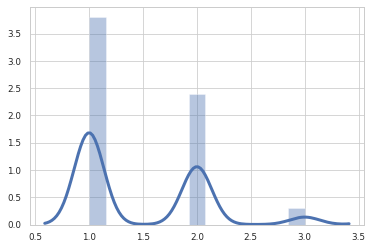

In [414]:
bar_data = [h.get_height() for h in sns.distplot(pnt_plot[['p_level']]).patches]
bar_data = np.array(bar_data)
bar_data = bar_data[bar_data!=0]
bar_dict = {}
for i in range(0,3,1):
    bar_dict[i+1] = bar_data[i]
bar_df = pd.DataFrame.from_records([bar_dict])

Text(0.5, 1.0, 'Correlation p-value distribution\nbetween degree centrality and the lag adjusted reproduction rate\nand the numberof confirmed cases\n')

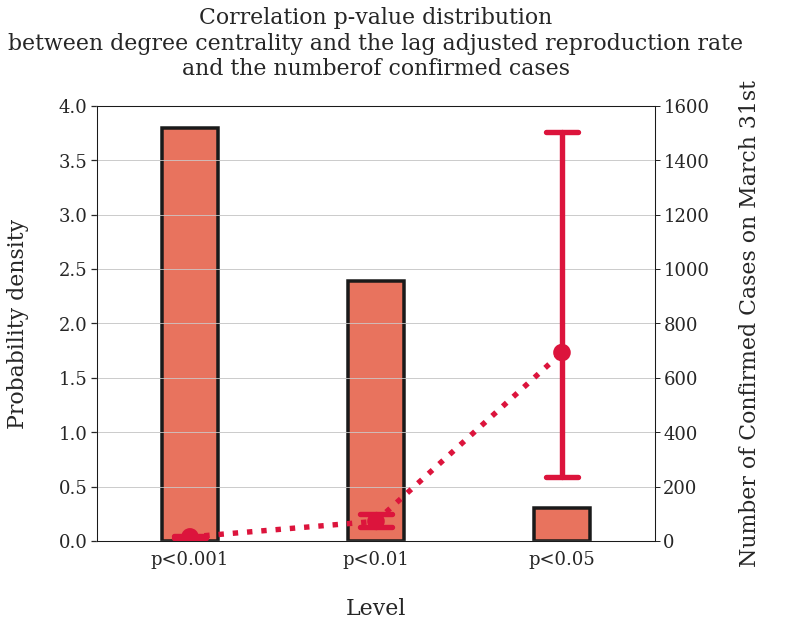

In [418]:
sns.set(style="whitegrid")
fig = plt.figure(figsize=(10,8))
ax1 = fig.add_subplot(111)

paper_rc = {'lines.linewidth': 3, 'lines.markersize': 3}                  
sns.set_context("paper", rc = paper_rc)    

sns.set_color_codes("pastel")
# ax1 = sns.distplot(p_lv_dgre-1,kde=False, norm_hist=True, bins=15)#, hist_kws={'align':'mid'})

sns.barplot(data = bar_df, color='tomato', edgecolor='k', linewidth=3.5,ax=ax1)


ax2 = ax1.twinx()
sns.pointplot('p_level','2020-03-31',data=pnt_plot, linewidth=6, linestyles=':'
              ,capsize=.17,color='crimson' ,ax=ax2)

align_yaxis(ax1, 0, ax2, 0)

ax1.set_yticklabels(['0.0','0.5','1.0','1.5','2.0','2.5','3.0','3.5','4.0'],fontname='serif', size=18)
ax1.set_xticklabels(['p<0.001','p<0.01','p<0.05'],fontname='serif', size=18)
ax2.set_yticklabels(['0','200','400','600','800','1000','1200','1400','1600'],fontname='serif', size=18)


ax1.set_ylabel("Probability density\n", fontname="serif", fontsize=22)
ax2.set_ylabel("\nNumber of Confirmed Cases on March 31st\n", fontname="serif", fontsize=22)
ax1.set_xlabel(" \nLevel", fontname="serif", fontsize=22)


def change_width(ax, new_value) :
    for patch in ax.patches :
        current_width = patch.get_width()
        diff = current_width - new_value

        # we change the bar width
        patch.set_width(new_value)

        # we recenter the bar
        patch.set_x(patch.get_x() + diff * .5)

change_width(ax1, .3)

ax1.set_ylim(0,4)
# ax2.set_ylim(0,1800000)
ax2.set_ylim(0,1600)


ax2.spines["top"].set_color('k')
ax2.spines["left"].set_color('k')
ax2.spines["right"].set_color('k')
ax2.spines["bottom"].set_color('k')

plt.title('Correlation p-value distribution\nbetween degree centrality and the lag adjusted reproduction rate\nand the numberof confirmed cases\n',fontname='serif', fontsize=22)
# plt.savefig('distribution_pval_DegreeCentrality_R0_fit_CDC0331.pdf', bbox_inches='tight') 

In [400]:
# ranking based on cdc_ranking
corr_dgre_cdc_rank = {}
pval_dgre_cdc_rank = {}
for i, idx in enumerate(cdc_counties):
#     if i<20:
    
    if idx in adj_dgre_coef.keys():
        corr_dgre_cdc_rank[idx] = adj_dgre_coef[idx]
        pval_dgre_cdc_rank[idx] = adg_dgre_pval[idx]

corr_dgre_cdc_rank_df = pd.DataFrame(corr_dgre_cdc_rank.values(), index=corr_dgre_cdc_rank.keys()).reset_index().rename(columns={'index': 'polygon1_id', 0: 'Pearson_Corr'})
pairs_id_s_c_t = pairs_id_s_c_t.rename(columns={'name_stack_1': 'State // County'})
corr_dgre_cdc_rank_df  = corr_dgre_cdc_rank_df.merge(pairs_id_s_c_t[['polygon1_id','State // County']], how='inner', on="polygon1_id")

pval_dgre_cdc_rank_df = pd.DataFrame(pval_dgre_cdc_rank.values(), index=pval_dgre_cdc_rank.keys()).reset_index().rename(columns={'index': 'polygon1_id', 0: 'p-value'})
# pairs_id_s_c_t = pairs_id_s_c_t.rename(columns={'name_stack_1': 'State // County'})
pval_dgre_cdc_rank_df  = pval_dgre_cdc_rank_df.merge(pairs_id_s_c_t[['polygon1_id','State // County']], how='inner', on="polygon1_id")

Correlation coefficient and p value of degree centrality and reproduction rate
Ranked by cdc confirmed cases



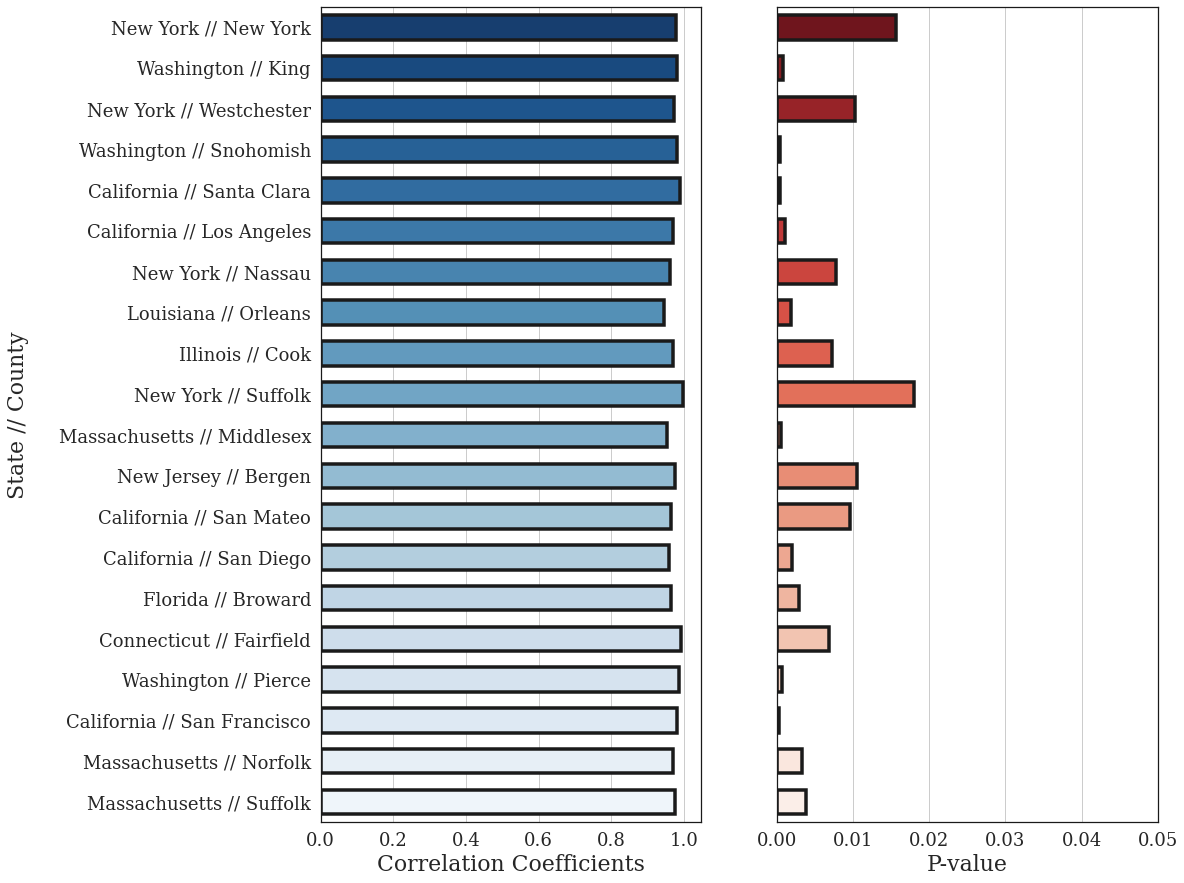

In [403]:
print('Correlation coefficient and p value of degree centrality and reproduction rate\nRanked by cdc confirmed cases\n')

sns.set(style="whitegrid")
f, (ax1, ax2) = plt.subplots(1,2,figsize=(15,15))
sns.set_color_codes("pastel")

kwargs = {'alpha':None, 'linestyle':'-',  'linewidth':3.5, 'edgecolor':'k'}
ax1 = sns.barplot(x="Pearson_Corr",y="State // County", data=corr_dgre_cdc_rank_df[:20], 
                 palette="Blues_r", ax = ax1,**kwargs)

for bar in ax1.patches:
    y = bar.get_y()
    width = bar.get_height()
    centre = y + width/2.
    bar.set_y(centre-0.6/2)
    bar.set_height(0.6)

ax1.set_yticklabels(corr_dgre_cdc_rank_df[0:20]['State // County'].values,fontname='serif', size=18)
ax1.set_xticklabels(['0.0','0.2','0.4','0.6','0.8','1.0'],fontname='serif', size=18)

ax1.set_xlabel("Correlation Coefficients", fontname="serif", fontsize=22)
ax1.set_ylabel("State // County\n", fontname="serif", fontsize=22)


ax2 = sns.barplot(x="p-value",y="State // County", data=pval_dgre_cdc_rank_df[:20],
                  palette="Reds_r", ax=ax2, **kwargs)

for bar in ax2.patches:
    y = bar.get_y()
    width = bar.get_height()
    centre = y + width/2.
    bar.set_y(centre-0.6/2)
    bar.set_height(0.6)
    
# ax2.set_yticklabels(pval_dgre_cdc_rank_df[0:20]['State // County'].values,fontname='serif', size=18)

ax2.set_yticklabels([' ' for i in range(20)],fontname='serif', size=18)
ax2.set_xticklabels(['0.00','0.01','0.02','0.03','0.04','0.05'],fontname='serif', size=18)

ax2.set_xlabel("P-value", fontname="serif", fontsize=22)
ax2.set_ylabel(" ", fontname="serif", fontsize=22)
ax2.set_xlim(0,0.05)

ax1.spines["top"].set_color('k')
ax1.spines["left"].set_color('k')
ax1.spines["right"].set_color('k')
ax1.spines["bottom"].set_color('k')

ax2.spines["top"].set_color('k')
ax2.spines["left"].set_color('k')
ax2.spines["right"].set_color('k')
ax2.spines["bottom"].set_color('k')

Correlation coefficient and p value distribution of degree centrality and reproduction rate
 


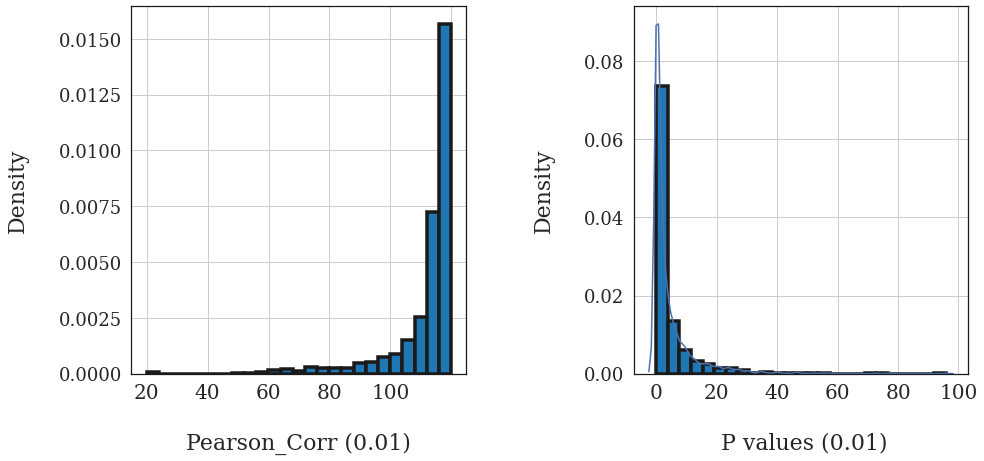

In [404]:
# coefficient distribution

print('Correlation coefficient and p value distribution of degree centrality and reproduction rate\n ')

fig, (ax1, ax2) = plt.subplots(1,2,figsize=(15,6))
plt.subplots_adjust(wspace=0.5, hspace=0.3,
                    left=0.125, right=0.9,
                    top=0.95,    bottom=0.1)

data = list(adj_dgre_coef.values())
data = [i*100 for i in data]

hist_kws = {'edgecolor':"k", 'linewidth':2}
sns.distplot(data,kde=False, norm_hist=True,bins=25,
                 hist_kws=dict(color='tab:blue', edgecolor="k",alpha=None,align='mid', linewidth=3.5), ax=ax1)#, palette=sns.color_palette("coolwarm", 7) )

ax1.set_ylabel('Probability Density', fontname="serif", fontsize=22)
ax1.set_xlabel('Pearson_Corr', fontname="serif", fontsize=22)


ax1.set_xlabel(" \nPearson_Corr (0.01)", fontname="serif", fontsize=22)
ax1.set_ylabel("Density\n ", fontname="serif", fontsize=22)


y_axis_list = ['0.0000','0.0025','0.0050','0.0075','0.0100','0.0125','0.0150','0.0175','0.0200']
ax1.set_yticklabels(y_axis_list,fontname='serif', size=18)
ax1.set_xticklabels(['0','20','40','60','80','100'],fontname='serif', size=20)

ax1.spines["top"].set_color('k')
ax1.spines["left"].set_color('k')
ax1.spines["right"].set_color('k')
ax1.spines["bottom"].set_color('k')

data = list(adg_dgre_pval.values())
data = [i*100 for i in data]
hist_kws = {'edgecolor':"k", 'linewidth':2}
sns.distplot(data,kde=True, norm_hist=True,bins=25,
                   hist_kws=dict(color='tab:blue', edgecolor="k",alpha=None,align='mid', linewidth=3.5), ax=ax2)


ax2.set_xlabel(" \n P values (0.01)", fontname="serif", fontsize=22)
ax2.set_ylabel("Density\n ", fontname="serif", fontsize=22)

y_axis_list = ['0.00','0.02','0.04','0.06','0.08','0.10']
ax2.set_yticklabels(y_axis_list,fontname='serif', size=18)
ax2.set_xticklabels(['-20','0','20','40','60','80','100'],fontname='serif', size=20)

ax2.spines["top"].set_color('k')
ax2.spines["left"].set_color('k')
ax2.spines["right"].set_color('k')
ax2.spines["bottom"].set_color('k')







## Analysis of Degree centrality and CDC second-order growth rate

In [ ]:
# Modify noise

dgre_lowest = {}
for index, row in dgre_vector.iterrows():
    minValue = 0
    for i, ele in enumerate(row[vector_cols[1:]].values):
        if i==0:
            minValue = i
        else:
            if ele < row[minValue+1]:
                minValue = i
    dgre_lowest[row[0]] = minValue


sec_frst_neg={}
for index, row in confirmed_2_vector.iterrows():
    for i, ele in enumerate(row[vector_cols[1:]].values):
        if ele < 0:
            sec_frst_neg[row[0]] = i
            break
            
dgre_low = pd.DataFrame.from_records([dgre_lowest]).T.reset_index().rename(columns={'index':'polygon1_id',0:'dgre_week'})
secCDC_neg = pd.DataFrame.from_records([sec_frst_neg]).T.reset_index().rename(columns={'index':'polygon1_id',0:'secCDC_week'})
secCDC_dgre_offset = secCDC_neg.merge(dgre_low, on='polygon1_id')

secCDC_dgre_offset['offset'] = secCDC_dgre_offset.apply(lambda row: row['secCDC_week'] - row['dgre_week'], axis=1)
secCDC_dgre_offset = secCDC_dgre_offset.merge(confirmed_1_vector[['polygon1_id','2020-03-31']],on='polygon1_id')

secCDC_dgre_offset =secCDC_dgre_offset.merge(pop_id.drop_duplicates(), on='polygon1_id')

In [337]:
offset_dist = secCDC_dgre_offset['offset'].reset_index().drop(columns='index')

offset_mean = offset_dist.mean().values[0]
offset_median = offset_dist.median().values[0]
offset_var = offset_dist.var().values[0]

def CI_printout(series, interval = 0.95, method = 't'):
    mean_val = series.mean()
    n = series.count()
    stdev = series.std()
    if method == 't':
        test_stat = stats.t.ppf((interval + 1)/2, n)
    elif method == 'z':
        test_stat = stats.norm.ppf((interval + 1)/2)
    lower_bound = mean_val - test_stat * stdev / math.sqrt(n)
    upper_bound = mean_val + test_stat * stdev / math.sqrt(n)

    return lower_bound.values[0], upper_bound.values[0]
lower_bound, upper_bound = CI_printout(offset_dist)

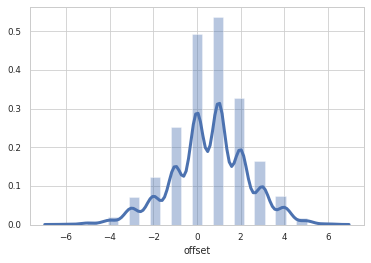

In [331]:
bar_data = [h.get_height() for h in sns.distplot(secCDC_dgre_offset['offset'],bins=25).patches]
bar_data = np.array(bar_data)
bar_data = bar_data[bar_data!=0]
bar_dict = {}
for i in range(0,13,1):
    bar_dict[i-6] = bar_data[i]
bar_df = pd.DataFrame.from_records([bar_dict])

Text(0.5, 1.0, 'Distribution of the time lags between degree centrality and secondary CDC\nwith error bars of CDC confirmed cases on March 31\n')

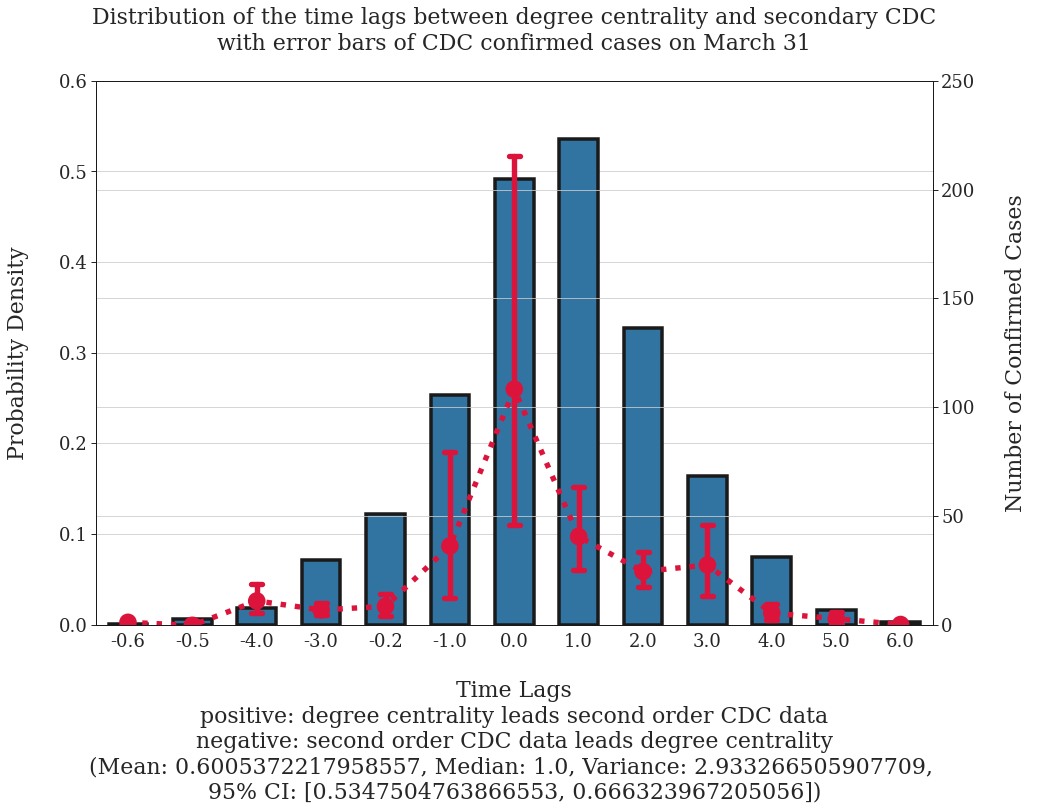

In [338]:
def make_patch_spines_invisible(ax):
    ax.set_frame_on(True)
    ax.patch.set_visible(False)
    for sp in ax.spines.values():
        sp.set_visible(False)

def align_yaxis(ax1, v1, ax2, v2):
    """adjust ax2 ylimit so that v2 in ax2 is aligned to v1 in ax1"""
    _, y1 = ax1.transData.transform((0, v1))
    _, y2 = ax2.transData.transform((0, v2))
    inv = ax2.transData.inverted()
    _, dy = inv.transform((0, 0)) - inv.transform((0, y1-y2))
    miny, maxy = ax2.get_ylim()
    ax2.set_ylim(miny+dy, maxy+dy)
        
        
sns.set(style="whitegrid")
paper_rc = {'lines.linewidth': 3, 'lines.markersize': 3}                  
sns.set_context("paper", rc = paper_rc)    


fig, ax1 = plt.subplots(figsize=(15,10))
ax2 = ax1.twinx()

# Change distribution data to bar data to make the center of the bars in the specific x points
sns.barplot(data = bar_df,  color='tab:blue', edgecolor='k', linewidth=3.5,ax=ax1)

sns.pointplot('offset','2020-03-31',data=secCDC_dgre_offset, linewidth=6, linestyles=':',capsize=.17,color='crimson', ax=ax2)

align_yaxis(ax1, 0, ax2, 0)

ax1.set_yticklabels(['0.0','0.1','0.2','0.3','0.4','0.5','0.6'],fontname='serif', size=18)
ax1.set_xticklabels(['-0.6','-0.5','-4.0','-3.0','-0.2','-1.0','0.0','1.0','2.0','3.0','4.0','5.0','6.0'],fontname='serif', size=18)
ax2.set_yticklabels(['0','50','100','150','200','250'],fontname='serif', size=18)


ax1.set_ylabel("Probability Density\n", fontname="serif", fontsize=22)
ax2.set_ylabel("\nNumber of Confirmed Cases\n", fontname="serif", fontsize=22)
ax1.set_xlabel(f"\nTime Lags\npositive: degree centrality leads second order CDC data\nnegative: second order CDC data leads degree centrality\n(Mean: {offset_mean}, Median: {offset_median}, Variance: {offset_var}, \n95% CI: [{lower_bound}, {upper_bound}])", fontname="serif", fontsize=22)



ax1.set_ylim(0, 0.6)
ax2.set_ylim(0,250)

ax2.spines["top"].set_color('k')
ax2.spines["left"].set_color('k')
ax2.spines["right"].set_color('k')
ax2.spines["bottom"].set_color('k')

def change_width(ax, new_value) :
    for patch in ax.patches :
        current_width = patch.get_width()
        diff = current_width - new_value

        # we change the bar width
        patch.set_width(new_value)

        # we recenter the bar
        patch.set_x(patch.get_x() + diff * .5)

change_width(ax1, .6)

plt.title('Distribution of the time lags between degree centrality and secondary CDC\nwith error bars of CDC confirmed cases on March 31\n',fontname='serif', fontsize=22)
# plt.savefig('Distribution_with_errorbars_time_lags_dgreCen_secondaryCDC_CDC0331.pdf', bbox_inches='tight') 

Text(0.5, 1.0, 'Distribution of the time lags between degree centrality and secondary CDC\nwith error bars of CDC confirmed cases on March 31\n')

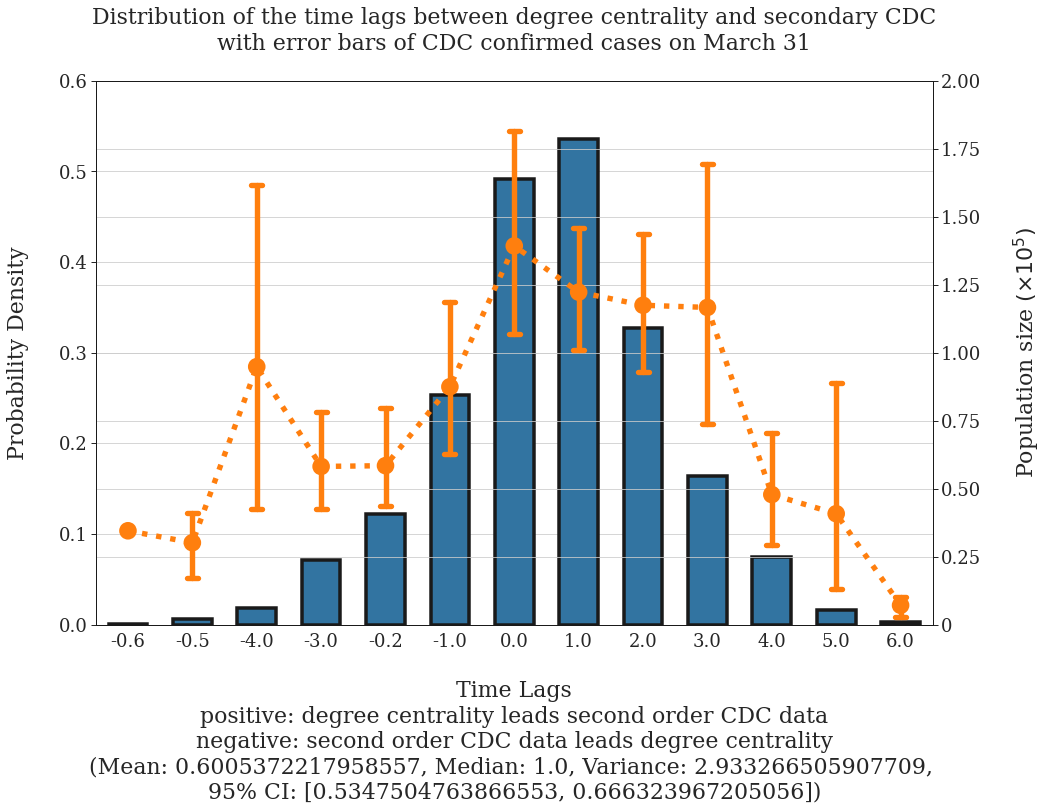

In [339]:
def make_patch_spines_invisible(ax):
    ax.set_frame_on(True)
    ax.patch.set_visible(False)
    for sp in ax.spines.values():
        sp.set_visible(False)

def align_yaxis(ax1, v1, ax2, v2):
    """adjust ax2 ylimit so that v2 in ax2 is aligned to v1 in ax1"""
    _, y1 = ax1.transData.transform((0, v1))
    _, y2 = ax2.transData.transform((0, v2))
    inv = ax2.transData.inverted()
    _, dy = inv.transform((0, 0)) - inv.transform((0, y1-y2))
    miny, maxy = ax2.get_ylim()
    ax2.set_ylim(miny+dy, maxy+dy)
        
        
sns.set(style="whitegrid")
paper_rc = {'lines.linewidth': 3, 'lines.markersize': 3}                  
sns.set_context("paper", rc = paper_rc)    

fig, ax1 = plt.subplots(figsize=(15,10))
ax2 = ax1.twinx()

# ax1 = sns.distplot(secCDC_dgre_offset['offset'],kde=False, norm_hist=True,bins=25)


sns.barplot(data = bar_df,  color='tab:blue', edgecolor='k', linewidth=3.5,ax=ax1)

sns.pointplot('offset','POPULATION',data=secCDC_dgre_offset, linewidth=6, linestyles=':',capsize=.17,color='tab:orange', ax=ax2)

align_yaxis(ax1, 0, ax2, 0)

ax1.set_yticklabels(['0.0','0.1','0.2','0.3','0.4','0.5','0.6'],fontname='serif', size=18)
ax1.set_xticklabels(['-0.6','-0.5','-4.0','-3.0','-0.2','-1.0','0.0','1.0','2.0','3.0','4.0','5.0','6.0'],fontname='serif', size=18)
ax2.set_yticklabels(['0','0.25','0.50','0.75','1.00','1.25','1.50','1.75','2.00'],fontname='serif', size=18)


ax1.set_ylabel("Probability Density\n", fontname="serif", fontsize=22)
ax2.set_ylabel("\nPopulation size "+r'$(\times10^{5})$', fontname="serif", fontsize=22)
ax1.set_xlabel(f"\nTime Lags\npositive: degree centrality leads second order CDC data\nnegative: second order CDC data leads degree centrality\n(Mean: {offset_mean}, Median: {offset_median}, Variance: {offset_var}, \n95% CI: [{lower_bound}, {upper_bound}])", fontname="serif", fontsize=22)


ax1.set_ylim(0,0.6)
# ax2.set_ylim(0,1800000)
ax2.set_ylim(0,200000)

ax2.spines["top"].set_color('k')
ax2.spines["left"].set_color('k')
ax2.spines["right"].set_color('k')
ax2.spines["bottom"].set_color('k')

def change_width(ax, new_value) :
    for patch in ax.patches :
        current_width = patch.get_width()
        diff = current_width - new_value

        # we change the bar width
        patch.set_width(new_value)

        # we recenter the bar
        patch.set_x(patch.get_x() + diff * .5)

change_width(ax1, .6)

plt.title('Distribution of the time lags between degree centrality and secondary CDC\nwith error bars of CDC confirmed cases on March 31\n',fontname='serif', fontsize=22)
# plt.savefig('Distribution_with_errorbars_time_lags_dgreCen_secondaryCDC_population.pdf', bbox_inches='tight') 

# Travel reduction and segregation across county groups <a class="anchor" id="sixth-bullet"></a>

### Co-location probability across different county groups for different time


In [422]:
# Group counties by week criteria

group_week = ['0310','0317','0324','0331']

cdc_ranking_week = {}
groupH = {}
groupM = {}
groupL = {}
groupH_df = {}
groupM_df = {}
groupL_df = {}

group_set = {}

for wk in group_week:
    cdc_ranking_week[wk] = cdc_weekly_confirmed[wk].sort_values(by=['Confirmed'],ascending=False)['polygon1_id']
    ranking_temp = cdc_ranking_week[wk].values
    sizeofGroup= int((len(ranking_temp)/3))
    groupH[wk] = ranking_temp[:sizeofGroup]
    groupM[wk] = ranking_temp[sizeofGroup : sizeofGroup*2]
    groupL[wk] = ranking_temp[sizeofGroup*2:sizeofGroup*3]
    
    groupH_df[wk] = pd.DataFrame(groupH[wk]).rename(columns={0:'polygon1_id'})
    groupH_df[wk]['group'] = 'H'

    groupM_df[wk] = pd.DataFrame(groupM[wk]).rename(columns={0:'polygon1_id'})
    groupM_df[wk]['group'] = 'M'

    groupL_df[wk] = pd.DataFrame(groupL[wk]).rename(columns={0:'polygon1_id'})
    groupL_df[wk]['group'] = 'L'
    
    group_set[wk] = pd.concat([groupH_df[wk],groupM_df[wk],groupL_df[wk]])

In [423]:
# Generate heatmap dataset

# group_colocation[cdc_rank_week][colocation_data_week]

group_colocation = {}
hmap = {}
for wk in group_week:
    group_colocation[wk] = {}
    hmap[wk] = {}

df_columns = ['polygon1_id', 'polygon2_id', 'link_value']

for wk_1 in group_week:
    for wk_2 in group_week:
        temp_coloc_df = pd.read_csv('colocation_v2/save_df/week'+wk_2+'_df.csv')
        group_colocation[wk_1][wk_2] = temp_coloc_df[df_columns].merge(group_set[wk_1].rename(columns={'group':'group1'}), 
                            on='polygon1_id').merge(group_set[wk_1].rename(columns={'polygon1_id':'polygon2_id', 'group':'group2'}), on='polygon2_id')

for wk_1 in group_week:
    for wk_2 in group_week:
        sumHH = 0
        sumHM = 0
        sumHL = 0

        sumMH = 0
        sumMM = 0
        sumML = 0

        sumLH = 0
        sumLM = 0
        sumLL = 0

        HH = []
        HM = []
        HL = []

        MH = []
        MM = []
        ML = []

        LH = []
        LM = []
        LL = []


        for i, (idx, row) in enumerate(group_colocation[wk_1][wk_2].iterrows()):
            if (row.group1 == 'H') and (row.group2 == 'H'):
        #         HH.append(row.link_value)
                sumHH += row.link_value
            elif (row.group1 == 'H') and (row.group2 == 'M'):
                sumHM += row.link_value
        #         HM.append(row.link_value)
            elif (row.group1 == 'H') and (row.group2 == 'L'):
                sumHL += row.link_value
        #         HL.append(row.link_value)
            elif (row.group1 == 'M') and (row.group2 == 'H'):
                sumMH += row.link_value
        #         MH.append(row.link_value)
            elif (row.group1 == 'M') and (row.group2 == 'M'):
                sumMM += row.link_value
        #         MM.append(row.link_value)
            elif (row.group1 == 'M') and (row.group2 == 'L'):
                sumML += row.link_value
        #         ML.append(row.link_value)
            elif (row.group1 == 'L') and (row.group2 == 'H'):
                sumLH += row.link_value
        #         LH.append(row.link_value)
            elif (row.group1 == 'L') and (row.group2 == 'M'):
                sumLM += row.link_value
        #         LM.append(row.link_value)
            elif (row.group1 == 'L') and (row.group2 == 'L'):
                sumLL += row.link_value
        #         LL.append(row.link_value)
        hmap[wk_1][wk_2] = np.zeros((3,3))
        elem_list = [sumHH, sumHM, sumHL, sumMH, sumMM, sumML, sumLH, sumLM, sumLL]
        k = 0
        for i in range(3):
            for j in range(3):
                hmap[wk_1][wk_2][i][j] = elem_list[k]
                k += 1
                

In [424]:

noise = 0.000000001

min_list = []
max_list = []
for wk_1 in group_week:
    for wk_2 in group_week:
        min_list.append(hmap[wk_1][wk_2].min())
        max_list.append(hmap[wk_1][wk_2].max())
        
        
hvmin = min(min_list)
hvmax = max(max_list)


x_axis_labels = ['High', 'Median','Low']
y_axis_labels = ['High', 'Median','Low']

cbar_ticks = []
for eN in range(5):
    for i in range(10):
        cbar_ticks.append(i*10**(-eN))

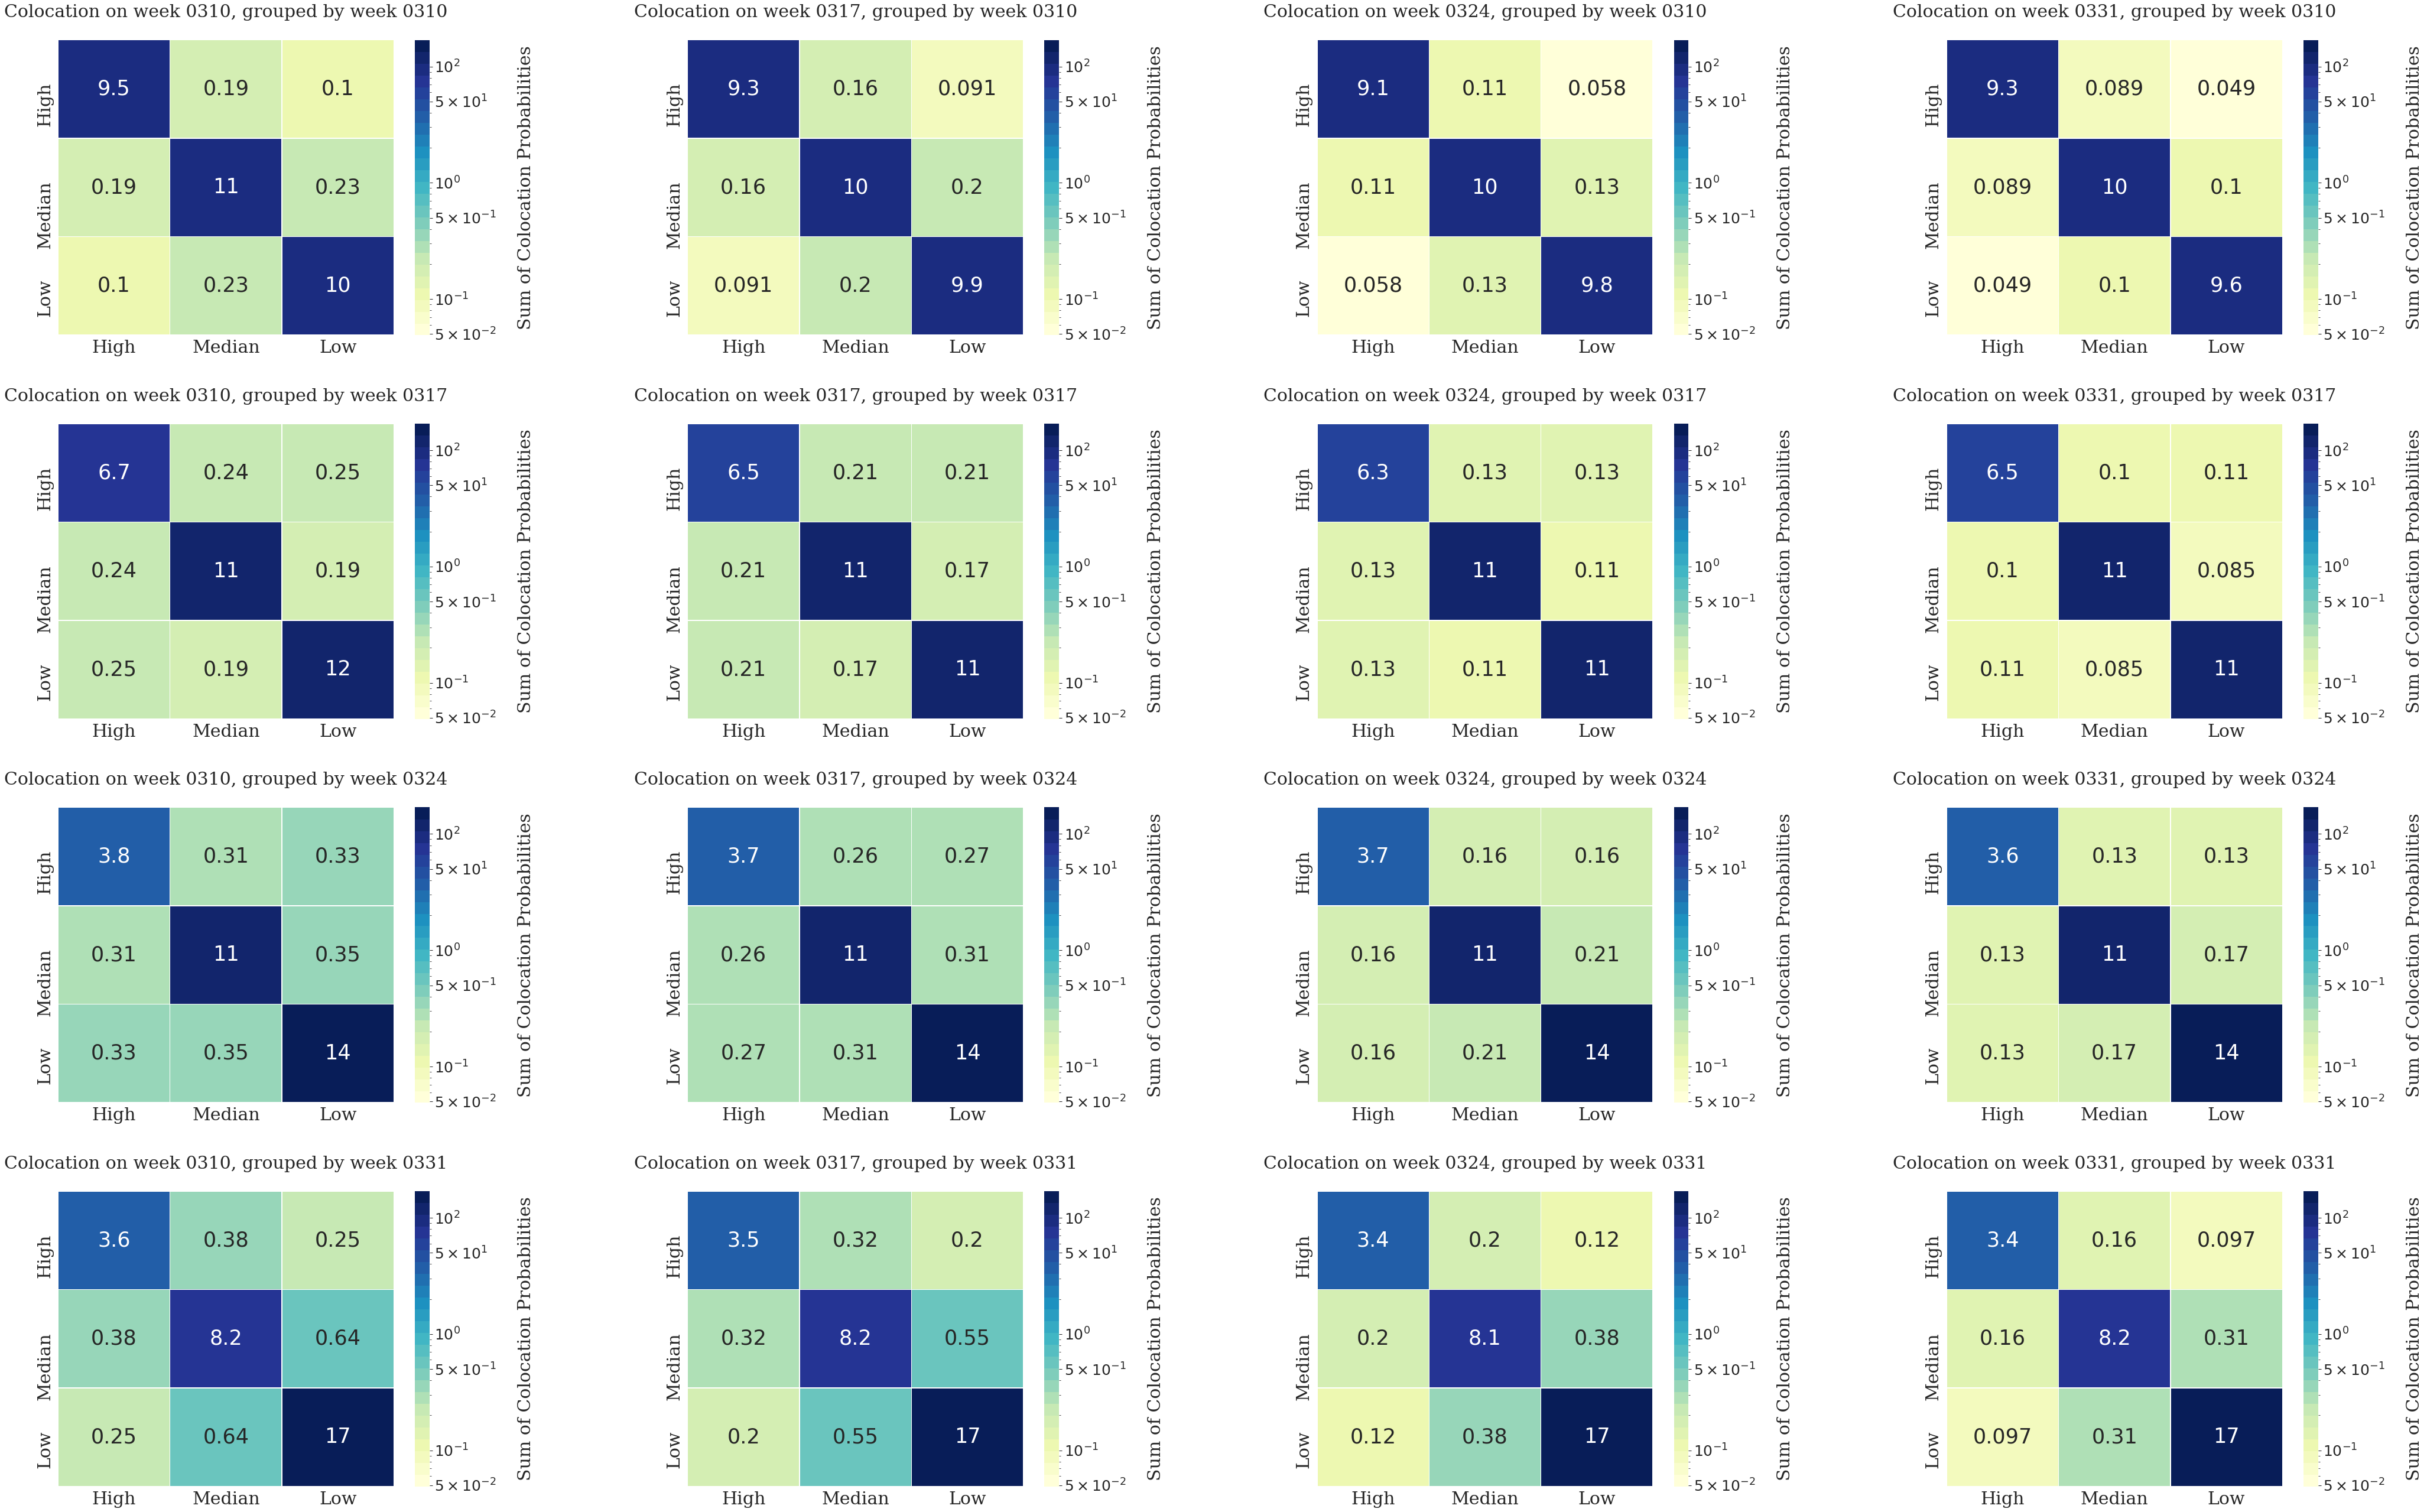

In [425]:
fig, axs = plt.subplots(4, 4,figsize=(70, 40))
plt.subplots_adjust(wspace=0.5, hspace=0.3,
                    left=0.125, right=0.9,
                    top=0.95,    bottom=0.1)

cmap = plt.get_cmap('YlGnBu',25)
cbar_ticks = [0,.1, .01,.001,.0001,.05,.005,.0005,.5, 1]

for row, wk_1 in enumerate(group_week):
    for col, wk_2 in enumerate(group_week):
        ax2 = sns.heatmap(hmap[wk_1][wk_2]+noise, annot=True,annot_kws={"size": 35}, xticklabels=x_axis_labels, yticklabels=y_axis_labels ,
                          linewidth=.3, norm=LogNorm(vmin=hvmin+noise, vmax=hvmax),
           cmap=cmap, cbar_kws={'label': '\nSum of Colocation Probabilities','ticks': cbar_ticks},vmin=hvmin+noise, vmax=hvmax, ax=axs[row, col])
        # sns.heatmap(corr.round(2),vmin=-1, vmax=1,annot = True, cmap=cmap, cbar_kws={'label': 'Correlation Coefficients'}, ax=ax)
        axs[row, col].figure.axes[-1].yaxis.label.set_size(30)
        axs[row, col].figure.axes[-1].yaxis.label.set_fontname('serif')

        cbar = ax2.collections[0].colorbar
        cbar.set_ticks([0,.1, .01,.001,.0001,.05,.005,.0005,.5, 1, 5, 10])
        cbar.set_ticklabels([r'$10^{0}$',r'$10^{-1}$',r'$10^{-2}$',r'$10^{-3}$',r'$10^{-4}$',r'$5\times10^{-2}$',r'$5\times10^{-3}$',r'$5\times10^{-4}$',r'$5\times10^{-1}$', r'$10^{0}$', r'$5\times10^{1}$',r'$10^{2}$'])


        cax = plt.gcf().axes[-1]
        cax.tick_params(labelsize=25)

        for tick in axs[row, col].get_xticklabels():
            tick.set_fontname("serif")
            tick.set_fontsize(30)
        for tick in axs[row, col].get_yticklabels():
            tick.set_fontname("serif")
            tick.set_fontsize(30)
            
        axs[row, col].spines["top"].set_color('k')
        axs[row, col].spines["left"].set_color('k')
        axs[row, col].spines["right"].set_color('k')
        axs[row, col].spines["bottom"].set_color('k')
        axs[row, col].set_title(f'Colocation on week {wk_2}, grouped by week {wk_1}\n',fontname='serif', fontsize=30)
        
        
        
        
        
plt.savefig(f'Colocation_heatmap_and_grouped_by_weeks.pdf',bbox_inches = 'tight')     
plt.show()

In [426]:
for wk in group_week:
    print('Group H')
    print(wk, ' week rank')
    print(len(groupH[wk]))
    print('Group M')
    print(wk, ' week rank')
    print(len(groupM[wk]))
    print('Group L')
    print(wk, ' week rank')
    print(len(groupL[wk]))

Group H
0310  week rank
1009
Group M
0310  week rank
1009
Group L
0310  week rank
1009
Group H
0317  week rank
1009
Group M
0317  week rank
1009
Group L
0317  week rank
1009
Group H
0324  week rank
1009
Group M
0324  week rank
1009
Group L
0324  week rank
1009
Group H
0331  week rank
1009
Group M
0331  week rank
1009
Group L
0331  week rank
1009


In [427]:
for ids in groupH['0310']:
    if ids not in groupH['0331']:
        print(ids)

1365397
1072026
1419303
1365304
1071334
1075569
1216954
1216981
1217351
1217364
1217391
1217432
1217472
1220665
1220670
1220675
1220679
1220682
1220687
1217336
1216997
1217113
1217011
1217024
1217055
1216937
1217099
1217147
1217163
1217179
1217198
1217216
1216604
1216922
1215040
1214748
1214770
1214815
1214845
1214876
1214927
1214941
1214973
1214994
1215065
1215141
1215176
1215210
1215330
1215374
1215832
1215848
1215861
1214712
1214708
1214673
1214614
1214017
1214070
1214109
1214145
1214154
1214175
1214184
1214207
1214225
1214276
1214294
1214318
1214353
1214398
1214439
1214452
1214513
1214523
1214547
1214594
1215906
1215921
1216459
1216490
1216504
1216522
1216534
1216549
1216573
1216648
1216692
1216837
1216850
1216880
1216474
1216439
1215953
1215988
1216003
1216044
1216080
1216104
1216204
1216243
1216271
1216309
1216322
1216373
1220692
1220847
1220699
1408136
1408200
1408377
1408472
1408505
1408546
1408633
1408667
1408085
1408053
1365406
1365412
1407451
1407549
1407660
1407851
1407913


## T-test results for the metric values across different county groups

In [428]:
group_week_sub = ['2020-03-10','2020-03-17','2020-03-24','2020-03-31']
for i, wk in enumerate(group_week):

    dgre_H = []
    dgre_M = []
    dgre_L = []
    for idx, row in dgre_vector[['polygon1_id',group_week_sub[i]]].iterrows():
        if row['polygon1_id'] in groupH[wk]:
            dgre_H.append(row[group_week_sub[i]])
        elif row['polygon1_id']  in groupM[wk]:
            dgre_M.append(row[group_week_sub[i]])
        elif row['polygon1_id']  in groupL[wk]:
            dgre_L.append(row[group_week_sub[i]])

    print(f'Catg by {wk}')
    print('H-M', stats.ttest_ind(dgre_H, dgre_M, equal_var = False))
    print('H-L', stats.ttest_ind(dgre_H, dgre_L, equal_var = False))


Catg by 0310
H-M Ttest_indResult(statistic=-5.977177069221664, pvalue=2.686136401936485e-09)
H-L Ttest_indResult(statistic=-7.322263073935469, pvalue=3.5218922229236996e-13)
Catg by 0317
H-M Ttest_indResult(statistic=-11.398965710907312, pvalue=3.3281588038037057e-29)
H-L Ttest_indResult(statistic=-12.438527369596768, pvalue=3.003462509800973e-34)
Catg by 0324
H-M Ttest_indResult(statistic=-13.556180142176883, pvalue=1.7538520211561902e-39)
H-L Ttest_indResult(statistic=-19.61246468438995, pvalue=6.549687798632111e-76)
Catg by 0331
H-M Ttest_indResult(statistic=-13.970375329502016, pvalue=5.806528300246856e-42)
H-L Ttest_indResult(statistic=-19.826331984348602, pvalue=6.001139227240398e-76)


In [429]:
for i, wk in enumerate(group_week):

    dgre_H = []
    dgre_M = []
    dgre_L = []
    for idx, row in confirmed_1_vector[['polygon1_id',group_week_sub[i]]].iterrows():
        if row['polygon1_id'] in groupH[wk]:
            dgre_H.append(row[group_week_sub[i]])
        elif row['polygon1_id']  in groupM[wk]:
            dgre_M.append(row[group_week_sub[i]])
        elif row['polygon1_id']  in groupL[wk]:
            dgre_L.append(row[group_week_sub[i]])

    print(f'Catg by {wk}')
    print('H-M', stats.ttest_ind(dgre_H, dgre_M, equal_var = False))
    print('H-L', stats.ttest_ind(dgre_H, dgre_L, equal_var = False))

Catg by 0310
H-M Ttest_indResult(statistic=4.097796209306902, pvalue=4.511609357008811e-05)
H-L Ttest_indResult(statistic=4.097796209306902, pvalue=4.511609357008811e-05)
Catg by 0317
H-M Ttest_indResult(statistic=5.097964799195253, pvalue=4.1032697456143835e-07)
H-L Ttest_indResult(statistic=5.0989368286961, pvalue=4.082787176587146e-07)
Catg by 0324
H-M Ttest_indResult(statistic=3.0223541155679325, pvalue=0.0025716098850778065)
H-L Ttest_indResult(statistic=3.042080244052881, pvalue=0.0024103632557011343)
Catg by 0331
H-M Ttest_indResult(statistic=4.05997326938505, pvalue=5.2883762356237114e-05)
H-L Ttest_indResult(statistic=4.115542134999807, pvalue=4.1785931687168794e-05)


In [430]:

for wk in group_week:
    temp = pd.read_csv('colocation_v2/save_df/week'+wk+'_df.csv')[['polygon1_id','polygon2_id','E_TOTPOP_x','E_TOTPOP_y']]
    temp_1 = temp[['polygon1_id','E_TOTPOP_x']].rename(columns={'E_TOTPOP_x': 'E_TOTPOP'}).copy()
    temp_2 = temp[['polygon2_id','E_TOTPOP_y']].rename(columns={'polygon2_id':'polygon1_id','E_TOTPOP_y': 'E_TOTPOP'}).copy()

    temp = pd.concat([temp_1, temp_2]).drop_duplicates()
    dgre_H = []
    dgre_M = []
    dgre_L = []
    for idx, row in temp.iterrows():
        if row['polygon1_id'] in groupH[wk]:
            dgre_H.append(row['E_TOTPOP'])
        elif row['polygon1_id']  in groupM[wk]:
            dgre_M.append(row['E_TOTPOP'])
        elif row['polygon1_id']  in groupL[wk]:
            dgre_L.append(row['E_TOTPOP'])
            
    print(f'Catg by {wk}')
    print('H-M', stats.ttest_ind(dgre_H, dgre_M, equal_var = False))
    print('H-L', stats.ttest_ind(dgre_H, dgre_L, equal_var = False))

Catg by 0310
H-M Ttest_indResult(statistic=6.706232572363221, pvalue=3.08901244471064e-11)
H-L Ttest_indResult(statistic=6.020397332892967, pvalue=2.3020684975784797e-09)
Catg by 0317
H-M Ttest_indResult(statistic=11.664016710064791, pvalue=1.3113986323920658e-29)
H-L Ttest_indResult(statistic=11.718733742949277, pvalue=7.540259871997215e-30)
Catg by 0324
H-M Ttest_indResult(statistic=13.490691107865052, pvalue=2.856699624829433e-38)
H-L Ttest_indResult(statistic=13.367590701622724, pvalue=6.687095989122035e-38)
Catg by 0331
H-M Ttest_indResult(statistic=13.703609080527018, pvalue=2.478643610691463e-39)
H-L Ttest_indResult(statistic=13.907059817604978, pvalue=1.1731560338970365e-40)


In [446]:
coloc_df = {}

for wk in group_week: # CDC ranking week
    coloc_df[wk] = {}

for wk_2 in group_week: # CDC ranking week
    coloc_df[wk_1] = group_colocation['0310'][wk_2][['polygon1_id','polygon2_id','link_value']].merge(group_colocation['0317'][wk_2], on=['polygon1_id','polygon2_id'])[['polygon1_id','polygon2_id','link_value_x','link_value_y']].merge(group_colocation[wk_1][wk_2], on=['polygon1_id','polygon2_id'])

In [448]:
edges_df = {}
for wk_1 in group_week:
    edges_df[wk_1] = group_colocation[wk_1]['0310'][['polygon1_id','polygon2_id','link_value']].merge(group_colocation[wk_1]['0317'], on=['polygon1_id','polygon2_id'])[['polygon1_id','polygon2_id','link_value_x','link_value_y']].merge(group_colocation[wk_1]['0324'], on=['polygon1_id','polygon2_id'])
    #.rename(columns={'link_value_x':'link_value_0310','link_value_y':'link_value_0317','link_value':'link_value_0324'}).merge(group_colocation['0331'][wk_2][df_columns], on=['polygon1_id','polygon2_id'])

In [449]:
edges_df[wk_1]

polygon1_id  polygon2_id  link_value_x  link_value_y    link_value  \
0           1216124      1429571  1.330943e-08  1.832342e-09  3.172759e-10   
1           1112045      1429571  1.037886e-08  3.852512e-09  4.943485e-11   
2           1428951      1429571  2.195795e-04  1.870823e-04  1.121144e-04   
3           1111860      1429571  7.727636e-08  1.218272e-09  4.650791e-09   
4           1195635      1429571  2.255418e-07  1.620068e-07  4.073360e-08   
...             ...          ...           ...           ...           ...   
637749       819592       819624  9.024094e-04  1.048577e-03  7.364041e-04   
637750       819561       819624  2.073847e-04  1.477839e-04  7.308048e-05   
637751      1425869       819624  3.955596e-07  4.724112e-06  2.117209e-06   
637752       819624       819624  1.924787e-02  2.419321e-02  2.151749e-02   
637753      1425893       819624  2.859331e-05  2.893519e-05  7.039031e-05   

       group1 group2  
0           H      M  
1           H      M  
2           M      M  
3           H      M  
4           H      M  
...       ...    ...  
637749      M      L  
637750      L      L  
637751      M      L  
637752      L      L  
637753      L      L  

[637754 rows x 7 columns]

In [458]:
# for idx, row in edges_df.iterrows:
#     if row.group1 == 'H'

for wk_1 in group_week:

    HH = []
    HM = []
    HL = []

    MH = []
    MM = []
    ML = []

    LH = []
    LM = []
    LL = []

    # from March 10th to 24th
    for i, (idx, row) in enumerate(edges_df[wk_1].iterrows()):
        if (row.group1 == 'H') and (row.group2 == 'H'):
            HH.append((row.link_value_y - row.link_value_x)/(row.link_value_x))
        elif (row.group1 == 'H') and (row.group2 == 'M'):
            HM.append((row.link_value_y - row.link_value_x)/(row.link_value_x))
        elif (row.group1 == 'H') and (row.group2 == 'L'):
            HL.append((row.link_value_y - row.link_value_x)/(row.link_value_x))
        elif (row.group1 == 'M') and (row.group2 == 'H'):
            MH.append((row.link_value_y - row.link_value_x)/(row.link_value_x))
        elif (row.group1 == 'M') and (row.group2 == 'M'):
            MM.append((row.link_value_y - row.link_value_x)/(row.link_value_x))
        elif (row.group1 == 'M') and (row.group2 == 'L'):
            ML.append((row.link_value_y - row.link_value_x)/(row.link_value_x))
        elif (row.group1 == 'L') and (row.group2 == 'H'):
            LH.append((row.link_value_y - row.link_value_x)/(row.link_value_x))
        elif (row.group1 == 'L') and (row.group2 == 'M'):
            LM.append((row.link_value_y - row.link_value_x)/(row.link_value_x))
        elif (row.group1 == 'L') and (row.group2 == 'L'):
            LL.append((row.link_value_y - row.link_value_x)/(row.link_value_x))
            
    HH_df = pd.DataFrame(HH)#.rename(columns={0:'HH'})
    HM_df = pd.DataFrame(HM)#.rename(columns={0:'HM'})
    HL_df = pd.DataFrame(HL)#.rename(columns={0:'HL'})
    MH_df = pd.DataFrame(MH)#.rename(columns={0:'MH'})
    MM_df = pd.DataFrame(MM)#.rename(columns={0:'MM'})
    ML_df = pd.DataFrame(ML)#.rename(columns={0:'ML'})
    LH_df = pd.DataFrame(LH)#.rename(columns={0:'LH'})
    LM_df = pd.DataFrame(LM)#.rename(columns={0:'LM'})
    LL_df = pd.DataFrame(LL)#.rename(columns={0:'LL'})

    #     HH_df['group'] = 'A'
    #     HM_df['group'] = 'B'
    #     HL_df['group'] = 'C'
    #     MM_df['group'] = 'D'
    #     ML_df['group'] = 'E'
    #     LL_df['group'] = 'F'
    
    print(wk_1, 'week')
    print(stats.ttest_ind(HH_df[0].values, HM_df[0].values,equal_var = False))
    print(stats.ttest_ind(HH_df[0].values, HL_df[0].values,equal_var = False))
    print(stats.ttest_ind(MM_df[0].values, HM_df[0].values,equal_var = False))
    print(stats.ttest_ind(MM_df[0].values, ML_df[0].values,equal_var = False))
    print(stats.ttest_ind(LL_df[0].values, HL_df[0].values,equal_var = False))
    print(stats.ttest_ind(LL_df[0].values, ML_df[0].values,equal_var = False))
    

0310 week
Ttest_indResult(statistic=-5.081817896998781, pvalue=3.745766790953001e-07)
Ttest_indResult(statistic=-5.886427304842289, pvalue=3.960939169481775e-09)
Ttest_indResult(statistic=-6.383255563123471, pvalue=1.7427063111074872e-10)
Ttest_indResult(statistic=-6.321716795195153, pvalue=2.5982499072600106e-10)
Ttest_indResult(statistic=-5.004994383402585, pvalue=5.596622373158966e-07)
Ttest_indResult(statistic=-3.771388697453108, pvalue=0.0001624240838774569)
0317 week
Ttest_indResult(statistic=-4.830920623686482, pvalue=1.3608071327639754e-06)
Ttest_indResult(statistic=-5.489336076462717, pvalue=4.044760282672781e-08)
Ttest_indResult(statistic=-8.834799177901537, pvalue=1.0174397728854326e-18)
Ttest_indResult(statistic=-4.639270000254327, pvalue=3.5047432469015857e-06)
Ttest_indResult(statistic=-11.071860761972752, pvalue=1.802490692764345e-28)
Ttest_indResult(statistic=-6.490619748986942, pvalue=8.640089095585263e-11)
0324 week
Ttest_indResult(statistic=-2.5950215075145286, pvalu

## Visualization of the metric values across different county groups

In [477]:
def growthRate_linear(temp):
    n_temp = []
    noise = 0.000001
    for i, t in enumerate(temp):
        if i == 0:
            n_temp.append(0)
        else:
            n_temp.append((temp[i]-temp[i-1])/7)
    return n_temp

def growthRate_exp(temp):
    n_temp = []
    noise = 0.000001
    for i, t in enumerate(temp):
        if i == 0:
            n_temp.append(0)
        else:
            n_temp.append((np.log(temp[i]+noise)-np.log(temp[i-1]+noise))/7)
    return n_temp

temp_confirmed = confirmed_vector.copy()
temp_dgre = dgre_vector.copy()

K_H = {}
K_M = {}
K_L = {}

M_H = {}
M_M = {}
M_L = {}



# for ids in temp_confirmed.polygon1_id.values:
#     K[ids] = growthRate_linear(temp_confirmed[temp_confirmed.polygon1_id==ids][vector_cols[1:]].values[0])
for ids in temp_dgre.polygon1_id.values:
    if ids in groupH:
        K_H[ids] = growthRate_linear(temp_confirmed[temp_confirmed.polygon1_id==ids][vector_cols[1:]].values[0])
    elif ids in groupM:
        K_M[ids] = growthRate_linear(temp_confirmed[temp_confirmed.polygon1_id==ids][vector_cols[1:]].values[0])
    elif ids in groupL:
        K_L[ids] = growthRate_linear(temp_confirmed[temp_confirmed.polygon1_id==ids][vector_cols[1:]].values[0])

for ids in temp_dgre.polygon1_id.values:
    if ids in groupH:
        M_H[ids] = growthRate_linear(temp_dgre[temp_dgre.polygon1_id==ids][vector_cols[1:]].values[0])
    elif ids in groupM:
        M_M[ids] = growthRate_linear(temp_dgre[temp_dgre.polygon1_id==ids][vector_cols[1:]].values[0])
    elif ids in groupL:
        M_L[ids] = growthRate_linear(temp_dgre[temp_dgre.polygon1_id==ids][vector_cols[1:]].values[0])

K_H_df = pd.DataFrame.from_dict(K_H).T.reset_index().rename(columns={'index':'polygon1_id'})
K_M_df = pd.DataFrame.from_dict(K_M).T.reset_index().rename(columns={'index':'polygon1_id'})
K_L_df = pd.DataFrame.from_dict(K_L).T.reset_index().rename(columns={'index':'polygon1_id'})

M_H_df = pd.DataFrame.from_dict(M_H).T.reset_index().rename(columns={'index':'polygon1_id'})
M_M_df = pd.DataFrame.from_dict(M_M).T.reset_index().rename(columns={'index':'polygon1_id'})
M_L_df = pd.DataFrame.from_dict(M_L).T.reset_index().rename(columns={'index':'polygon1_id'})

In [478]:
K3_H = K_H_df[['polygon1_id',3]]
K3_M = K_M_df[['polygon1_id',3]]
K3_L = K_L_df[['polygon1_id',3]]
K3_H['group'] = 'H'
K3_M['group'] = 'M'
K3_L['group'] = 'L'

K3_barplot = pd.concat([K3_H,K3_M, K3_L])

/home/ubuntu/anaconda3/envs/shlee/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/home/ubuntu/anaconda3/envs/shlee/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/home/ubuntu/anaconda3/envs/shlee/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the c

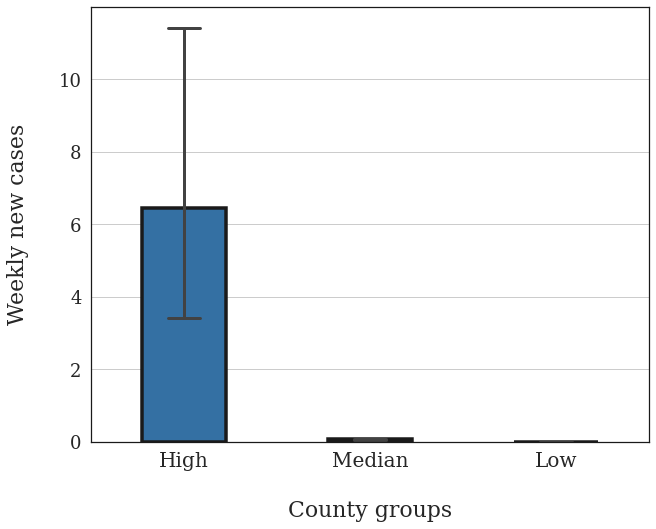

In [480]:
sns.set(style="whitegrid")
fig = plt.figure(figsize=(10,8))
ax1 = fig.add_subplot(111)
sns.set_color_codes("pastel")

sns.barplot(x='group', y=3,data=K3_barplot, errwidth=3, palette='Blues_r',
              capsize=.17, edgecolor='k', linewidth=3.5, ax=ax1)
y_axis_list = ['0','2','4','6','8','10','12']
ax1.set_yticklabels(y_axis_list,fontname='serif', size=18)
ax1.set_xticklabels(['High','Median','Low'],fontname='serif', size=20)

ax1.set_xlabel(" \nCounty groups", fontname="serif", fontsize=22)
ax1.set_ylabel("Weekly new cases\n ", fontname="serif", fontsize=22)

def change_width(ax, new_value) :
    for patch in ax.patches :
        current_width = patch.get_width()
        diff = current_width - new_value

        # we change the bar width
        patch.set_width(new_value)

        # we recenter the bar
        patch.set_x(patch.get_x() + diff * .5)

change_width(ax1, .45)

ax1.spines["top"].set_color('k')
ax1.spines["left"].set_color('k')
ax1.spines["right"].set_color('k')
ax1.spines["bottom"].set_color('k')

# plt.title('Growth rate of COVID19 weekly new confirmed cases by groups on week 3/24 (K3)\n ',fontname='serif',fontsize=22)
plt.savefig('barplot_growthRate_Group.pdf', bbox_inches='tight') 

In [ ]:
df_0 = pd.read_csv('colocation_v2/save_df/week0310_df.csv')
df_1 = pd.read_csv('colocation_v2/save_df/week0324_df.csv')
df_2 = pd.read_csv('colocation_v2/save_df/week0407_df.csv')

In [469]:
cdc_ranking = cdc_weekly_confirmed['0331'].sort_values(by=['Confirmed'],ascending=False)['polygon1_id']

ranking_temp = cdc_ranking.values
sizeofGroup= int((len(ranking_temp)/3))
groupH = ranking_temp[:sizeofGroup]
groupM = ranking_temp[sizeofGroup : sizeofGroup*2]
groupL = ranking_temp[sizeofGroup*2:sizeofGroup*3]

group_H_df = pd.DataFrame(groupH).rename(columns={0:'polygon1_id'})
group_H_df['group'] = 'H'

group_M_df = pd.DataFrame(groupM).rename(columns={0:'polygon1_id'})
group_M_df['group'] = 'M'

group_L_df = pd.DataFrame(groupL).rename(columns={0:'polygon1_id'})
group_L_df['group'] = 'L'

group_pair = pd.concat([group_H_df,group_M_df,group_L_df])

In [470]:
peop_df = df_0[['polygon1_id','E_TOTPOP_x']].drop_duplicates()
peop_den_df = df_0[['polygon1_id','AREA_SQMI_x']].drop_duplicates()
peop_df = peop_df.merge(group_pair, on='polygon1_id').rename(columns={'E_TOTPOP_x': 'peop'})
peop_den_df = peop_den_df.merge(group_pair, on='polygon1_id').rename(columns={'AREA_SQMI_x': 'peop_den'})

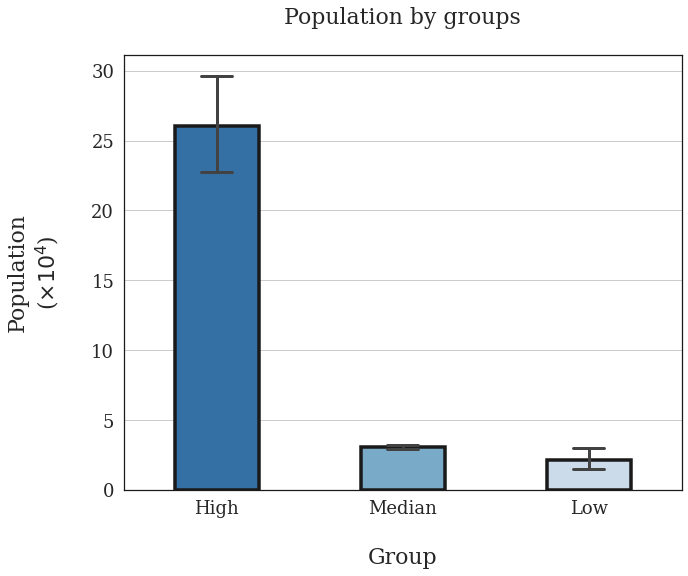

In [472]:
sns.set(style="whitegrid")
fig, ax1 = plt.subplots(1,1,figsize=(10, 8))

kwargs = {'alpha':1, 'linestyle':'-',  'linewidth':3.5, 'edgecolor':'k'}

sns.barplot(x='group',y='peop', data=peop_df,errwidth = 3,
             palette="Blues_r", capsize=0.17 ,ax = ax1,**kwargs)


    
y_axis_list = ['0','5','10','15','20','25','30']
ax1.set_yticklabels(y_axis_list,fontname='serif', size=18)
ax1.set_xticklabels(['High','Median','Low'],fontname='serif', size=18)

ax1.set_xlabel(" \nGroup", fontname="serif", fontsize=22)
ax1.set_ylabel('Population\n('+r'$\times10^{4}$'+')\n', fontname="serif", fontsize=22)

def change_width(ax, new_value) :
    for patch in ax.patches :
        current_width = patch.get_width()
        diff = current_width - new_value

        # we change the bar width
        patch.set_width(new_value)

        # we recenter the bar
        patch.set_x(patch.get_x() + diff * .5)

change_width(ax1, .45)

ax1.spines["top"].set_color('k')
ax1.spines["left"].set_color('k')
ax1.spines["right"].set_color('k')
ax1.spines["bottom"].set_color('k')

plt.title('Population by groups\n ',fontname='serif',fontsize=22)
plt.savefig('barplot_Population_group.pdf', bbox_inches='tight') 

In [473]:
dgre_H = []
dgre_M = []
dgre_L = []

for idx, row in dgre_vector[['polygon1_id','2020-03-24']].iterrows():
    if row['polygon1_id'] in groupH:
        dgre_H.append(row['2020-03-24'])
    elif row['polygon1_id']  in groupM:
        dgre_M.append(row['2020-03-24'])
    elif row['polygon1_id']  in groupL:
        dgre_L.append(row['2020-03-24'])

In [474]:
dgre_H_df = pd.DataFrame(dgre_H)
dgre_H_df['group'] = 'H'
dgre_M_df = pd.DataFrame(dgre_M)
dgre_M_df['group'] = 'M'
dgre_L_df = pd.DataFrame(dgre_L)
dgre_L_df['group'] = 'L'

In [475]:
barplot_dgre_df = dgre_H_df.append([dgre_M_df, dgre_L_df])

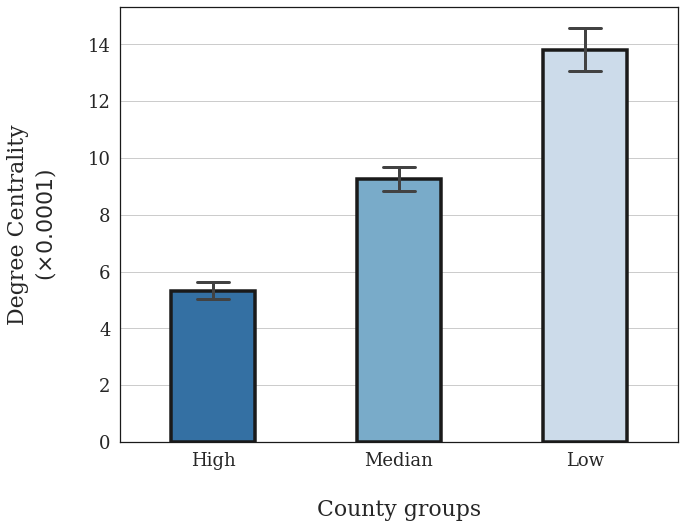

In [476]:
sns.set(style="whitegrid")
fig = plt.figure(figsize=(10,8))
ax1 = fig.add_subplot(111)
sns.set_color_codes("pastel")

sns.barplot(x='group',y=0, data=barplot_dgre_df, palette='Blues_r',errwidth=3, capsize=.17, edgecolor='k', linewidth=3.5,ax=ax1)

y_axis_list = ['0','2','4','6','8','10','12','14']
ax1.set_yticklabels(y_axis_list,fontname='serif', size=18)
ax1.set_xticklabels(['High','Median','Low'],fontname='serif', size=18)

ax1.set_xlabel(" \nCounty groups", fontname="serif", fontsize=22)
ax1.set_ylabel('Degree Centrality\n('+r'$\times0.0001$'+')\n', fontname="serif", fontsize=22)
# plt.title('Colocation Degree Centrality by groups\n ',fontname='serif',fontsize=22)

def change_width(ax, new_value) :
    for patch in ax.patches :
        current_width = patch.get_width()
        diff = current_width - new_value

        # we change the bar width
        patch.set_width(new_value)

        # we recenter the bar
        patch.set_x(patch.get_x() + diff * .5)

change_width(ax1, .45)

ax1.spines["top"].set_color('k')
ax1.spines["left"].set_color('k')
ax1.spines["right"].set_color('k')
ax1.spines["bottom"].set_color('k')

plt.savefig('barplot_DegreeCentralityOfGroups.pdf', bbox_inches='tight') 

In [ ]:
cdc_ranking = cdc_weekly_confirmed['0317'].sort_values(by=['Confirmed'],ascending=False)['polygon1_id']

ranking_temp = cdc_ranking.values
sizeofGroup= int((len(ranking_temp)/3))
groupH = ranking_temp[:sizeofGroup]
groupM = ranking_temp[sizeofGroup : sizeofGroup*2]
groupL = ranking_temp[sizeofGroup*2:sizeofGroup*3]

group_H_df = pd.DataFrame(groupH).rename(columns={0:'polygon1_id'})
group_H_df['group'] = 'H'

group_M_df = pd.DataFrame(groupM).rename(columns={0:'polygon1_id'})
group_M_df['group'] = 'M'

group_L_df = pd.DataFrame(groupL).rename(columns={0:'polygon1_id'})
group_L_df['group'] = 'L'

group_pair = pd.concat([group_H_df,group_M_df,group_L_df])

In [464]:
df_columns = ['polygon1_id', 'polygon2_id', 'link_value']
group_colocation_0 = df_0[df_columns].merge(group_pair.rename(columns={'group':'group1'}), on='polygon1_id').merge(group_pair.rename(columns={'polygon1_id':'polygon2_id', 'group':'group2'}), on='polygon2_id')
group_colocation_1 = df_1[df_columns].merge(group_pair.rename(columns={'group':'group1'}), on='polygon1_id').merge(group_pair.rename(columns={'polygon1_id':'polygon2_id', 'group':'group2'}), on='polygon2_id')
group_colocation_2 = df_2[df_columns].merge(group_pair.rename(columns={'group':'group1'}), on='polygon1_id').merge(group_pair.rename(columns={'polygon1_id':'polygon2_id', 'group':'group2'}), on='polygon2_id')

edges_df = group_colocation_0[['polygon1_id','polygon2_id','link_value']].merge(group_colocation_1, on=['polygon1_id','polygon2_id'])[['polygon1_id','polygon2_id','link_value_x','link_value_y']].merge(group_colocation_2, on=['polygon1_id','polygon2_id'])


HH = []
HM = []
HL = []

MH = []
MM = []
ML = []

LH = []
LM = []
LL = []

# from March 10th to 24th
for i, (idx, row) in enumerate(edges_df.iterrows()):
    if (row.group1 == 'H') and (row.group2 == 'H'):
        HH.append((row.link_value_y - row.link_value_x)/(row.link_value_x))
    elif (row.group1 == 'H') and (row.group2 == 'M'):
        HM.append((row.link_value_y - row.link_value_x)/(row.link_value_x))
    elif (row.group1 == 'H') and (row.group2 == 'L'):
        HL.append((row.link_value_y - row.link_value_x)/(row.link_value_x))
    elif (row.group1 == 'M') and (row.group2 == 'H'):
        MH.append((row.link_value_y - row.link_value_x)/(row.link_value_x))
    elif (row.group1 == 'M') and (row.group2 == 'M'):
        MM.append((row.link_value_y - row.link_value_x)/(row.link_value_x))
    elif (row.group1 == 'M') and (row.group2 == 'L'):
        ML.append((row.link_value_y - row.link_value_x)/(row.link_value_x))
    elif (row.group1 == 'L') and (row.group2 == 'H'):
        LH.append((row.link_value_y - row.link_value_x)/(row.link_value_x))
    elif (row.group1 == 'L') and (row.group2 == 'M'):
        LM.append((row.link_value_y - row.link_value_x)/(row.link_value_x))
    elif (row.group1 == 'L') and (row.group2 == 'L'):
        LL.append((row.link_value_y - row.link_value_x)/(row.link_value_x))

HH_df = pd.DataFrame(HH)#.rename(columns={0:'HH'})
HM_df = pd.DataFrame(HM)#.rename(columns={0:'HM'})
HL_df = pd.DataFrame(HL)#.rename(columns={0:'HL'})
MH_df = pd.DataFrame(MH)#.rename(columns={0:'MH'})
MM_df = pd.DataFrame(MM)#.rename(columns={0:'MM'})
ML_df = pd.DataFrame(ML)#.rename(columns={0:'ML'})
LH_df = pd.DataFrame(LH)#.rename(columns={0:'LH'})
LM_df = pd.DataFrame(LM)#.rename(columns={0:'LM'})
LL_df = pd.DataFrame(LL)#.rename(columns={0:'LL'})

HH_df['group'] = 'A'
HM_df['group'] = 'B'
HL_df['group'] = 'C'
# MH_df['group'] = 'D'
MM_df['group'] = 'D'
ML_df['group'] = 'E'
# LH_df['group'] = 'G'
# LM_df['group'] = 'H'
LL_df['group'] = 'F'

cross_barplot = HH_df.append(HM_df)
cross_barplot = cross_barplot.append(HL_df)
cross_barplot = cross_barplot.append(MM_df)
cross_barplot = cross_barplot.append(ML_df)
cross_barplot = cross_barplot.append(LL_df)

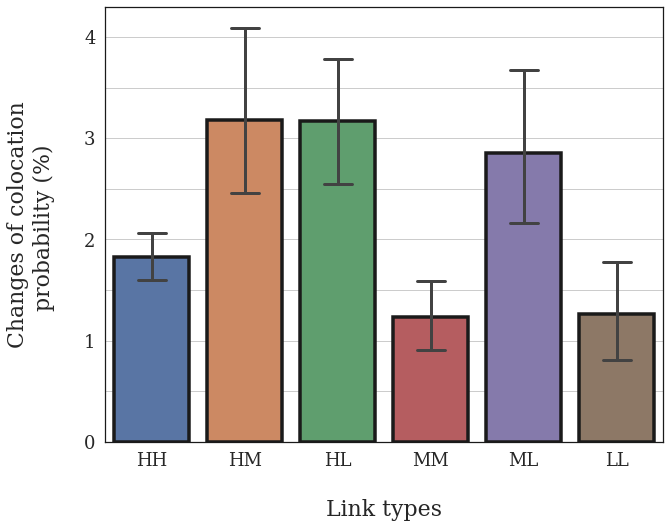

In [465]:
sns.set(style="whitegrid")
sns.set_color_codes("pastel")
fig = plt.figure(figsize=(10,8))
ax1 = fig.add_subplot(111)

sns.barplot(x='group', y=0, data=cross_barplot, edgecolor='k',errwidth=3, capsize=.3, linewidth=3.5,ax=ax1)

# y_axis_list = ['0',' ','1',' ','2',' ','3',' ','4']
ax1.set_yticklabels(y_axis_list,fontname='serif', size=18)
ax1.set_xticklabels(['HH','HM','HL','MM','ML','LL'],fontname='serif', size=18)

ax1.set_xlabel(" \nLink types", fontname="serif", fontsize=22)
ax1.set_ylabel("Changes of colocation\nprobability (%) \n ", fontname="serif", fontsize=22)


def change_width(ax, new_value) :
    for patch in ax.patches :
        current_width = patch.get_width()
        diff = current_width - new_value

        # we change the bar width
        patch.set_width(new_value)

        # we recenter the bar
        patch.set_x(patch.get_x() + diff * .5)

change_width(ax1, .8)


ax1.spines["top"].set_color('k')
ax1.spines["left"].set_color('k')
ax1.spines["right"].set_color('k')
ax1.spines["bottom"].set_color('k')

### Random Shuffle

In [491]:
path_rs = 'colocation/rs.csv'
rs_df = pd.read_csv(path_rs)

In [492]:
rs_df = rs_df.rename(columns={'county1_id_x':'polygon1_id','county2_id':'polygon2_id','prediction':'link_value'})
group_rs = rs_df[df_columns].merge(group_pair.rename(columns={'group':'group1'}), on='polygon1_id').merge(group_pair.rename(columns={'polygon1_id':'polygon2_id', 'group':'group2'}), on='polygon2_id')

In [493]:
group_rs

polygon1_id  polygon2_id    link_value group1 group2
0           1201642    1090159.0  5.623277e-07      L      H
1           1217231    1090159.0  3.476166e-11      H      H
2           1200245    1090159.0  7.436111e-09      H      H
3            531980    1090159.0  2.972527e-10      H      H
4           1196453    1090159.0  3.304374e-09      L      H
...             ...          ...           ...    ...    ...
506319      1074274    1201642.0  1.605972e-05      M      L
506320       958698    1201642.0  7.827341e-06      L      L
506321       959526    1201642.0  2.369460e-06      L      L
506322       958615    1201642.0  3.030497e-08      L      L
506323      1201331    1201642.0  9.221635e-08      L      L

[506324 rows x 5 columns]

In [494]:
sumHH = 0
sumHM = 0
sumHL = 0

sumMH = 0
sumMM = 0
sumML = 0

sumLH = 0
sumLM = 0
sumLL = 0

for i, (idx, row) in enumerate(group_rs.iterrows()):
    if (row.group1 == 'H') and (row.group2 == 'H'):
        sumHH += row.link_value
    elif (row.group1 == 'H') and (row.group2 == 'M'):
        sumHM += row.link_value
    elif (row.group1 == 'H') and (row.group2 == 'L'):
        sumHL += row.link_value
    elif (row.group1 == 'M') and (row.group2 == 'H'):
        sumMH += row.link_value
    elif (row.group1 == 'M') and (row.group2 == 'M'):
        sumMM += row.link_value
    elif (row.group1 == 'M') and (row.group2 == 'L'):
        sumML += row.link_value
    elif (row.group1 == 'L') and (row.group2 == 'H'):
        sumLH += row.link_value
    elif (row.group1 == 'L') and (row.group2 == 'M'):
        sumLM += row.link_value
    elif (row.group1 == 'L') and (row.group2 == 'L'):
        sumLL += row.link_value

hmap_b2 = np.zeros((3,3))
elem_list = [sumHH, sumHM, sumHL, sumMH, sumMM, sumML, sumLH, sumLM, sumLL]
k = 0
for i in range(3):
    for j in range(3):
        hmap_b2[i][j] = elem_list[k]
        k += 1

### Gravity model result

In [495]:
path_gravity = 'colocation/result_pop.csv'
result_pop_df = pd.read_csv(path_gravity)

In [496]:
result_pop_df = result_pop_df.rename(columns={'county1_id_x':'polygon1_id','county2_id':'polygon2_id','prediction':'link_value'})
group_result_pop = result_pop_df[df_columns].merge(group_pair.rename(columns={'group':'group1'}), on='polygon1_id').merge(group_pair.rename(columns={'polygon1_id':'polygon2_id', 'group':'group2'}), on='polygon2_id')

In [497]:
sumHH = 0
sumHM = 0
sumHL = 0

sumMH = 0
sumMM = 0
sumML = 0

sumLH = 0
sumLM = 0
sumLL = 0

for i, (idx, row) in enumerate(group_result_pop.iterrows()):
    if (row.group1 == 'H') and (row.group2 == 'H'):
        sumHH += row.link_value
    elif (row.group1 == 'H') and (row.group2 == 'M'):
        sumHM += row.link_value
    elif (row.group1 == 'H') and (row.group2 == 'L'):
        sumHL += row.link_value
    elif (row.group1 == 'M') and (row.group2 == 'H'):
        sumMH += row.link_value
    elif (row.group1 == 'M') and (row.group2 == 'M'):
        sumMM += row.link_value
    elif (row.group1 == 'M') and (row.group2 == 'L'):
        sumML += row.link_value
    elif (row.group1 == 'L') and (row.group2 == 'H'):
        sumLH += row.link_value
    elif (row.group1 == 'L') and (row.group2 == 'M'):
        sumLM += row.link_value
    elif (row.group1 == 'L') and (row.group2 == 'L'):
        sumLL += row.link_value

hmap_b3 = np.zeros((3,3))
elem_list = [sumHH, sumHM, sumHL, sumMH, sumMM, sumML, sumLH, sumLM, sumLL]
k = 0
for i in range(3):
    for j in range(3):
        hmap_b3[i][j] = elem_list[k]
        k += 1

In [500]:
from matplotlib.colors import LogNorm
noise = 0.000000001
# hvmin = min([hmap_0.min(), hmap_1.min(), hmap_2.min()])
# hvmax = max([hmap_0.max(), hmap_1.max(), hmap_2.max()])
hvmin = min([hmap['0324']['0310'].min(),hmap['0324']['0324'].min(), hmap['0324']['0324'].min(), hmap_b2.min(), hmap_b3.min()])
hvmax = max([ hmap['0324']['0310'].max(),hmap['0324']['0324'].max(), hmap['0324']['0324'].max(), hmap_b2.max(), hmap_b3.max()])

x_axis_labels = ['High', 'Median','Low']
y_axis_labels = ['High', 'Median','Low']

cbar_ticks = []
for eN in range(5):
    for i in range(10):
        cbar_ticks.append(i*10**(-eN))

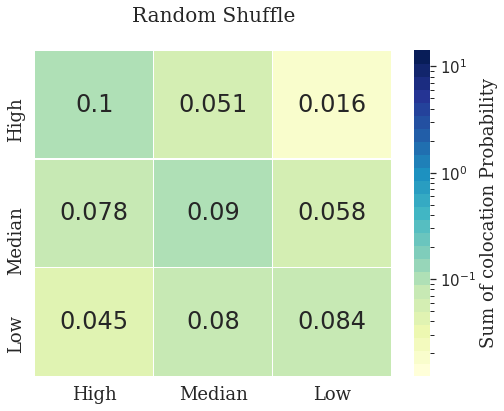

In [502]:
f, ax = plt.subplots(figsize=(8, 6))
cmap = plt.get_cmap('YlGnBu',25)
cbar_ticks = [0,.1, .01,.001,.0001,.05,.005,.0005,.5, 1]

ax2 = sns.heatmap(hmap_b2+noise, annot=True,annot_kws={"size": 24}, alpha=1, xticklabels=x_axis_labels, yticklabels=y_axis_labels ,linewidth=.3, norm=LogNorm(vmin=hvmin+noise, vmax=hvmax),
           cmap=cmap, cbar_kws={'label': 'Sum of colocation Probability','ticks': cbar_ticks},vmin=hvmin+noise, vmax=hvmax, ax=ax)
# sns.heatmap(corr.round(2),vmin=-1, vmax=1,annot = True, cmap=cmap, cbar_kws={'label': 'Correlation Coefficients'}, ax=ax)
ax.figure.axes[-1].yaxis.label.set_size(18)
ax.figure.axes[-1].yaxis.label.set_fontname('serif')

cbar = ax2.collections[0].colorbar
cbar.set_ticks([.01, .1, 1, 10])
cbar.set_ticklabels([r'$10^{-2}$',r'$10^{-1}$', r'$10^{0}$', r'$10^{1}$'])

cax = plt.gcf().axes[-1]
cax.tick_params(labelsize=15)

# ax.set_ylabel("Features", tfont)
# ax.set_xlabel("Features", tfont)

for tick in ax.get_xticklabels():
    tick.set_fontname("serif")
    tick.set_fontsize(18)
for tick in ax.get_yticklabels():
    tick.set_fontname("serif")
    tick.set_fontsize(18)
plt.title('Random Shuffle\n',fontname='serif', fontsize='20')
# f.savefig("Colocation_Heatmap_random_shuffle.pdf",bbox_inches = 'tight')
plt.show()

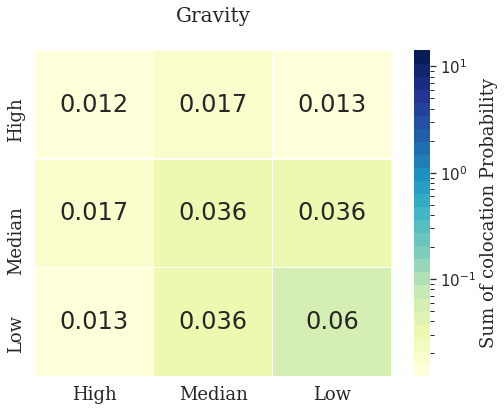

In [503]:
f, ax = plt.subplots(figsize=(8, 6))
cmap = plt.get_cmap('YlGnBu',25)
cbar_ticks = [0,.1, .01,.001,.0001,.05,.005,.0005,.5, 1]

ax2 = sns.heatmap(hmap_b3+noise, annot=True,annot_kws={"size": 24}, alpha=1, xticklabels=x_axis_labels, yticklabels=y_axis_labels ,linewidth=.3, norm=LogNorm(vmin=hvmin+noise, vmax=hvmax),
           cmap=cmap, cbar_kws={'label': 'Sum of colocation Probability','ticks': cbar_ticks},vmin=hvmin+noise, vmax=hvmax, ax=ax)
# sns.heatmap(corr.round(2),vmin=-1, vmax=1,annot = True, cmap=cmap, cbar_kws={'label': 'Correlation Coefficients'}, ax=ax)
ax.figure.axes[-1].yaxis.label.set_size(18)
ax.figure.axes[-1].yaxis.label.set_fontname('serif')

cbar = ax2.collections[0].colorbar
cbar.set_ticks([.01, .1, 1, 10])
cbar.set_ticklabels([r'$10^{-2}$',r'$10^{-1}$', r'$10^{0}$', r'$10^{1}$'])

cax = plt.gcf().axes[-1]
cax.tick_params(labelsize=15)

# ax.set_ylabel("Features", tfont)
# ax.set_xlabel("Features", tfont)

for tick in ax.get_xticklabels():
    tick.set_fontname("serif")
    tick.set_fontsize(18)
for tick in ax.get_yticklabels():
    tick.set_fontname("serif")
    tick.set_fontsize(18)
plt.title('Gravity\n',fontname='serif', fontsize='20')
# f.savefig("Colocation_Heatmap_gravity.pdf",bbox_inches = 'tight')
plt.show()